In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent, mod_state):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_curr_state = action_user_one_hot[:]
        mod_curr_state = np.array(mod_curr_state)
        mod_state.append(mod_curr_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
prev_timesteps = 4

class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (None,6))    #curr_x, curr_y, target_x, target_y
        x = LSTM(16, return_sequences = True)(input_A)
        x = LSTM(32, return_sequences = True)(x)
        x = LSTM(16)(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        state_temp = np.array(state)[-4:]
        action_mod = self.exp_policy(state_temp)
        action_user = np.argmax(state[-1][:4])
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        temp_next_state = next_dir_one_hot[:]
        temp_next_state = np.array(temp_next_state)
        next_state = deepcopy(state)
        next_state.append(temp_next_state)
        
        next_state = np.array(next_state)[-4:]
        state = np.array(state)[-4:]
        
        if next_state.shape[0]==4 and state.shape[0]==4:
            self.replay_buffer.append(state, action_mod-1, reward_mod, next_state, done)

        
        return new_loc, reward_user, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.6 0.7]
 [0.1 0.9]
 [0.5 0.9]
 [0.1 0.4]
 [0.3 0.6]
 [0.8 0.3]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

  0%|                                                                             | 21/100000 [00:00<15:52, 104.97it/s]

Mean Reward = -2.0
0


  0%|                                                                           | 104/100000 [00:04<2:01:33, 13.70it/s]

Updated Weights
Mean Reward = -0.51
24


  0%|▏                                                                          | 202/100000 [00:10<1:46:03, 15.68it/s]

Updated Weights
Mean Reward = 0.15
26


  0%|▏                                                                          | 304/100000 [00:17<1:48:02, 15.38it/s]

Updated Weights
Mean Reward = 0.27
23


  0%|▎                                                                          | 404/100000 [00:23<1:46:31, 15.58it/s]

Updated Weights
Mean Reward = -1.07
19


  0%|▍                                                                          | 500/100000 [00:30<1:49:34, 15.14it/s]

Updated Weights
Mean Reward = 1.4
28


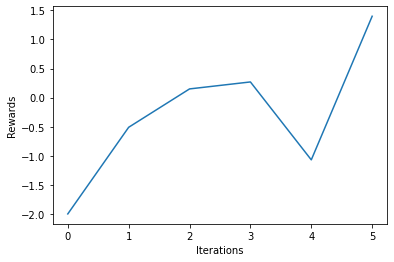

  1%|▍                                                                          | 604/100000 [00:37<1:49:03, 15.19it/s]

Updated Weights
Mean Reward = -1.95
20


  1%|▌                                                                          | 704/100000 [00:44<1:48:37, 15.23it/s]

Updated Weights
Mean Reward = 0.75
26


  1%|▌                                                                          | 802/100000 [00:50<1:48:24, 15.25it/s]

Updated Weights
Mean Reward = -1.61
17


  1%|▋                                                                          | 904/100000 [00:57<1:48:17, 15.25it/s]

Updated Weights
Mean Reward = -0.4
19


  1%|▋                                                                         | 1000/100000 [01:03<1:47:49, 15.30it/s]

Updated Weights
Mean Reward = 0.28
22


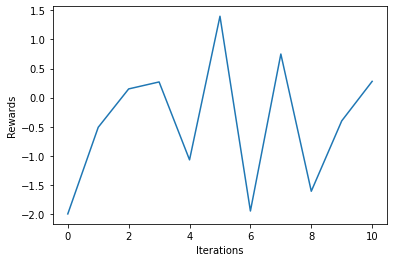

  1%|▊                                                                         | 1104/100000 [01:11<1:48:56, 15.13it/s]

Updated Weights
Mean Reward = -0.58
16


  1%|▉                                                                         | 1202/100000 [01:18<1:45:17, 15.64it/s]

Updated Weights
Mean Reward = -0.77
14


  1%|▉                                                                         | 1302/100000 [01:25<2:12:13, 12.44it/s]

Updated Weights
Mean Reward = -0.53
20


  1%|█                                                                         | 1404/100000 [01:32<1:45:12, 15.62it/s]

Updated Weights
Mean Reward = -1.2
16


  2%|█                                                                         | 1500/100000 [01:39<1:42:41, 15.99it/s]

Updated Weights
Mean Reward = 0.02
25


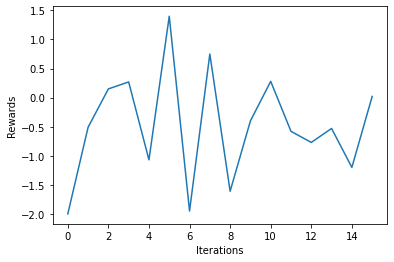

  2%|█▏                                                                        | 1602/100000 [01:45<1:48:41, 15.09it/s]

Updated Weights
Mean Reward = -0.22
23


  2%|█▎                                                                        | 1702/100000 [01:52<1:43:15, 15.87it/s]

Updated Weights
Mean Reward = -1.7
14


  2%|█▎                                                                        | 1804/100000 [01:58<1:39:34, 16.44it/s]

Updated Weights
Mean Reward = -0.92
21


  2%|█▍                                                                        | 1904/100000 [02:04<1:44:16, 15.68it/s]

Updated Weights
Mean Reward = 0.31
25


  2%|█▍                                                                        | 2000/100000 [02:10<1:39:34, 16.40it/s]

Updated Weights
Mean Reward = -0.08
23


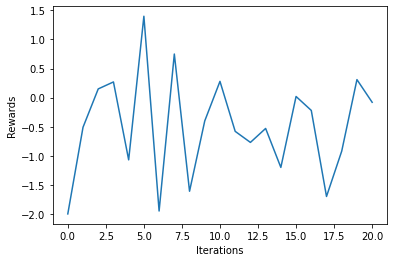

  2%|█▌                                                                        | 2104/100000 [02:17<1:41:10, 16.13it/s]

Updated Weights
Mean Reward = -1.32
20


  2%|█▋                                                                        | 2204/100000 [02:23<1:39:13, 16.43it/s]

Updated Weights
Mean Reward = 0.29
25


  2%|█▋                                                                        | 2302/100000 [02:29<1:42:14, 15.93it/s]

Updated Weights
Mean Reward = -0.93
21


  2%|█▊                                                                        | 2404/100000 [02:36<1:40:45, 16.14it/s]

Updated Weights
Mean Reward = -1.69
19


  2%|█▊                                                                        | 2500/100000 [02:42<1:42:19, 15.88it/s]

Updated Weights
Mean Reward = 0.42
18


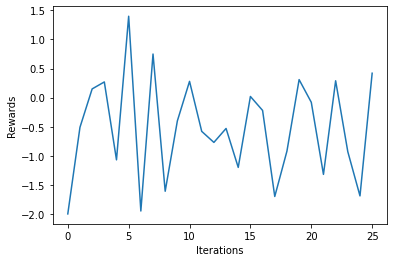

  3%|█▉                                                                        | 2602/100000 [02:53<2:57:51,  9.13it/s]

Updated Weights
Mean Reward = 2.22
27


  3%|█▉                                                                        | 2702/100000 [03:05<3:57:10,  6.84it/s]

Updated Weights
Mean Reward = 0.32
18


  3%|██                                                                        | 2802/100000 [03:17<3:46:12,  7.16it/s]

Updated Weights
Mean Reward = 1.22
22


  3%|██▏                                                                       | 2902/100000 [03:29<3:18:37,  8.15it/s]

Updated Weights
Mean Reward = 2.63
30


  3%|██▏                                                                       | 3000/100000 [03:39<3:11:52,  8.43it/s]

Updated Weights
Mean Reward = 1.87
26


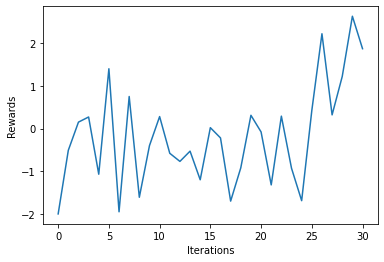

  3%|██▎                                                                       | 3102/100000 [03:52<3:43:46,  7.22it/s]

Updated Weights
Mean Reward = 1.49
25


  3%|██▎                                                                       | 3203/100000 [04:04<3:36:20,  7.46it/s]

Updated Weights
Mean Reward = 2.47
28


  3%|██▍                                                                       | 3301/100000 [04:17<3:32:21,  7.59it/s]

Updated Weights
Mean Reward = 1.25
26


  3%|██▌                                                                       | 3402/100000 [04:30<3:42:48,  7.23it/s]

Updated Weights
Mean Reward = 0.61
24


  4%|██▌                                                                       | 3500/100000 [04:43<3:22:51,  7.93it/s]

Updated Weights
Mean Reward = -0.04
22


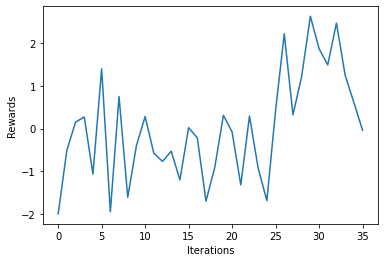

  4%|██▋                                                                       | 3602/100000 [04:57<3:28:35,  7.70it/s]

Updated Weights
Mean Reward = 0.29
21


  4%|██▋                                                                       | 3702/100000 [05:10<3:17:18,  8.13it/s]

Updated Weights
Mean Reward = 0.94
22


  4%|██▊                                                                       | 3801/100000 [05:24<3:23:15,  7.89it/s]

Updated Weights
Mean Reward = -0.69
20


  4%|██▉                                                                       | 3902/100000 [05:37<3:17:29,  8.11it/s]

Updated Weights
Mean Reward = -1.03
21


  4%|██▉                                                                       | 4000/100000 [05:50<3:14:50,  8.21it/s]

Updated Weights
Mean Reward = 1.25
25


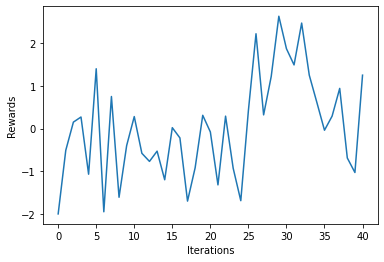

  4%|███                                                                       | 4102/100000 [06:04<3:46:12,  7.07it/s]

Updated Weights
Mean Reward = 1.15
26


  4%|███                                                                       | 4202/100000 [06:18<3:58:11,  6.70it/s]

Updated Weights
Mean Reward = 1.48
20


  4%|███▏                                                                      | 4302/100000 [06:32<3:53:16,  6.84it/s]

Updated Weights
Mean Reward = 0.57
17


  4%|███▎                                                                      | 4402/100000 [06:45<3:29:20,  7.61it/s]

Updated Weights
Mean Reward = 0.78
20


  4%|███▎                                                                      | 4499/100000 [06:58<3:32:56,  7.47it/s]

Updated Weights
Mean Reward = 2.16
28


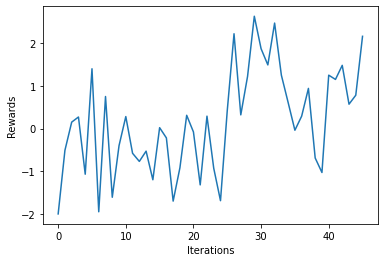

  5%|███▍                                                                      | 4602/100000 [07:12<3:14:31,  8.17it/s]

Updated Weights
Mean Reward = -0.52
18


  5%|███▍                                                                      | 4702/100000 [07:25<3:37:52,  7.29it/s]

Updated Weights
Mean Reward = -0.33
19


  5%|███▌                                                                      | 4802/100000 [07:38<3:40:20,  7.20it/s]

Updated Weights
Mean Reward = 1.34
21


  5%|███▋                                                                      | 4902/100000 [07:51<3:20:55,  7.89it/s]

Updated Weights
Mean Reward = 2.23
34


  5%|███▋                                                                      | 5000/100000 [08:02<3:17:36,  8.01it/s]

Updated Weights
Mean Reward = -0.23
16


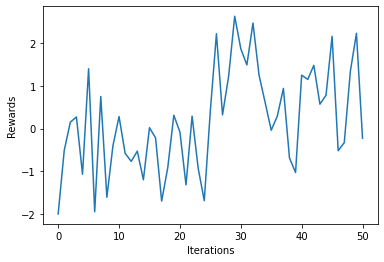

  5%|███▊                                                                      | 5102/100000 [08:17<3:34:15,  7.38it/s]

Updated Weights
Mean Reward = 1.79
21


  5%|███▊                                                                      | 5202/100000 [08:32<4:43:53,  5.57it/s]

Updated Weights
Mean Reward = 2.0
24


  5%|███▉                                                                      | 5302/100000 [08:48<4:10:25,  6.30it/s]

Updated Weights
Mean Reward = 0.95
19


  5%|███▉                                                                      | 5402/100000 [09:02<4:03:39,  6.47it/s]

Updated Weights
Mean Reward = 2.44
30


  6%|████                                                                      | 5500/100000 [09:15<4:29:16,  5.85it/s]

Updated Weights
Mean Reward = 2.14
24


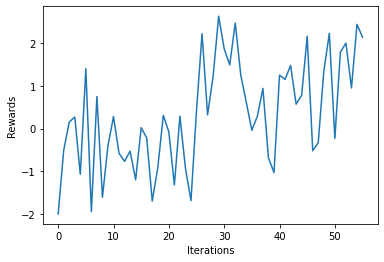

  6%|████▏                                                                     | 5602/100000 [09:30<3:59:24,  6.57it/s]

Updated Weights
Mean Reward = 1.53
31


  6%|████▏                                                                     | 5702/100000 [09:44<4:07:30,  6.35it/s]

Updated Weights
Mean Reward = 0.38
15


  6%|████▎                                                                     | 5802/100000 [09:59<4:40:53,  5.59it/s]

Updated Weights
Mean Reward = 0.78
21


  6%|████▎                                                                     | 5902/100000 [10:14<4:28:00,  5.85it/s]

Updated Weights
Mean Reward = -0.01
16


  6%|████▍                                                                     | 6000/100000 [10:28<3:20:29,  7.81it/s]

Updated Weights
Mean Reward = 1.06
17


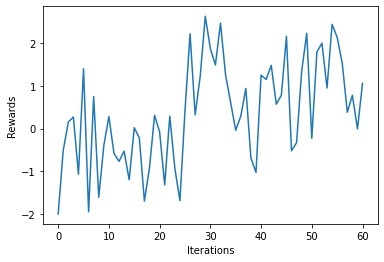

  6%|████▌                                                                     | 6102/100000 [10:43<4:35:23,  5.68it/s]

Updated Weights
Mean Reward = 1.06
22


  6%|████▌                                                                     | 6202/100000 [10:58<4:07:53,  6.31it/s]

Updated Weights
Mean Reward = 0.96
20


  6%|████▋                                                                     | 6302/100000 [11:12<4:26:38,  5.86it/s]

Updated Weights
Mean Reward = 2.74
27


  6%|████▋                                                                     | 6401/100000 [11:26<3:49:21,  6.80it/s]

Updated Weights
Mean Reward = 0.13
19


  6%|████▊                                                                     | 6500/100000 [11:40<4:01:16,  6.46it/s]

Updated Weights
Mean Reward = 1.5
19


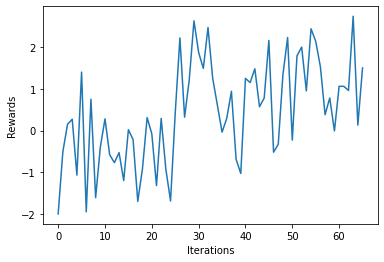

  7%|████▉                                                                     | 6602/100000 [11:54<3:51:34,  6.72it/s]

Updated Weights
Mean Reward = 0.61
24


  7%|████▉                                                                     | 6702/100000 [12:09<3:36:43,  7.17it/s]

Updated Weights
Mean Reward = 2.32
24


  7%|█████                                                                     | 6802/100000 [12:23<4:02:16,  6.41it/s]

Updated Weights
Mean Reward = 1.49
26


  7%|█████                                                                     | 6902/100000 [12:37<3:33:43,  7.26it/s]

Updated Weights
Mean Reward = 2.26
24


  7%|█████▏                                                                    | 7000/100000 [12:51<4:03:38,  6.36it/s]

Updated Weights
Mean Reward = 0.93
16


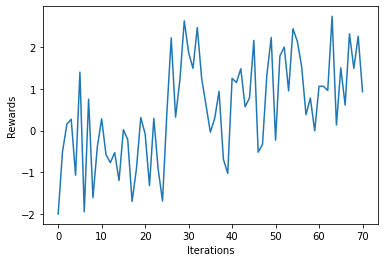

  7%|█████▎                                                                    | 7102/100000 [13:05<3:52:27,  6.66it/s]

Updated Weights
Mean Reward = 0.9
20


  7%|█████▎                                                                    | 7202/100000 [13:19<3:28:55,  7.40it/s]

Updated Weights
Mean Reward = 1.95
23


  7%|█████▍                                                                    | 7302/100000 [13:34<4:13:05,  6.10it/s]

Updated Weights
Mean Reward = 1.8
26


  7%|█████▍                                                                    | 7401/100000 [13:50<3:57:58,  6.49it/s]

Updated Weights
Mean Reward = 1.41
24


  8%|█████▌                                                                    | 7500/100000 [14:07<4:28:30,  5.74it/s]

Updated Weights
Mean Reward = 2.35
27


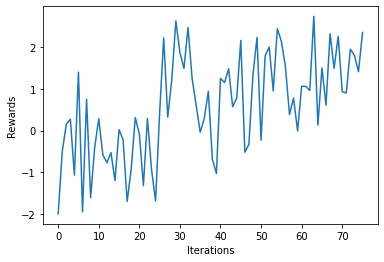

  8%|█████▌                                                                    | 7601/100000 [14:29<6:17:10,  4.08it/s]

Updated Weights
Mean Reward = 1.97
29


  8%|█████▋                                                                    | 7701/100000 [14:52<4:58:17,  5.16it/s]

Updated Weights
Mean Reward = 2.27
23


  8%|█████▊                                                                    | 7801/100000 [15:13<5:14:06,  4.89it/s]

Updated Weights
Mean Reward = 1.66
23


  8%|█████▊                                                                    | 7901/100000 [15:35<4:45:48,  5.37it/s]

Updated Weights
Mean Reward = 2.03
28


  8%|█████▉                                                                    | 8000/100000 [15:57<5:29:39,  4.65it/s]

Updated Weights
Mean Reward = 2.33
25


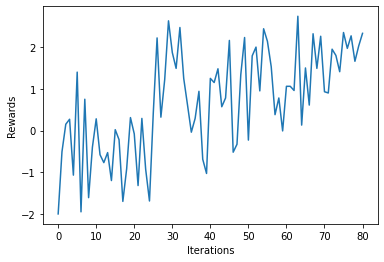

  8%|█████▉                                                                    | 8101/100000 [16:19<5:56:00,  4.30it/s]

Updated Weights
Mean Reward = 2.32
32


  8%|██████                                                                    | 8201/100000 [16:41<5:31:46,  4.61it/s]

Updated Weights
Mean Reward = 1.01
18


  8%|██████▏                                                                   | 8301/100000 [17:03<5:44:20,  4.44it/s]

Updated Weights
Mean Reward = 1.91
25


  8%|██████▏                                                                   | 8401/100000 [17:23<4:57:17,  5.14it/s]

Updated Weights
Mean Reward = 2.36
28


  8%|██████▎                                                                   | 8500/100000 [17:43<5:37:50,  4.51it/s]

Updated Weights
Mean Reward = 1.29
25


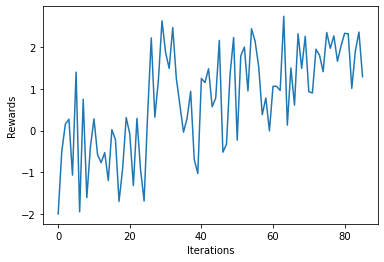

  9%|██████▎                                                                   | 8602/100000 [18:03<4:46:59,  5.31it/s]

Updated Weights
Mean Reward = 2.17
23


  9%|██████▍                                                                   | 8700/100000 [18:20<4:07:40,  6.14it/s]

Updated Weights
Mean Reward = 1.81
30


  9%|██████▌                                                                   | 8802/100000 [18:37<4:11:39,  6.04it/s]

Updated Weights
Mean Reward = 1.3
26


  9%|██████▌                                                                   | 8902/100000 [18:55<4:12:36,  6.01it/s]

Updated Weights
Mean Reward = 4.18
34


  9%|██████▋                                                                   | 9000/100000 [19:11<4:51:10,  5.21it/s]

Updated Weights
Mean Reward = 4.88
38


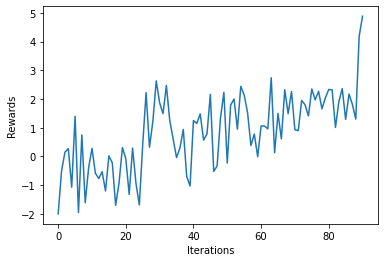

  9%|██████▋                                                                   | 9102/100000 [19:28<3:46:34,  6.69it/s]

Updated Weights
Mean Reward = 3.48
34


  9%|██████▊                                                                   | 9201/100000 [19:46<5:16:27,  4.78it/s]

Updated Weights
Mean Reward = 1.15
23


  9%|██████▉                                                                   | 9302/100000 [20:04<4:30:04,  5.60it/s]

Updated Weights
Mean Reward = 5.68
38


  9%|██████▉                                                                   | 9402/100000 [20:23<4:56:32,  5.09it/s]

Updated Weights
Mean Reward = 4.06
30


 10%|███████                                                                   | 9500/100000 [20:40<4:22:01,  5.76it/s]

Updated Weights
Mean Reward = 2.9
27


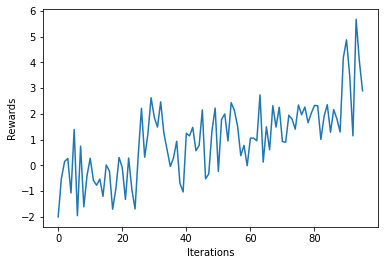

 10%|███████                                                                   | 9602/100000 [20:58<4:00:24,  6.27it/s]

Updated Weights
Mean Reward = 1.64
33


 10%|███████▏                                                                  | 9702/100000 [21:17<5:49:50,  4.30it/s]

Updated Weights
Mean Reward = 2.78
37


 10%|███████▎                                                                  | 9801/100000 [21:39<7:32:13,  3.32it/s]

Updated Weights
Mean Reward = 4.41
32


 10%|███████▎                                                                  | 9901/100000 [21:59<4:17:58,  5.82it/s]

Updated Weights
Mean Reward = 3.06
33


 10%|███████▎                                                                 | 10000/100000 [22:19<4:51:55,  5.14it/s]

Updated Weights
Mean Reward = 1.74
28


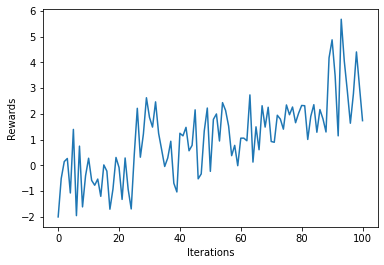

 10%|███████▎                                                                 | 10101/100000 [22:47<7:42:43,  3.24it/s]

Updated Weights
Mean Reward = 0.17
31


 10%|███████▍                                                                 | 10201/100000 [23:08<6:37:24,  3.77it/s]

Updated Weights
Mean Reward = 5.76
36


 10%|███████▌                                                                 | 10302/100000 [23:28<4:46:07,  5.22it/s]

Updated Weights
Mean Reward = 4.85
36


 10%|███████▌                                                                 | 10401/100000 [23:51<6:45:41,  3.68it/s]

Updated Weights
Mean Reward = 5.73
28


 10%|███████▋                                                                 | 10500/100000 [24:15<5:56:57,  4.18it/s]

Updated Weights
Mean Reward = 2.33
30


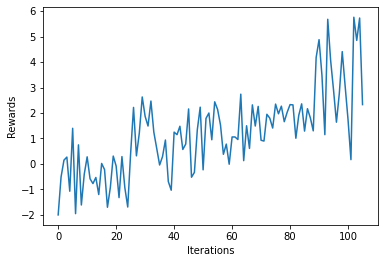

 11%|███████▋                                                                 | 10601/100000 [24:41<7:42:08,  3.22it/s]

Updated Weights
Mean Reward = 1.56
31


 11%|███████▊                                                                 | 10701/100000 [25:05<6:23:03,  3.89it/s]

Updated Weights
Mean Reward = 2.89
32


 11%|███████▉                                                                 | 10801/100000 [25:30<6:28:28,  3.83it/s]

Updated Weights
Mean Reward = 0.69
26


 11%|███████▉                                                                 | 10900/100000 [25:56<5:58:07,  4.15it/s]

Updated Weights
Mean Reward = 2.33
26


 11%|████████                                                                 | 11000/100000 [26:22<6:24:28,  3.86it/s]

Updated Weights
Mean Reward = -1.71
20


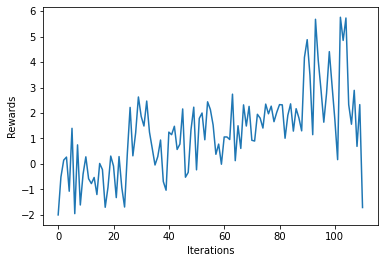

 11%|████████                                                                 | 11101/100000 [26:47<5:31:36,  4.47it/s]

Updated Weights
Mean Reward = 3.21
25


 11%|████████▏                                                                | 11201/100000 [27:17<7:11:15,  3.43it/s]

Updated Weights
Mean Reward = 3.93
30


 11%|████████▏                                                                | 11301/100000 [27:42<5:50:55,  4.21it/s]

Updated Weights
Mean Reward = 6.91
39


 11%|████████▎                                                                | 11401/100000 [28:06<4:51:08,  5.07it/s]

Updated Weights
Mean Reward = 4.61
38


 12%|████████▍                                                                | 11500/100000 [28:25<5:49:58,  4.21it/s]

Updated Weights
Mean Reward = 2.29
37


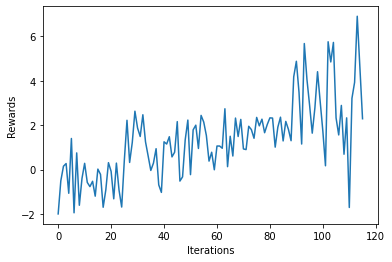

 12%|████████▍                                                                | 11601/100000 [28:47<5:51:41,  4.19it/s]

Updated Weights
Mean Reward = 3.04
31


 12%|████████▌                                                                | 11701/100000 [29:07<5:24:31,  4.53it/s]

Updated Weights
Mean Reward = 3.81
22


 12%|████████▌                                                                | 11801/100000 [29:29<5:07:12,  4.78it/s]

Updated Weights
Mean Reward = -0.75
18


 12%|████████▋                                                                | 11901/100000 [29:51<5:41:22,  4.30it/s]

Updated Weights
Mean Reward = 4.08
31


 12%|████████▊                                                                | 12000/100000 [30:12<4:38:27,  5.27it/s]

Updated Weights
Mean Reward = 4.51
35


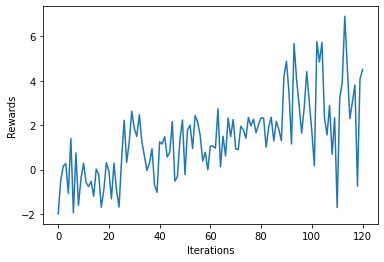

 12%|████████▊                                                                | 12101/100000 [30:35<6:02:26,  4.04it/s]

Updated Weights
Mean Reward = 2.09
29


 12%|████████▉                                                                | 12202/100000 [31:00<6:12:49,  3.92it/s]

Updated Weights
Mean Reward = 2.28
28


 12%|████████▉                                                                | 12302/100000 [31:24<4:58:52,  4.89it/s]

Updated Weights
Mean Reward = 5.14
36


 12%|█████████                                                                | 12401/100000 [31:46<4:22:30,  5.56it/s]

Updated Weights
Mean Reward = 4.44
34


 12%|█████████▏                                                               | 12500/100000 [32:07<5:03:55,  4.80it/s]

Updated Weights
Mean Reward = 4.55
32


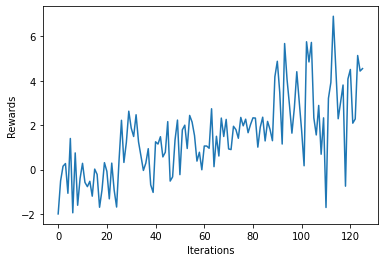

 13%|█████████▏                                                               | 12601/100000 [32:31<5:30:43,  4.40it/s]

Updated Weights
Mean Reward = 6.01
41


 13%|█████████▎                                                               | 12701/100000 [32:55<6:02:46,  4.01it/s]

Updated Weights
Mean Reward = 3.11
33


 13%|█████████▎                                                               | 12801/100000 [33:19<7:27:17,  3.25it/s]

Updated Weights
Mean Reward = 4.34
36


 13%|█████████▍                                                               | 12901/100000 [33:44<7:38:47,  3.16it/s]

Updated Weights
Mean Reward = 3.69
31


 13%|█████████▍                                                               | 13000/100000 [34:14<8:33:05,  2.83it/s]

Updated Weights
Mean Reward = 3.23
24


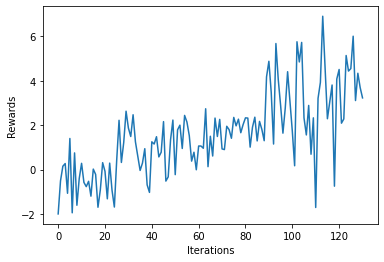

 13%|█████████▌                                                               | 13101/100000 [34:44<7:48:22,  3.09it/s]

Updated Weights
Mean Reward = 1.47
30


 13%|█████████▋                                                               | 13201/100000 [35:15<7:35:13,  3.18it/s]

Updated Weights
Mean Reward = 1.71
28


 13%|█████████▋                                                               | 13301/100000 [35:47<7:16:18,  3.31it/s]

Updated Weights
Mean Reward = 0.53
22


 13%|█████████▊                                                               | 13401/100000 [36:17<7:17:26,  3.30it/s]

Updated Weights
Mean Reward = 5.74
33


 14%|█████████▊                                                               | 13500/100000 [36:47<7:03:55,  3.40it/s]

Updated Weights
Mean Reward = 5.81
40


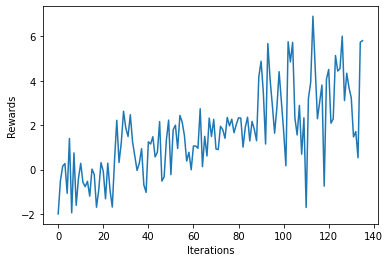

 14%|█████████▉                                                               | 13601/100000 [37:13<7:31:07,  3.19it/s]

Updated Weights
Mean Reward = 6.11
44


 14%|██████████                                                               | 13702/100000 [37:40<5:29:14,  4.37it/s]

Updated Weights
Mean Reward = 5.38
35


 14%|██████████                                                               | 13801/100000 [38:04<4:53:45,  4.89it/s]

Updated Weights
Mean Reward = 4.54
33


 14%|██████████▏                                                              | 13901/100000 [38:25<4:19:10,  5.54it/s]

Updated Weights
Mean Reward = 5.05
27


 14%|██████████▏                                                              | 14000/100000 [38:46<4:41:28,  5.09it/s]

Updated Weights
Mean Reward = 2.53
30


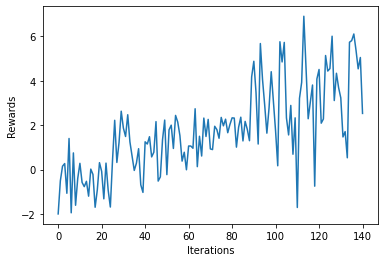

 14%|██████████▎                                                              | 14101/100000 [39:08<4:35:43,  5.19it/s]

Updated Weights
Mean Reward = 6.17
37


 14%|██████████▎                                                              | 14202/100000 [39:28<5:01:15,  4.75it/s]

Updated Weights
Mean Reward = 5.59
42


 14%|██████████▍                                                              | 14301/100000 [39:49<4:51:00,  4.91it/s]

Updated Weights
Mean Reward = 2.79
31


 14%|██████████▌                                                              | 14401/100000 [40:12<5:28:30,  4.34it/s]

Updated Weights
Mean Reward = 2.29
32


 14%|██████████▌                                                              | 14499/100000 [40:35<6:08:13,  3.87it/s]

Updated Weights
Mean Reward = 1.09
28


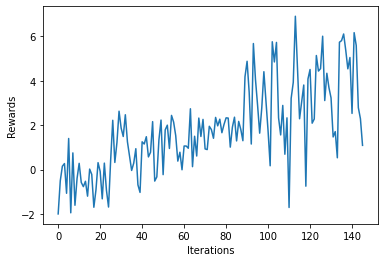

 15%|██████████▋                                                              | 14602/100000 [40:59<5:06:16,  4.65it/s]

Updated Weights
Mean Reward = 1.02
28


 15%|██████████▋                                                              | 14702/100000 [41:20<5:40:16,  4.18it/s]

Updated Weights
Mean Reward = 5.05
37


 15%|██████████▊                                                              | 14801/100000 [41:45<5:55:16,  4.00it/s]

Updated Weights
Mean Reward = 5.12
31


 15%|██████████▉                                                              | 14900/100000 [42:07<4:49:56,  4.89it/s]

Updated Weights
Mean Reward = 4.95
31


 15%|██████████▉                                                              | 15000/100000 [42:29<5:38:11,  4.19it/s]

Updated Weights
Mean Reward = 3.81
27


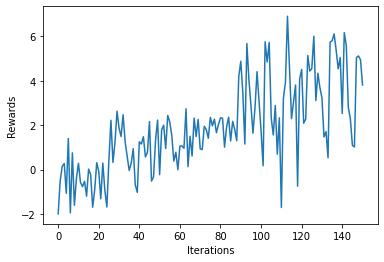

 15%|███████████                                                              | 15101/100000 [42:55<5:38:35,  4.18it/s]

Updated Weights
Mean Reward = 5.07
44


 15%|███████████                                                              | 15201/100000 [43:24<7:07:23,  3.31it/s]

Updated Weights
Mean Reward = 3.07
21


 15%|███████████▏                                                             | 15301/100000 [43:57<7:27:47,  3.15it/s]

Updated Weights
Mean Reward = 1.47
35


 15%|███████████▏                                                             | 15401/100000 [44:33<6:44:12,  3.49it/s]

Updated Weights
Mean Reward = 0.98
28


 16%|███████████▎                                                             | 15500/100000 [45:08<8:25:58,  2.78it/s]

Updated Weights
Mean Reward = 1.16
39


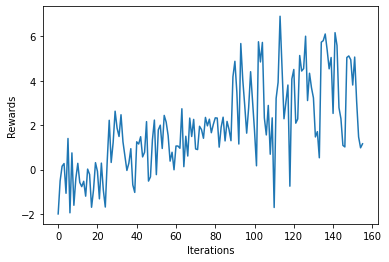

 16%|███████████▍                                                             | 15601/100000 [45:41<7:13:38,  3.24it/s]

Updated Weights
Mean Reward = 1.37
28


 16%|███████████▍                                                             | 15701/100000 [46:14<5:44:35,  4.08it/s]

Updated Weights
Mean Reward = 2.11
23


 16%|███████████▌                                                             | 15802/100000 [46:44<6:13:04,  3.76it/s]

Updated Weights
Mean Reward = 7.62
36


 16%|███████████▌                                                             | 15901/100000 [47:14<7:17:23,  3.20it/s]

Updated Weights
Mean Reward = 5.12
32


 16%|███████████▋                                                             | 16000/100000 [47:47<6:15:54,  3.72it/s]

Updated Weights
Mean Reward = 2.48
26


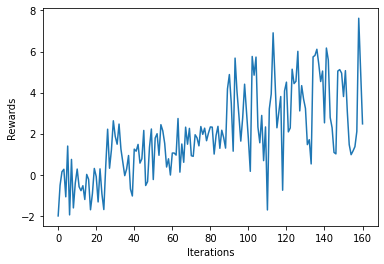

 16%|███████████▊                                                             | 16101/100000 [48:16<5:53:35,  3.95it/s]

Updated Weights
Mean Reward = 4.83
47


 16%|███████████▊                                                             | 16201/100000 [48:45<6:05:43,  3.82it/s]

Updated Weights
Mean Reward = 6.27
34


 16%|███████████▉                                                             | 16301/100000 [49:13<5:11:25,  4.48it/s]

Updated Weights
Mean Reward = 5.1
34


 16%|███████████▉                                                             | 16401/100000 [49:41<5:46:25,  4.02it/s]

Updated Weights
Mean Reward = 3.67
24


 16%|████████████                                                             | 16500/100000 [50:06<6:10:00,  3.76it/s]

Updated Weights
Mean Reward = 7.66
43


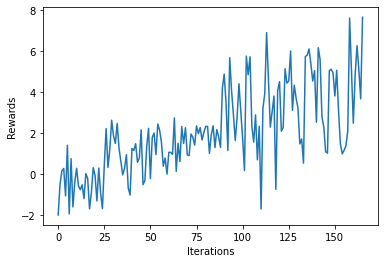

 17%|████████████                                                             | 16601/100000 [50:33<6:06:03,  3.80it/s]

Updated Weights
Mean Reward = 6.04
30


 17%|████████████▏                                                            | 16701/100000 [51:00<5:32:39,  4.17it/s]

Updated Weights
Mean Reward = 5.92
31


 17%|████████████▎                                                            | 16801/100000 [51:27<6:28:23,  3.57it/s]

Updated Weights
Mean Reward = 6.99
35


 17%|████████████▎                                                            | 16901/100000 [51:54<6:50:24,  3.37it/s]

Updated Weights
Mean Reward = 4.71
41


 17%|████████████▍                                                            | 17000/100000 [52:19<6:15:31,  3.68it/s]

Updated Weights
Mean Reward = 3.55
41


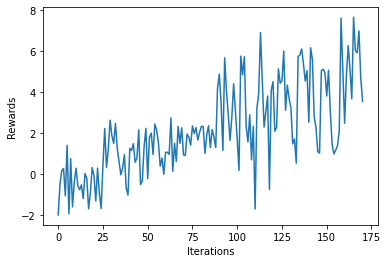

 17%|████████████▍                                                            | 17101/100000 [52:42<4:45:23,  4.84it/s]

Updated Weights
Mean Reward = 4.96
48


 17%|████████████▌                                                            | 17201/100000 [53:04<5:55:07,  3.89it/s]

Updated Weights
Mean Reward = 7.04
43


 17%|████████████▋                                                            | 17301/100000 [53:29<4:55:08,  4.67it/s]

Updated Weights
Mean Reward = 4.85
43


 17%|████████████▋                                                            | 17402/100000 [53:59<5:54:54,  3.88it/s]

Updated Weights
Mean Reward = 4.25
34


 18%|████████████▊                                                            | 17500/100000 [54:30<7:44:07,  2.96it/s]

Updated Weights
Mean Reward = 2.79
37


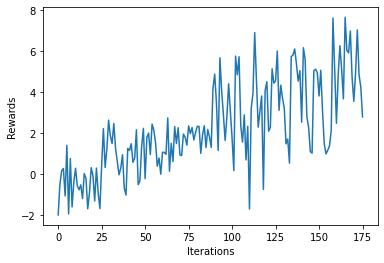

 18%|████████████▊                                                            | 17602/100000 [55:06<6:36:00,  3.47it/s]

Updated Weights
Mean Reward = 3.78
40


 18%|████████████▉                                                            | 17701/100000 [55:42<8:32:26,  2.68it/s]

Updated Weights
Mean Reward = 0.26
28


 18%|████████████▉                                                            | 17801/100000 [56:17<7:47:26,  2.93it/s]

Updated Weights
Mean Reward = 3.34
36


 18%|█████████████                                                            | 17901/100000 [56:52<8:11:13,  2.79it/s]

Updated Weights
Mean Reward = 4.14
35


 18%|█████████████▏                                                           | 17999/100000 [57:23<7:40:33,  2.97it/s]

Updated Weights
Mean Reward = 5.13
44


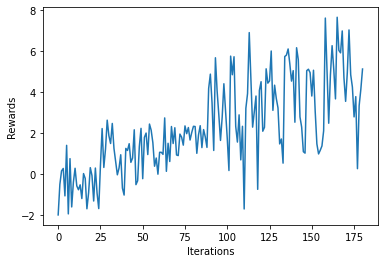

 18%|█████████████▏                                                           | 18101/100000 [57:58<7:18:50,  3.11it/s]

Updated Weights
Mean Reward = 6.02
38


 18%|█████████████▎                                                           | 18201/100000 [58:27<6:02:56,  3.76it/s]

Updated Weights
Mean Reward = 5.42
29


 18%|█████████████▎                                                           | 18301/100000 [58:57<5:57:24,  3.81it/s]

Updated Weights
Mean Reward = 2.65
36


 18%|█████████████▍                                                           | 18401/100000 [59:29<5:53:26,  3.85it/s]

Updated Weights
Mean Reward = 3.14
31


 18%|█████████████▌                                                           | 18499/100000 [59:55<5:06:46,  4.43it/s]

Updated Weights
Mean Reward = 5.07
38


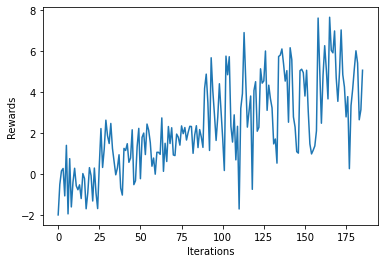

 19%|█████████████▏                                                         | 18601/100000 [1:00:21<5:11:13,  4.36it/s]

Updated Weights
Mean Reward = 4.76
44


 19%|█████████████▎                                                         | 18701/100000 [1:00:47<5:33:05,  4.07it/s]

Updated Weights
Mean Reward = 4.01
35


 19%|█████████████▎                                                         | 18801/100000 [1:01:11<4:49:13,  4.68it/s]

Updated Weights
Mean Reward = 1.05
31


 19%|█████████████▍                                                         | 18901/100000 [1:01:39<7:46:11,  2.90it/s]

Updated Weights
Mean Reward = 3.88
34


 19%|█████████████▍                                                         | 19000/100000 [1:02:06<4:43:16,  4.77it/s]

Updated Weights
Mean Reward = 8.74
46


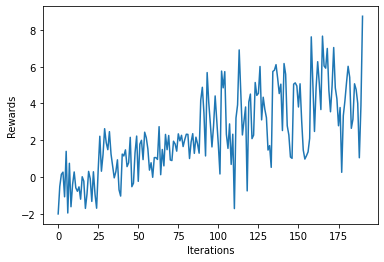

 19%|█████████████▌                                                         | 19102/100000 [1:02:33<4:44:40,  4.74it/s]

Updated Weights
Mean Reward = 6.52
37


 19%|█████████████▋                                                         | 19202/100000 [1:03:01<4:44:57,  4.73it/s]

Updated Weights
Mean Reward = 6.75
46


 19%|█████████████▋                                                         | 19302/100000 [1:03:30<6:26:49,  3.48it/s]

Updated Weights
Mean Reward = 7.32
46


 19%|█████████████▊                                                         | 19401/100000 [1:04:02<9:13:03,  2.43it/s]

Updated Weights
Mean Reward = 3.7
35


 20%|█████████████▊                                                         | 19500/100000 [1:04:37<7:10:59,  3.11it/s]

Updated Weights
Mean Reward = 6.05
34


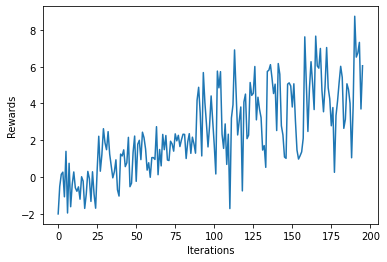

 20%|█████████████▉                                                         | 19601/100000 [1:05:15<7:11:11,  3.11it/s]

Updated Weights
Mean Reward = 3.07
35


 20%|█████████████▉                                                         | 19701/100000 [1:05:48<6:31:29,  3.42it/s]

Updated Weights
Mean Reward = 8.54
40


 20%|██████████████                                                         | 19801/100000 [1:06:19<6:11:13,  3.60it/s]

Updated Weights
Mean Reward = 7.03
42


 20%|██████████████▏                                                        | 19901/100000 [1:06:55<8:49:04,  2.52it/s]

Updated Weights
Mean Reward = 6.78
45


 20%|██████████████▏                                                        | 20000/100000 [1:07:29<8:13:28,  2.70it/s]

Updated Weights
Mean Reward = 0.74
37


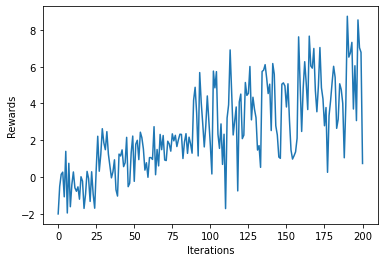

 20%|██████████████▎                                                        | 20101/100000 [1:08:06<8:46:40,  2.53it/s]

Updated Weights
Mean Reward = 4.18
38


 20%|██████████████▎                                                        | 20201/100000 [1:08:36<6:00:48,  3.69it/s]

Updated Weights
Mean Reward = 3.37
38


 20%|██████████████▍                                                        | 20301/100000 [1:09:06<7:01:33,  3.15it/s]

Updated Weights
Mean Reward = 7.09
39


 20%|██████████████▍                                                        | 20401/100000 [1:09:36<7:31:02,  2.94it/s]

Updated Weights
Mean Reward = 6.53
34


 20%|██████████████▌                                                        | 20500/100000 [1:10:03<7:38:05,  2.89it/s]

Updated Weights
Mean Reward = 7.92
45


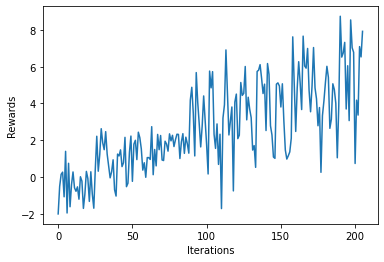

 21%|██████████████▋                                                        | 20601/100000 [1:10:33<6:08:10,  3.59it/s]

Updated Weights
Mean Reward = 9.21
40


 21%|██████████████▋                                                        | 20702/100000 [1:11:04<5:49:25,  3.78it/s]

Updated Weights
Mean Reward = 0.9
31


 21%|██████████████▊                                                        | 20801/100000 [1:11:36<6:45:57,  3.25it/s]

Updated Weights
Mean Reward = -0.31
26


 21%|██████████████▊                                                        | 20901/100000 [1:12:08<7:30:34,  2.93it/s]

Updated Weights
Mean Reward = 5.18
27


 21%|██████████████▉                                                        | 21000/100000 [1:12:41<8:49:11,  2.49it/s]

Updated Weights
Mean Reward = 3.56
25


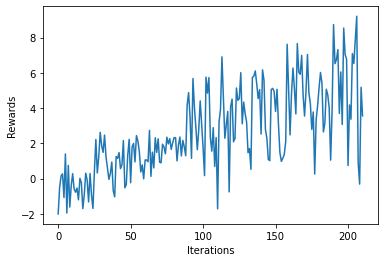

 21%|██████████████▉                                                        | 21102/100000 [1:13:09<5:21:26,  4.09it/s]

Updated Weights
Mean Reward = 9.4
33


 21%|███████████████                                                        | 21201/100000 [1:13:36<5:28:36,  4.00it/s]

Updated Weights
Mean Reward = 7.15
38


 21%|███████████████                                                        | 21301/100000 [1:14:08<6:22:55,  3.43it/s]

Updated Weights
Mean Reward = 4.68
36


 21%|███████████████▏                                                       | 21402/100000 [1:14:41<5:16:03,  4.14it/s]

Updated Weights
Mean Reward = 6.55
43


 21%|███████████████▎                                                       | 21499/100000 [1:15:15<7:46:41,  2.80it/s]

Updated Weights
Mean Reward = 3.18
28


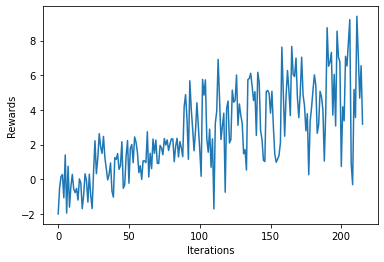

 22%|███████████████▎                                                       | 21602/100000 [1:15:50<5:15:53,  4.14it/s]

Updated Weights
Mean Reward = 7.71
37


 22%|███████████████▍                                                       | 21701/100000 [1:16:21<5:45:54,  3.77it/s]

Updated Weights
Mean Reward = 8.0
47


 22%|███████████████▍                                                       | 21802/100000 [1:16:55<5:51:51,  3.70it/s]

Updated Weights
Mean Reward = 4.94
35


 22%|███████████████▌                                                       | 21902/100000 [1:17:27<6:22:23,  3.40it/s]

Updated Weights
Mean Reward = 7.42
40


 22%|███████████████▌                                                       | 22000/100000 [1:17:57<4:36:52,  4.70it/s]

Updated Weights
Mean Reward = 6.01
43


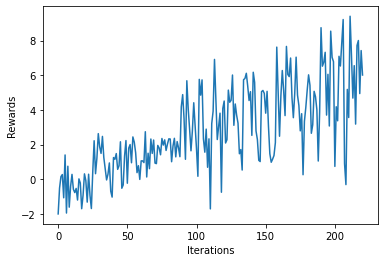

 22%|███████████████▋                                                       | 22101/100000 [1:18:23<6:13:16,  3.48it/s]

Updated Weights
Mean Reward = 8.89
36


 22%|███████████████▊                                                       | 22201/100000 [1:18:48<4:30:38,  4.79it/s]

Updated Weights
Mean Reward = 7.1
45


 22%|███████████████▊                                                       | 22301/100000 [1:19:17<6:13:27,  3.47it/s]

Updated Weights
Mean Reward = 7.81
35


 22%|███████████████▉                                                       | 22401/100000 [1:19:45<6:13:32,  3.46it/s]

Updated Weights
Mean Reward = 7.23
31


 22%|███████████████▉                                                       | 22500/100000 [1:20:12<5:46:02,  3.73it/s]

Updated Weights
Mean Reward = 3.21
25


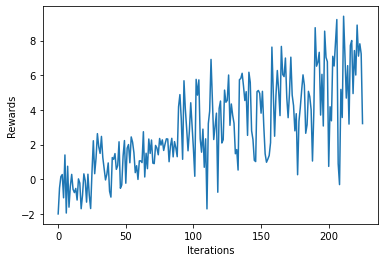

 23%|████████████████                                                       | 22601/100000 [1:20:42<5:53:30,  3.65it/s]

Updated Weights
Mean Reward = 3.87
28


 23%|████████████████                                                       | 22701/100000 [1:21:09<7:11:12,  2.99it/s]

Updated Weights
Mean Reward = 8.12
43


 23%|████████████████▏                                                      | 22801/100000 [1:21:40<6:55:17,  3.10it/s]

Updated Weights
Mean Reward = 6.46
40


 23%|████████████████▎                                                      | 22902/100000 [1:22:09<4:06:29,  5.21it/s]

Updated Weights
Mean Reward = 9.14
48


 23%|████████████████▎                                                      | 23000/100000 [1:22:38<7:59:57,  2.67it/s]

Updated Weights
Mean Reward = 6.42
45


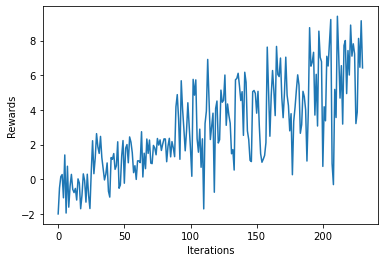

 23%|████████████████▍                                                      | 23101/100000 [1:23:07<3:38:21,  5.87it/s]

Updated Weights
Mean Reward = 11.29
44


 23%|████████████████▍                                                      | 23201/100000 [1:23:39<6:02:59,  3.53it/s]

Updated Weights
Mean Reward = 6.04
38


 23%|████████████████▎                                                     | 23301/100000 [1:24:22<10:53:00,  1.96it/s]

Updated Weights
Mean Reward = 0.93
25


 23%|████████████████▌                                                      | 23402/100000 [1:24:57<4:36:10,  4.62it/s]

Updated Weights
Mean Reward = 7.07
48


 24%|████████████████▍                                                     | 23500/100000 [1:25:38<10:00:44,  2.12it/s]

Updated Weights
Mean Reward = 2.41
31


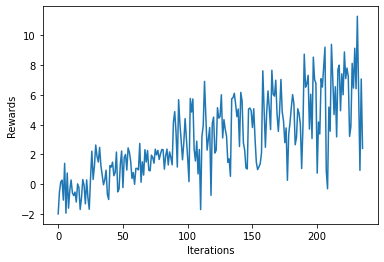

 24%|████████████████▊                                                      | 23602/100000 [1:26:19<6:26:54,  3.29it/s]

Updated Weights
Mean Reward = 6.78
43


 24%|████████████████▊                                                      | 23701/100000 [1:26:58<7:53:56,  2.68it/s]

Updated Weights
Mean Reward = 9.62
38


 24%|████████████████▉                                                      | 23802/100000 [1:27:38<7:00:19,  3.02it/s]

Updated Weights
Mean Reward = 10.71
36


 24%|████████████████▉                                                      | 23902/100000 [1:28:14<6:15:09,  3.38it/s]

Updated Weights
Mean Reward = 9.85
30


 24%|█████████████████                                                      | 24000/100000 [1:28:44<5:51:14,  3.61it/s]

Updated Weights
Mean Reward = 8.59
37


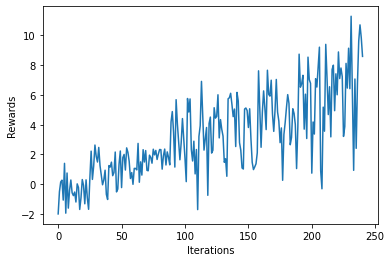

 24%|█████████████████                                                      | 24101/100000 [1:29:15<3:37:33,  5.81it/s]

Updated Weights
Mean Reward = 11.83
42


 24%|█████████████████▏                                                     | 24201/100000 [1:29:48<8:03:39,  2.61it/s]

Updated Weights
Mean Reward = 10.43
44


 24%|█████████████████▎                                                     | 24301/100000 [1:30:20<4:54:34,  4.28it/s]

Updated Weights
Mean Reward = 4.52
34


 24%|█████████████████▎                                                     | 24401/100000 [1:30:52<4:25:49,  4.74it/s]

Updated Weights
Mean Reward = 9.59
42


 24%|█████████████████▍                                                     | 24500/100000 [1:31:23<5:53:02,  3.56it/s]

Updated Weights
Mean Reward = 9.49
41


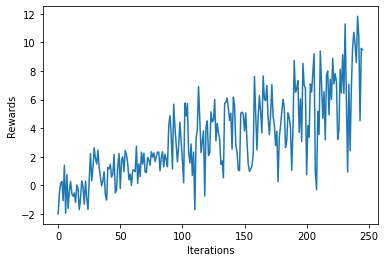

 25%|█████████████████▍                                                     | 24601/100000 [1:31:54<4:52:55,  4.29it/s]

Updated Weights
Mean Reward = 8.64
43


 25%|█████████████████▌                                                     | 24701/100000 [1:32:26<7:02:30,  2.97it/s]

Updated Weights
Mean Reward = 1.71
35


 25%|█████████████████▌                                                     | 24801/100000 [1:32:56<6:47:12,  3.08it/s]

Updated Weights
Mean Reward = 4.25
33


 25%|█████████████████▋                                                     | 24901/100000 [1:33:28<8:35:54,  2.43it/s]

Updated Weights
Mean Reward = 11.02
44


 25%|█████████████████▊                                                     | 25000/100000 [1:34:04<9:16:40,  2.25it/s]

Updated Weights
Mean Reward = 6.65
35


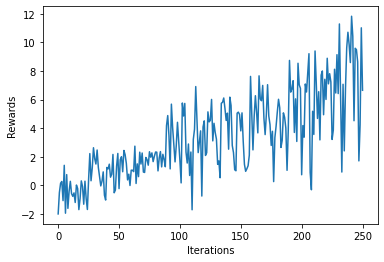

 25%|█████████████████▌                                                    | 25101/100000 [1:34:48<10:40:47,  1.95it/s]

Updated Weights
Mean Reward = 8.03
36


 25%|█████████████████▋                                                    | 25201/100000 [1:35:46<12:58:30,  1.60it/s]

Updated Weights
Mean Reward = 9.28
33


 25%|█████████████████▉                                                     | 25302/100000 [1:36:38<7:16:52,  2.85it/s]

Updated Weights
Mean Reward = 11.55
31


 25%|██████████████████                                                     | 25401/100000 [1:37:18<9:39:18,  2.15it/s]

Updated Weights
Mean Reward = 8.14
40


 26%|██████████████████                                                     | 25500/100000 [1:38:11<9:22:40,  2.21it/s]

Updated Weights
Mean Reward = 10.63
43


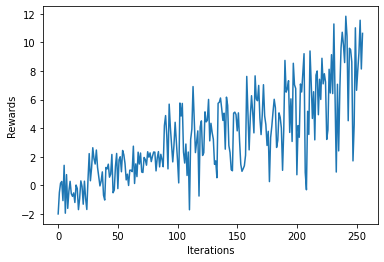

 26%|██████████████████▏                                                    | 25601/100000 [1:38:53<9:00:04,  2.30it/s]

Updated Weights
Mean Reward = 11.24
40


 26%|██████████████████▏                                                    | 25701/100000 [1:39:32<7:00:35,  2.94it/s]

Updated Weights
Mean Reward = 6.23
32


 26%|██████████████████▎                                                    | 25801/100000 [1:40:10<6:44:40,  3.06it/s]

Updated Weights
Mean Reward = 3.16
28


 26%|██████████████████▍                                                    | 25901/100000 [1:40:48<7:24:19,  2.78it/s]

Updated Weights
Mean Reward = 1.97
27


 26%|██████████████████▍                                                    | 26000/100000 [1:41:24<6:55:41,  2.97it/s]

Updated Weights
Mean Reward = -0.58
19


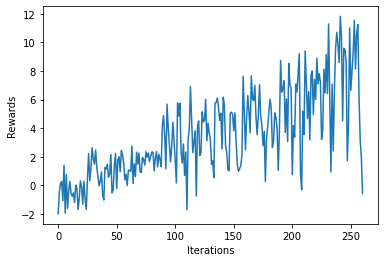

 26%|██████████████████▌                                                    | 26101/100000 [1:41:58<8:43:30,  2.35it/s]

Updated Weights
Mean Reward = -4.92
22


 26%|██████████████████▌                                                    | 26201/100000 [1:42:38<7:19:41,  2.80it/s]

Updated Weights
Mean Reward = -1.01
23


 26%|██████████████████▋                                                    | 26301/100000 [1:43:16<7:11:28,  2.85it/s]

Updated Weights
Mean Reward = 4.63
28


 26%|██████████████████▋                                                    | 26401/100000 [1:43:54<9:27:16,  2.16it/s]

Updated Weights
Mean Reward = 3.31
34


 26%|██████████████████▌                                                   | 26500/100000 [1:44:43<12:28:08,  1.64it/s]

Updated Weights
Mean Reward = 4.45
21


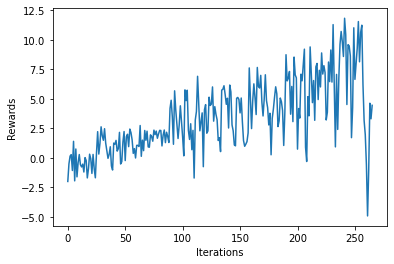

 27%|██████████████████▌                                                   | 26601/100000 [1:45:32<11:26:49,  1.78it/s]

Updated Weights
Mean Reward = 5.08
29


 27%|██████████████████▉                                                    | 26701/100000 [1:46:19<8:33:44,  2.38it/s]

Updated Weights
Mean Reward = -4.84
15


 27%|███████████████████                                                    | 26801/100000 [1:47:02<7:51:39,  2.59it/s]

Updated Weights
Mean Reward = -3.78
24


 27%|███████████████████                                                    | 26901/100000 [1:47:44<8:52:21,  2.29it/s]

Updated Weights
Mean Reward = 0.58
28


 27%|███████████████████▏                                                   | 27000/100000 [1:48:23<7:24:11,  2.74it/s]

Updated Weights
Mean Reward = -2.71
26


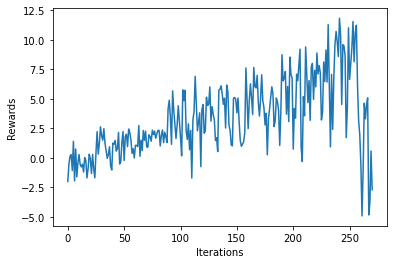

 27%|███████████████████▏                                                   | 27102/100000 [1:49:05<6:26:19,  3.14it/s]

Updated Weights
Mean Reward = -2.47
19


 27%|███████████████████▎                                                   | 27201/100000 [1:49:41<8:41:28,  2.33it/s]

Updated Weights
Mean Reward = 4.6
26


 27%|███████████████████▍                                                   | 27301/100000 [1:50:20<9:46:20,  2.07it/s]

Updated Weights
Mean Reward = 0.1
22


 27%|███████████████████▍                                                   | 27401/100000 [1:51:01<9:35:02,  2.10it/s]

Updated Weights
Mean Reward = 7.46
20


 28%|███████████████████▌                                                   | 27500/100000 [1:51:39<7:45:49,  2.59it/s]

Updated Weights
Mean Reward = 4.81
14


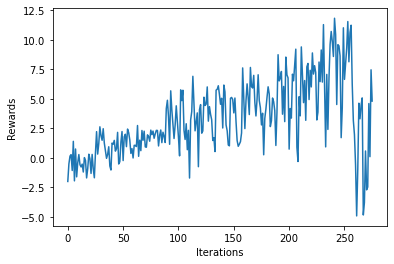

 28%|███████████████████▌                                                   | 27601/100000 [1:52:19<7:53:01,  2.55it/s]

Updated Weights
Mean Reward = 4.11
18


 28%|███████████████████▋                                                   | 27702/100000 [1:52:55<5:50:46,  3.44it/s]

Updated Weights
Mean Reward = 3.84
19


 28%|███████████████████▋                                                   | 27801/100000 [1:53:31<8:29:19,  2.36it/s]

Updated Weights
Mean Reward = 5.12
23


 28%|███████████████████▊                                                   | 27901/100000 [1:54:11<8:04:05,  2.48it/s]

Updated Weights
Mean Reward = 2.81
24


 28%|███████████████████▉                                                   | 28000/100000 [1:54:52<8:25:57,  2.37it/s]

Updated Weights
Mean Reward = 6.37
31


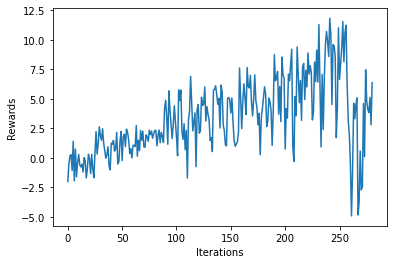

 28%|███████████████████▉                                                   | 28101/100000 [1:55:42<9:45:17,  2.05it/s]

Updated Weights
Mean Reward = 7.48
28


 28%|████████████████████                                                   | 28201/100000 [1:56:30<9:30:57,  2.10it/s]

Updated Weights
Mean Reward = 6.3
16


 28%|████████████████████                                                   | 28302/100000 [1:57:14<6:45:21,  2.95it/s]

Updated Weights
Mean Reward = 4.09
22


 28%|████████████████████▏                                                  | 28401/100000 [1:57:55<8:26:48,  2.35it/s]

Updated Weights
Mean Reward = 7.92
36


 28%|████████████████████▏                                                  | 28500/100000 [1:58:30<6:38:04,  2.99it/s]

Updated Weights
Mean Reward = 8.53
26


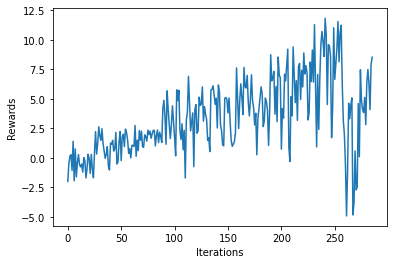

 29%|████████████████████▎                                                  | 28601/100000 [1:59:03<7:16:11,  2.73it/s]

Updated Weights
Mean Reward = 8.89
34


 29%|████████████████████▍                                                  | 28702/100000 [1:59:35<3:33:41,  5.56it/s]

Updated Weights
Mean Reward = 6.4
28


 29%|████████████████████▍                                                  | 28800/100000 [2:00:06<6:24:24,  3.09it/s]

Updated Weights
Mean Reward = 5.57
28


 29%|████████████████████▌                                                  | 28903/100000 [2:00:37<5:16:07,  3.75it/s]

Updated Weights
Mean Reward = 5.55
31


 29%|████████████████████▌                                                  | 29000/100000 [2:01:08<7:08:59,  2.76it/s]

Updated Weights
Mean Reward = 8.29
25


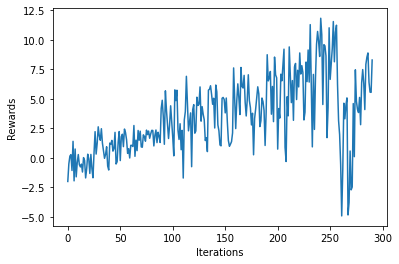

 29%|████████████████████▋                                                  | 29101/100000 [2:01:39<6:08:45,  3.20it/s]

Updated Weights
Mean Reward = 2.71
27


 29%|████████████████████▋                                                  | 29201/100000 [2:02:11<6:25:38,  3.06it/s]

Updated Weights
Mean Reward = 9.5
39


 29%|████████████████████▊                                                  | 29301/100000 [2:02:43<6:27:02,  3.04it/s]

Updated Weights
Mean Reward = 8.44
32


 29%|████████████████████▊                                                  | 29401/100000 [2:03:17<8:09:47,  2.40it/s]

Updated Weights
Mean Reward = 2.57
21


 30%|████████████████████▉                                                  | 29500/100000 [2:03:53<7:44:37,  2.53it/s]

Updated Weights
Mean Reward = 8.71
47


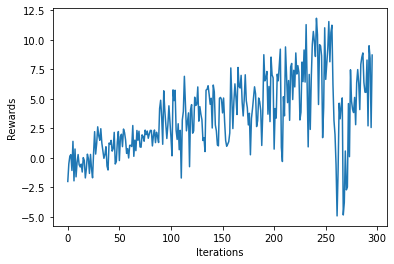

 30%|█████████████████████                                                  | 29600/100000 [2:04:38<9:22:35,  2.09it/s]

Updated Weights
Mean Reward = 7.28
36


 30%|█████████████████████                                                  | 29701/100000 [2:05:20<9:08:25,  2.14it/s]

Updated Weights
Mean Reward = 7.25
26


 30%|█████████████████████▏                                                 | 29801/100000 [2:05:57<7:12:33,  2.70it/s]

Updated Weights
Mean Reward = 12.17
42


 30%|█████████████████████▏                                                 | 29902/100000 [2:06:38<4:43:51,  4.12it/s]

Updated Weights
Mean Reward = 9.57
28


 30%|█████████████████████▎                                                 | 30000/100000 [2:07:15<8:11:01,  2.38it/s]

Updated Weights
Mean Reward = 9.16
41


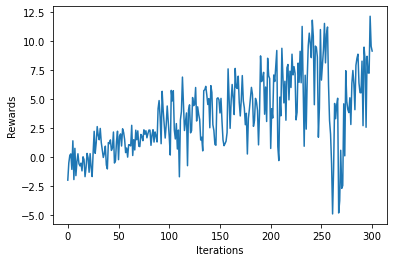

 30%|█████████████████████▎                                                 | 30101/100000 [2:07:58<7:48:52,  2.48it/s]

Updated Weights
Mean Reward = 8.89
26


 30%|█████████████████████▍                                                 | 30202/100000 [2:08:33<5:10:16,  3.75it/s]

Updated Weights
Mean Reward = 6.96
24


 30%|█████████████████████▌                                                 | 30301/100000 [2:09:07<5:42:51,  3.39it/s]

Updated Weights
Mean Reward = 8.57
39


 30%|█████████████████████▌                                                 | 30401/100000 [2:09:38<5:10:11,  3.74it/s]

Updated Weights
Mean Reward = 9.3
34


 30%|█████████████████████▋                                                 | 30500/100000 [2:10:10<5:33:15,  3.48it/s]

Updated Weights
Mean Reward = 9.43
30


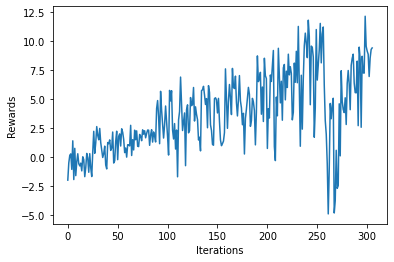

 31%|█████████████████████▋                                                 | 30601/100000 [2:10:36<4:46:05,  4.04it/s]

Updated Weights
Mean Reward = 9.12
54


 31%|█████████████████████▊                                                 | 30701/100000 [2:11:09<5:59:02,  3.22it/s]

Updated Weights
Mean Reward = 11.37
28


 31%|█████████████████████▊                                                 | 30802/100000 [2:11:38<4:54:52,  3.91it/s]

Updated Weights
Mean Reward = 14.58
49


 31%|█████████████████████▉                                                 | 30901/100000 [2:12:10<6:56:04,  2.77it/s]

Updated Weights
Mean Reward = 9.49
27


 31%|██████████████████████                                                 | 31000/100000 [2:12:41<7:05:55,  2.70it/s]

Updated Weights
Mean Reward = 9.67
29


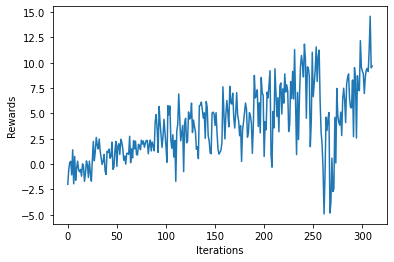

 31%|██████████████████████                                                 | 31102/100000 [2:13:14<3:49:10,  5.01it/s]

Updated Weights
Mean Reward = 7.03
29


 31%|██████████████████████▏                                                | 31201/100000 [2:13:44<7:52:06,  2.43it/s]

Updated Weights
Mean Reward = 6.31
38


 31%|██████████████████████▏                                                | 31301/100000 [2:14:22<5:35:10,  3.42it/s]

Updated Weights
Mean Reward = 5.2
34


 31%|██████████████████████▎                                                | 31401/100000 [2:14:57<7:22:12,  2.59it/s]

Updated Weights
Mean Reward = 9.08
53


 32%|██████████████████████                                                | 31500/100000 [2:15:49<11:08:08,  1.71it/s]

Updated Weights
Mean Reward = 10.58
29


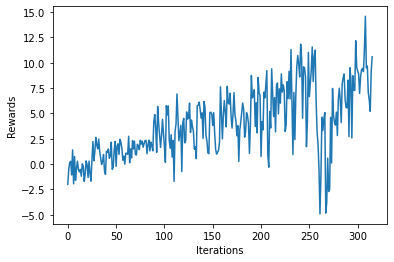

 32%|██████████████████████                                                | 31601/100000 [2:16:41<11:12:14,  1.70it/s]

Updated Weights
Mean Reward = 10.58
28


 32%|██████████████████████▌                                                | 31701/100000 [2:17:41<8:23:58,  2.26it/s]

Updated Weights
Mean Reward = 11.4
49


 32%|██████████████████████▌                                                | 31801/100000 [2:18:28<7:03:53,  2.68it/s]

Updated Weights
Mean Reward = 11.93
33


 32%|██████████████████████▋                                                | 31902/100000 [2:19:11<5:12:46,  3.63it/s]

Updated Weights
Mean Reward = 8.31
29


 32%|██████████████████████▋                                                | 32000/100000 [2:19:49<7:51:21,  2.40it/s]

Updated Weights
Mean Reward = 8.68
28


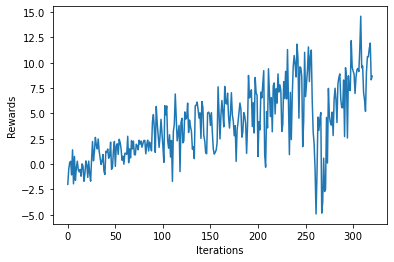

 32%|██████████████████████▊                                                | 32101/100000 [2:20:25<7:02:25,  2.68it/s]

Updated Weights
Mean Reward = 9.82
42


 32%|██████████████████████▊                                                | 32201/100000 [2:20:59<6:57:16,  2.71it/s]

Updated Weights
Mean Reward = 12.08
30


 32%|██████████████████████▉                                                | 32301/100000 [2:21:32<9:49:39,  1.91it/s]

Updated Weights
Mean Reward = 9.98
45


 32%|███████████████████████                                                | 32401/100000 [2:22:17<9:20:05,  2.01it/s]

Updated Weights
Mean Reward = 13.33
38


 32%|███████████████████████                                                | 32500/100000 [2:23:01<9:00:52,  2.08it/s]

Updated Weights
Mean Reward = -0.23
25


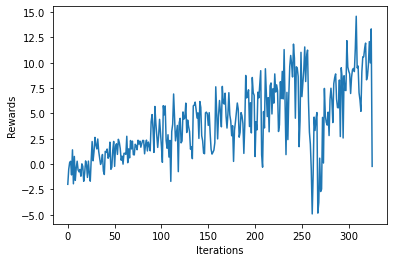

 33%|██████████████████████▊                                               | 32601/100000 [2:23:45<10:23:16,  1.80it/s]

Updated Weights
Mean Reward = 4.52
35


 33%|███████████████████████▏                                               | 32701/100000 [2:24:30<9:15:55,  2.02it/s]

Updated Weights
Mean Reward = 7.4
27


 33%|███████████████████████▎                                               | 32801/100000 [2:25:15<7:37:37,  2.45it/s]

Updated Weights
Mean Reward = 9.94
30


 33%|███████████████████████▎                                               | 32902/100000 [2:26:03<7:00:38,  2.66it/s]

Updated Weights
Mean Reward = 9.41
25


 33%|███████████████████████▍                                               | 33000/100000 [2:26:43<7:11:05,  2.59it/s]

Updated Weights
Mean Reward = 11.05
43


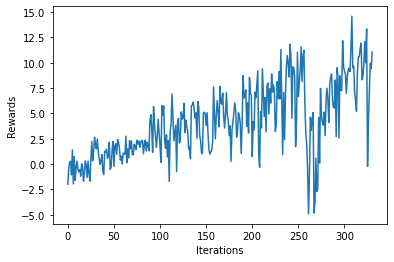

 33%|███████████████████████▌                                               | 33101/100000 [2:27:28<7:54:43,  2.35it/s]

Updated Weights
Mean Reward = 9.03
41


 33%|███████████████████████▌                                               | 33202/100000 [2:28:08<6:45:22,  2.75it/s]

Updated Weights
Mean Reward = 11.09
46


 33%|███████████████████████▋                                               | 33302/100000 [2:28:50<6:21:07,  2.92it/s]

Updated Weights
Mean Reward = 11.7
37


 33%|███████████████████████▋                                               | 33401/100000 [2:29:26<6:16:07,  2.95it/s]

Updated Weights
Mean Reward = 10.77
37


 34%|███████████████████████▊                                               | 33500/100000 [2:29:59<6:05:05,  3.04it/s]

Updated Weights
Mean Reward = 11.33
38


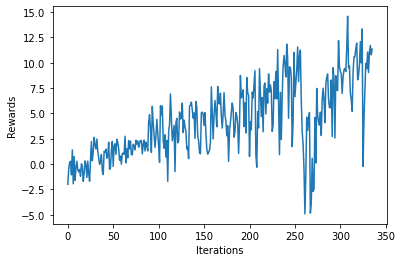

 34%|███████████████████████▊                                               | 33601/100000 [2:30:35<7:27:09,  2.47it/s]

Updated Weights
Mean Reward = 13.0
39


 34%|███████████████████████▌                                              | 33700/100000 [2:31:21<11:55:03,  1.55it/s]

Updated Weights
Mean Reward = 9.52
33


 34%|███████████████████████▉                                               | 33801/100000 [2:32:01<6:21:12,  2.89it/s]

Updated Weights
Mean Reward = 7.94
28


 34%|████████████████████████                                               | 33901/100000 [2:32:44<7:33:08,  2.43it/s]

Updated Weights
Mean Reward = 7.58
21


 34%|████████████████████████▏                                              | 33999/100000 [2:33:23<7:47:56,  2.35it/s]

Updated Weights
Mean Reward = 10.48
35


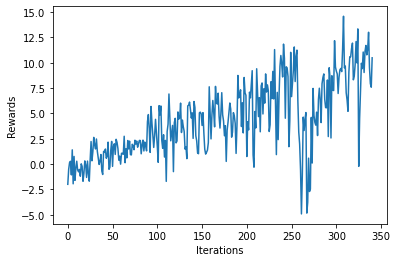

 34%|████████████████████████▏                                              | 34101/100000 [2:34:04<6:27:58,  2.83it/s]

Updated Weights
Mean Reward = 14.39
51


 34%|████████████████████████▎                                              | 34201/100000 [2:34:55<9:49:41,  1.86it/s]

Updated Weights
Mean Reward = 13.65
22


 34%|████████████████████████                                              | 34301/100000 [2:36:01<14:07:24,  1.29it/s]

Updated Weights
Mean Reward = 6.14
27


 34%|████████████████████████▍                                              | 34401/100000 [2:37:05<8:30:48,  2.14it/s]

Updated Weights
Mean Reward = 8.07
31


 34%|████████████████████████▍                                              | 34500/100000 [2:38:00<9:50:32,  1.85it/s]

Updated Weights
Mean Reward = 9.64
26


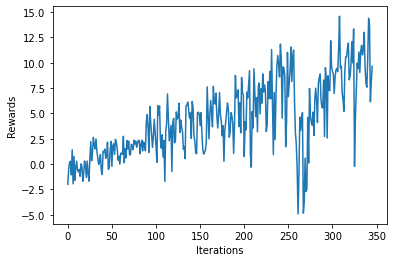

 35%|████████████████████████▌                                              | 34601/100000 [2:39:06<7:03:04,  2.58it/s]

Updated Weights
Mean Reward = 5.74
28


 35%|████████████████████████▋                                              | 34701/100000 [2:39:47<6:17:38,  2.88it/s]

Updated Weights
Mean Reward = 10.82
37


 35%|████████████████████████▋                                              | 34801/100000 [2:40:21<8:18:07,  2.18it/s]

Updated Weights
Mean Reward = 12.18
37


 35%|████████████████████████▊                                              | 34903/100000 [2:40:58<5:09:36,  3.50it/s]

Updated Weights
Mean Reward = 10.37
33


 35%|████████████████████████▊                                              | 35000/100000 [2:41:35<7:06:08,  2.54it/s]

Updated Weights
Mean Reward = 10.78
31


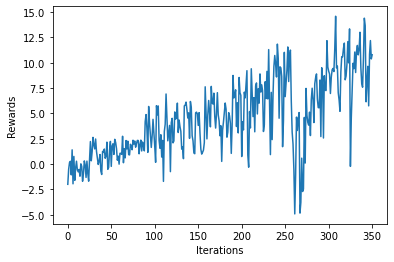

 35%|████████████████████████▉                                              | 35101/100000 [2:42:21<7:45:59,  2.32it/s]

Updated Weights
Mean Reward = 11.08
24


 35%|████████████████████████▉                                              | 35201/100000 [2:42:59<7:26:48,  2.42it/s]

Updated Weights
Mean Reward = 10.23
40


 35%|█████████████████████████                                              | 35301/100000 [2:43:37<7:38:15,  2.35it/s]

Updated Weights
Mean Reward = 10.02
28


 35%|█████████████████████████▏                                             | 35401/100000 [2:44:10<6:31:35,  2.75it/s]

Updated Weights
Mean Reward = 8.06
39


 36%|█████████████████████████▏                                             | 35500/100000 [2:44:48<7:04:10,  2.53it/s]

Updated Weights
Mean Reward = 0.85
16


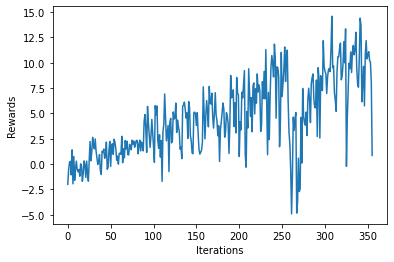

 36%|█████████████████████████▎                                             | 35601/100000 [2:45:26<6:37:48,  2.70it/s]

Updated Weights
Mean Reward = 3.24
26


 36%|█████████████████████████▎                                             | 35701/100000 [2:45:59<7:33:54,  2.36it/s]

Updated Weights
Mean Reward = 11.58
38


 36%|█████████████████████████▍                                             | 35802/100000 [2:46:37<4:54:42,  3.63it/s]

Updated Weights
Mean Reward = 9.83
29


 36%|█████████████████████████▍                                             | 35901/100000 [2:47:14<7:37:39,  2.33it/s]

Updated Weights
Mean Reward = 8.95
23


 36%|█████████████████████████▌                                             | 36000/100000 [2:47:52<6:37:28,  2.68it/s]

Updated Weights
Mean Reward = 7.06
20


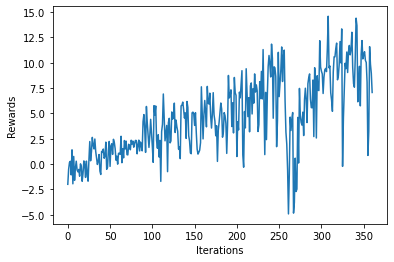

 36%|█████████████████████████▋                                             | 36101/100000 [2:48:27<6:31:50,  2.72it/s]

Updated Weights
Mean Reward = 2.5
33


 36%|█████████████████████████▋                                             | 36201/100000 [2:49:07<6:44:53,  2.63it/s]

Updated Weights
Mean Reward = 12.21
40


 36%|█████████████████████████▊                                             | 36302/100000 [2:49:41<6:06:06,  2.90it/s]

Updated Weights
Mean Reward = 12.14
41


 36%|█████████████████████████▊                                             | 36402/100000 [2:50:14<5:45:04,  3.07it/s]

Updated Weights
Mean Reward = 10.14
43


 36%|█████████████████████████▉                                             | 36500/100000 [2:50:48<5:53:36,  2.99it/s]

Updated Weights
Mean Reward = 10.47
40


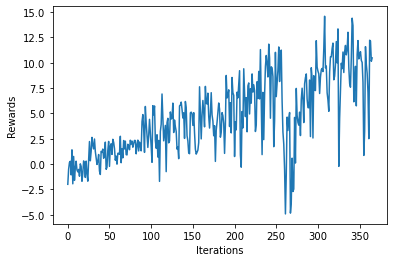

 37%|█████████████████████████▉                                             | 36601/100000 [2:51:21<4:16:29,  4.12it/s]

Updated Weights
Mean Reward = 13.87
46


 37%|██████████████████████████                                             | 36701/100000 [2:51:56<6:09:46,  2.85it/s]

Updated Weights
Mean Reward = 13.36
37


 37%|██████████████████████████▏                                            | 36801/100000 [2:52:30<4:38:49,  3.78it/s]

Updated Weights
Mean Reward = 11.2
33


 37%|██████████████████████████▏                                            | 36901/100000 [2:53:07<6:15:58,  2.80it/s]

Updated Weights
Mean Reward = 10.48
24


 37%|██████████████████████████▎                                            | 37000/100000 [2:53:40<5:19:12,  3.29it/s]

Updated Weights
Mean Reward = 11.48
46


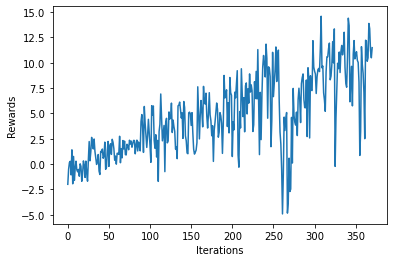

 37%|██████████████████████████▎                                            | 37101/100000 [2:54:14<5:43:30,  3.05it/s]

Updated Weights
Mean Reward = 10.41
37


 37%|██████████████████████████▍                                            | 37201/100000 [2:54:48<6:29:28,  2.69it/s]

Updated Weights
Mean Reward = 15.75
34


 37%|██████████████████████████▍                                            | 37301/100000 [2:55:24<7:04:58,  2.46it/s]

Updated Weights
Mean Reward = 8.34
34


 37%|██████████████████████████▌                                            | 37401/100000 [2:55:55<6:17:56,  2.76it/s]

Updated Weights
Mean Reward = 12.83
47


 38%|██████████████████████████▋                                            | 37500/100000 [2:56:26<5:43:18,  3.03it/s]

Updated Weights
Mean Reward = 12.01
50


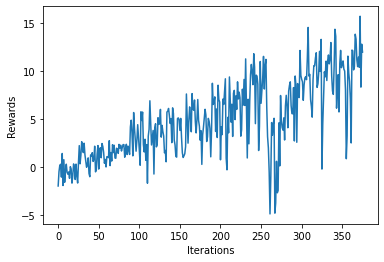

 38%|██████████████████████████▋                                            | 37601/100000 [2:57:05<7:14:18,  2.39it/s]

Updated Weights
Mean Reward = 5.88
26


 38%|██████████████████████████▊                                            | 37701/100000 [2:57:45<5:53:49,  2.93it/s]

Updated Weights
Mean Reward = 5.28
28


 38%|██████████████████████████▊                                            | 37801/100000 [2:58:22<6:19:11,  2.73it/s]

Updated Weights
Mean Reward = 12.52
32


 38%|██████████████████████████▉                                            | 37901/100000 [2:58:53<7:02:01,  2.45it/s]

Updated Weights
Mean Reward = 13.69
49


 38%|██████████████████████████▉                                            | 38000/100000 [2:59:33<7:20:07,  2.35it/s]

Updated Weights
Mean Reward = 12.09
19


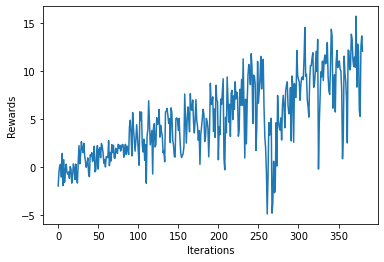

 38%|███████████████████████████                                            | 38102/100000 [3:00:11<4:29:05,  3.83it/s]

Updated Weights
Mean Reward = 8.88
28


 38%|███████████████████████████                                            | 38201/100000 [3:00:42<6:28:02,  2.65it/s]

Updated Weights
Mean Reward = 12.33
51


 38%|███████████████████████████▏                                           | 38301/100000 [3:01:17<6:27:55,  2.65it/s]

Updated Weights
Mean Reward = 10.52
42


 38%|███████████████████████████▎                                           | 38400/100000 [3:01:56<5:45:11,  2.97it/s]

Updated Weights
Mean Reward = 9.37
26


 38%|███████████████████████████▎                                           | 38500/100000 [3:02:35<5:24:09,  3.16it/s]

Updated Weights
Mean Reward = 10.65
21


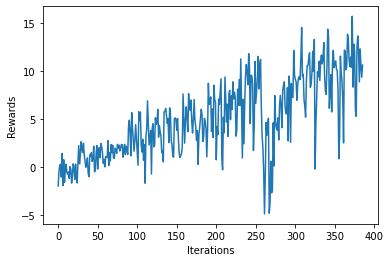

 39%|███████████████████████████▍                                           | 38601/100000 [3:03:14<6:50:41,  2.49it/s]

Updated Weights
Mean Reward = 10.96
28


 39%|███████████████████████████▍                                           | 38701/100000 [3:03:52<7:15:44,  2.34it/s]

Updated Weights
Mean Reward = 7.32
30


 39%|███████████████████████████▌                                           | 38801/100000 [3:04:29<5:20:20,  3.18it/s]

Updated Weights
Mean Reward = 4.78
29


 39%|███████████████████████████▌                                           | 38900/100000 [3:05:04<4:28:45,  3.79it/s]

Updated Weights
Mean Reward = 10.28
46


 39%|███████████████████████████▋                                           | 39000/100000 [3:05:38<6:40:15,  2.54it/s]

Updated Weights
Mean Reward = 9.96
42


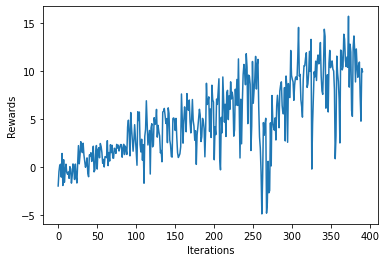

 39%|███████████████████████████▊                                           | 39101/100000 [3:06:17<7:16:53,  2.32it/s]

Updated Weights
Mean Reward = 12.07
26


 39%|███████████████████████████▊                                           | 39201/100000 [3:06:54<6:38:24,  2.54it/s]

Updated Weights
Mean Reward = 10.54
30


 39%|███████████████████████████▉                                           | 39301/100000 [3:07:31<6:44:07,  2.50it/s]

Updated Weights
Mean Reward = 11.57
30


 39%|███████████████████████████▉                                           | 39402/100000 [3:08:05<4:29:03,  3.75it/s]

Updated Weights
Mean Reward = 11.05
47


 40%|████████████████████████████                                           | 39500/100000 [3:08:39<6:53:17,  2.44it/s]

Updated Weights
Mean Reward = 12.63
41


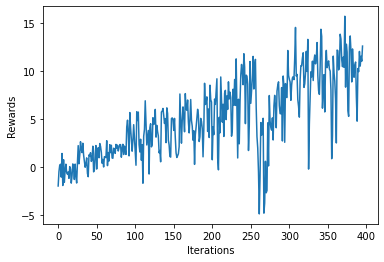

 40%|████████████████████████████                                           | 39601/100000 [3:09:21<7:13:35,  2.32it/s]

Updated Weights
Mean Reward = 10.63
21


 40%|████████████████████████████▏                                          | 39700/100000 [3:09:59<7:34:30,  2.21it/s]

Updated Weights
Mean Reward = 12.14
32


 40%|████████████████████████████▎                                          | 39800/100000 [3:10:36<6:19:06,  2.65it/s]

Updated Weights
Mean Reward = 12.21
38


 40%|████████████████████████████▎                                          | 39901/100000 [3:11:10<5:05:12,  3.28it/s]

Updated Weights
Mean Reward = 8.23
40


 40%|████████████████████████████▍                                          | 39999/100000 [3:11:44<5:25:59,  3.07it/s]

Updated Weights
Mean Reward = 8.52
44


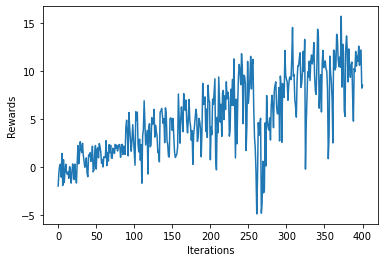

 40%|████████████████████████████▍                                          | 40101/100000 [3:12:18<6:54:39,  2.41it/s]

Updated Weights
Mean Reward = 15.01
49


 40%|████████████████████████████▌                                          | 40201/100000 [3:12:53<6:16:37,  2.65it/s]

Updated Weights
Mean Reward = 10.81
33


 40%|████████████████████████████▌                                          | 40301/100000 [3:13:31<6:45:29,  2.45it/s]

Updated Weights
Mean Reward = 9.5
31


 40%|████████████████████████████▋                                          | 40401/100000 [3:14:11<6:51:58,  2.41it/s]

Updated Weights
Mean Reward = 11.66
32


 40%|████████████████████████████▊                                          | 40500/100000 [3:14:53<8:19:19,  1.99it/s]

Updated Weights
Mean Reward = 9.57
38


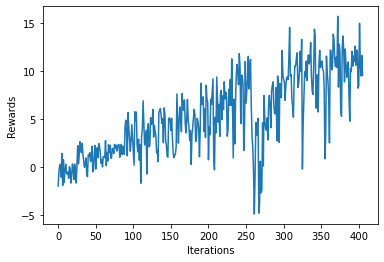

 41%|████████████████████████████▊                                          | 40602/100000 [3:15:35<4:40:56,  3.52it/s]

Updated Weights
Mean Reward = 10.61
34


 41%|████████████████████████████▉                                          | 40701/100000 [3:16:06<6:07:10,  2.69it/s]

Updated Weights
Mean Reward = 15.42
51


 41%|████████████████████████████▉                                          | 40801/100000 [3:16:48<4:39:12,  3.53it/s]

Updated Weights
Mean Reward = 13.72
38


 41%|█████████████████████████████                                          | 40902/100000 [3:17:30<6:56:51,  2.36it/s]

Updated Weights
Mean Reward = 3.0
22


 41%|█████████████████████████████                                          | 41000/100000 [3:18:13<8:03:04,  2.04it/s]

Updated Weights
Mean Reward = 9.62
28


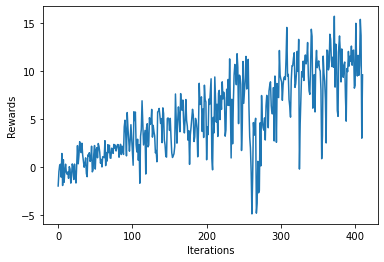

 41%|█████████████████████████████▏                                         | 41102/100000 [3:18:54<5:21:08,  3.06it/s]

Updated Weights
Mean Reward = 8.74
26


 41%|█████████████████████████████▎                                         | 41201/100000 [3:19:28<4:02:06,  4.05it/s]

Updated Weights
Mean Reward = 11.03
53


 41%|█████████████████████████████▎                                         | 41301/100000 [3:20:09<5:45:41,  2.83it/s]

Updated Weights
Mean Reward = 10.26
42


 41%|█████████████████████████████▍                                         | 41401/100000 [3:20:50<6:39:50,  2.44it/s]

Updated Weights
Mean Reward = 8.3
25


 42%|█████████████████████████████▍                                         | 41500/100000 [3:21:28<5:44:42,  2.83it/s]

Updated Weights
Mean Reward = 6.63
35


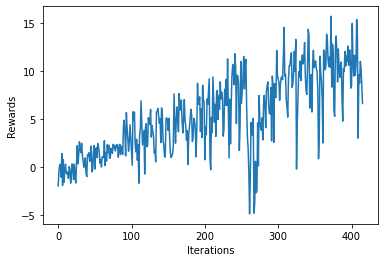

 42%|█████████████████████████████▌                                         | 41601/100000 [3:22:13<6:52:47,  2.36it/s]

Updated Weights
Mean Reward = 5.88
18


 42%|█████████████████████████████▌                                         | 41701/100000 [3:22:57<8:01:59,  2.02it/s]

Updated Weights
Mean Reward = 8.08
27


 42%|█████████████████████████████▋                                         | 41801/100000 [3:23:46<9:23:36,  1.72it/s]

Updated Weights
Mean Reward = 15.46
35


 42%|█████████████████████████████▋                                         | 41901/100000 [3:24:26<6:12:44,  2.60it/s]

Updated Weights
Mean Reward = 12.01
29


 42%|█████████████████████████████▊                                         | 42000/100000 [3:25:05<6:43:14,  2.40it/s]

Updated Weights
Mean Reward = 10.17
37


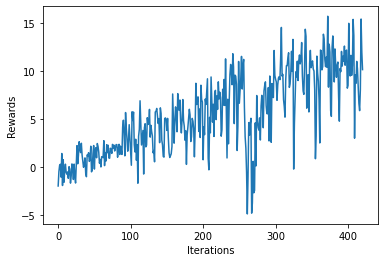

 42%|█████████████████████████████▉                                         | 42101/100000 [3:25:49<5:51:05,  2.75it/s]

Updated Weights
Mean Reward = 10.72
35


 42%|█████████████████████████████▉                                         | 42201/100000 [3:26:33<4:49:56,  3.32it/s]

Updated Weights
Mean Reward = 10.2
38


 42%|██████████████████████████████                                         | 42301/100000 [3:27:15<7:54:49,  2.03it/s]

Updated Weights
Mean Reward = 11.39
36


 42%|██████████████████████████████                                         | 42402/100000 [3:27:59<6:02:15,  2.65it/s]

Updated Weights
Mean Reward = 11.53
38


 42%|██████████████████████████████▏                                        | 42500/100000 [3:29:04<9:57:35,  1.60it/s]

Updated Weights
Mean Reward = 7.16
14


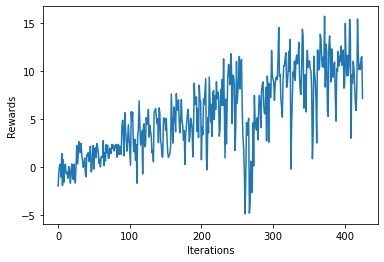

 43%|██████████████████████████████▏                                        | 42601/100000 [3:30:13<7:01:12,  2.27it/s]

Updated Weights
Mean Reward = 3.61
19


 43%|██████████████████████████████▎                                        | 42701/100000 [3:30:57<6:24:25,  2.48it/s]

Updated Weights
Mean Reward = 9.3
38


 43%|██████████████████████████████▍                                        | 42801/100000 [3:31:41<8:49:17,  1.80it/s]

Updated Weights
Mean Reward = 10.66
38


 43%|██████████████████████████████▍                                        | 42901/100000 [3:32:49<9:16:58,  1.71it/s]

Updated Weights
Mean Reward = 10.25
22


 43%|██████████████████████████████▌                                        | 43000/100000 [3:33:40<7:48:12,  2.03it/s]

Updated Weights
Mean Reward = 10.04
31


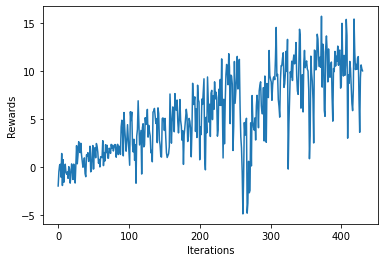

 43%|██████████████████████████████▌                                        | 43101/100000 [3:34:39<9:24:32,  1.68it/s]

Updated Weights
Mean Reward = 10.32
47


 43%|██████████████████████████████▋                                        | 43201/100000 [3:35:48<6:35:19,  2.39it/s]

Updated Weights
Mean Reward = 11.91
46


 43%|██████████████████████████████▋                                        | 43301/100000 [3:36:40<4:16:09,  3.69it/s]

Updated Weights
Mean Reward = 12.5
60


 43%|██████████████████████████████▊                                        | 43401/100000 [3:37:31<3:55:25,  4.01it/s]

Updated Weights
Mean Reward = 11.53
38


 44%|██████████████████████████████▉                                        | 43500/100000 [3:38:23<8:04:03,  1.95it/s]

Updated Weights
Mean Reward = 10.89
24


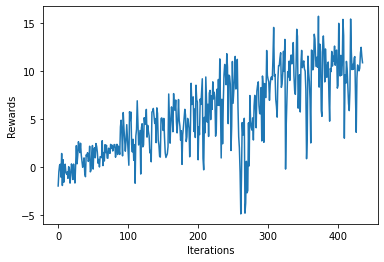

 44%|██████████████████████████████▉                                        | 43601/100000 [3:39:05<4:21:39,  3.59it/s]

Updated Weights
Mean Reward = 11.35
51


 44%|██████████████████████████████▌                                       | 43701/100000 [3:39:51<10:18:29,  1.52it/s]

Updated Weights
Mean Reward = 12.32
58


 44%|███████████████████████████████                                        | 43802/100000 [3:40:54<8:35:00,  1.82it/s]

Updated Weights
Mean Reward = 5.85
31


 44%|███████████████████████████████▏                                       | 43901/100000 [3:41:38<4:53:39,  3.18it/s]

Updated Weights
Mean Reward = 9.94
43


 44%|███████████████████████████████▏                                       | 44000/100000 [3:42:23<8:16:26,  1.88it/s]

Updated Weights
Mean Reward = 9.26
34


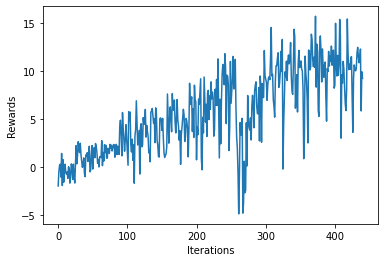

 44%|██████████████████████████████▊                                       | 44101/100000 [3:43:20<10:29:32,  1.48it/s]

Updated Weights
Mean Reward = 11.51
27


 44%|███████████████████████████████▍                                       | 44201/100000 [3:44:11<9:49:50,  1.58it/s]

Updated Weights
Mean Reward = 8.24
29


 44%|███████████████████████████████▍                                       | 44300/100000 [3:44:58<6:29:57,  2.38it/s]

Updated Weights
Mean Reward = 10.19
34


 44%|███████████████████████████████▌                                       | 44401/100000 [3:45:36<4:05:20,  3.78it/s]

Updated Weights
Mean Reward = 12.09
34


 44%|███████████████████████████████▌                                       | 44500/100000 [3:46:16<6:54:21,  2.23it/s]

Updated Weights
Mean Reward = 10.13
28


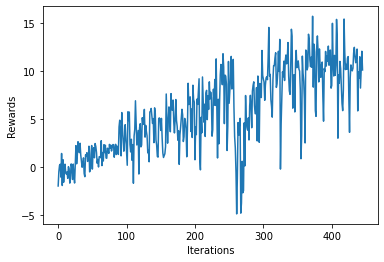

 45%|███████████████████████████████▋                                       | 44601/100000 [3:46:51<4:34:36,  3.36it/s]

Updated Weights
Mean Reward = 9.01
44


 45%|███████████████████████████████▋                                       | 44701/100000 [3:47:37<6:46:49,  2.27it/s]

Updated Weights
Mean Reward = 9.43
29


 45%|███████████████████████████████▊                                       | 44801/100000 [3:48:14<7:00:44,  2.19it/s]

Updated Weights
Mean Reward = 9.23
34


 45%|███████████████████████████████▉                                       | 44901/100000 [3:48:58<7:24:25,  2.07it/s]

Updated Weights
Mean Reward = -4.14
24


 45%|███████████████████████████████▉                                       | 45000/100000 [3:49:39<6:10:43,  2.47it/s]

Updated Weights
Mean Reward = -0.86
7


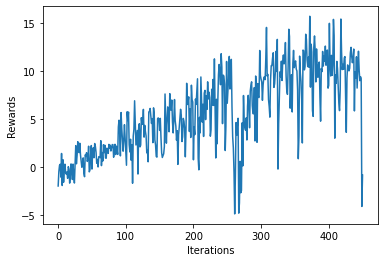

 45%|████████████████████████████████                                       | 45101/100000 [3:50:20<6:25:20,  2.37it/s]

Updated Weights
Mean Reward = 6.31
16


 45%|████████████████████████████████                                       | 45201/100000 [3:51:00<6:23:13,  2.38it/s]

Updated Weights
Mean Reward = 9.42
35


 45%|████████████████████████████████▏                                      | 45301/100000 [3:51:38<6:43:02,  2.26it/s]

Updated Weights
Mean Reward = 9.8
28


 45%|████████████████████████████████▏                                      | 45401/100000 [3:52:16<4:57:23,  3.06it/s]

Updated Weights
Mean Reward = 17.5
26


 46%|████████████████████████████████▎                                      | 45500/100000 [3:52:54<5:48:16,  2.61it/s]

Updated Weights
Mean Reward = 8.57
22


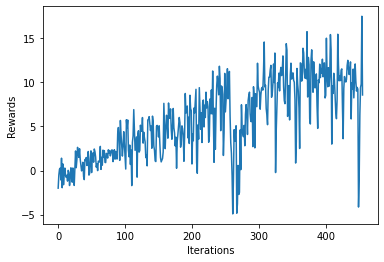

 46%|████████████████████████████████▍                                      | 45601/100000 [3:53:33<6:40:05,  2.27it/s]

Updated Weights
Mean Reward = 3.82
21


 46%|████████████████████████████████▍                                      | 45701/100000 [3:54:16<6:35:11,  2.29it/s]

Updated Weights
Mean Reward = 9.11
17


 46%|████████████████████████████████▌                                      | 45801/100000 [3:54:55<6:12:37,  2.42it/s]

Updated Weights
Mean Reward = 7.12
23


 46%|████████████████████████████████▌                                      | 45901/100000 [3:55:32<6:34:23,  2.29it/s]

Updated Weights
Mean Reward = 8.77
35


 46%|████████████████████████████████▋                                      | 46000/100000 [3:56:08<5:29:04,  2.73it/s]

Updated Weights
Mean Reward = 12.89
28


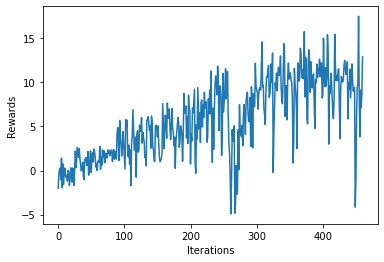

 46%|████████████████████████████████▋                                      | 46101/100000 [3:56:52<5:51:52,  2.55it/s]

Updated Weights
Mean Reward = 10.78
25


 46%|████████████████████████████████▊                                      | 46201/100000 [3:57:36<7:44:01,  1.93it/s]

Updated Weights
Mean Reward = 10.37
15


 46%|████████████████████████████████▊                                      | 46301/100000 [3:58:21<7:00:39,  2.13it/s]

Updated Weights
Mean Reward = 6.77
29


 46%|████████████████████████████████▉                                      | 46401/100000 [3:58:59<5:11:45,  2.87it/s]

Updated Weights
Mean Reward = 6.39
39


 46%|█████████████████████████████████                                      | 46500/100000 [3:59:33<5:13:47,  2.84it/s]

Updated Weights
Mean Reward = 9.8
42


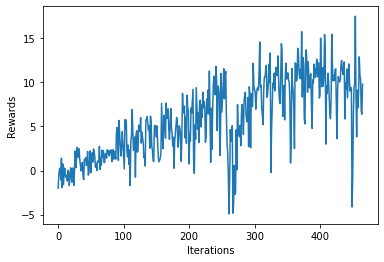

 47%|█████████████████████████████████                                      | 46602/100000 [4:00:07<3:38:30,  4.07it/s]

Updated Weights
Mean Reward = 10.58
42


 47%|█████████████████████████████████▏                                     | 46701/100000 [4:00:39<5:40:07,  2.61it/s]

Updated Weights
Mean Reward = 10.63
45


 47%|█████████████████████████████████▏                                     | 46800/100000 [4:01:18<6:46:57,  2.18it/s]

Updated Weights
Mean Reward = 11.48
18


 47%|█████████████████████████████████▎                                     | 46901/100000 [4:01:56<4:43:59,  3.12it/s]

Updated Weights
Mean Reward = 5.35
32


 47%|█████████████████████████████████▎                                     | 47000/100000 [4:02:30<3:04:49,  4.78it/s]

Updated Weights
Mean Reward = 11.72
39


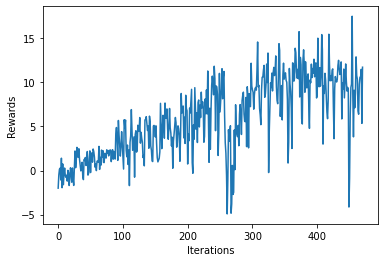

 47%|█████████████████████████████████▍                                     | 47101/100000 [4:03:07<4:17:39,  3.42it/s]

Updated Weights
Mean Reward = 12.57
40


 47%|█████████████████████████████████▌                                     | 47202/100000 [4:03:32<3:46:48,  3.88it/s]

Updated Weights
Mean Reward = 10.01
64


 47%|█████████████████████████████████▌                                     | 47301/100000 [4:04:05<6:05:23,  2.40it/s]

Updated Weights
Mean Reward = 7.78
39


 47%|█████████████████████████████████▋                                     | 47401/100000 [4:04:36<5:43:41,  2.55it/s]

Updated Weights
Mean Reward = 12.57
45


 48%|█████████████████████████████████▋                                     | 47500/100000 [4:05:15<5:21:29,  2.72it/s]

Updated Weights
Mean Reward = 6.41
23


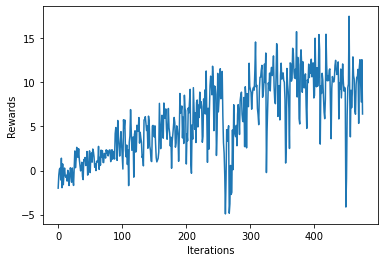

 48%|█████████████████████████████████▊                                     | 47601/100000 [4:05:53<5:38:41,  2.58it/s]

Updated Weights
Mean Reward = 6.86
30


 48%|█████████████████████████████████▊                                     | 47700/100000 [4:06:27<4:28:00,  3.25it/s]

Updated Weights
Mean Reward = 9.51
38


 48%|█████████████████████████████████▉                                     | 47801/100000 [4:07:02<5:22:45,  2.70it/s]

Updated Weights
Mean Reward = 10.35
39


 48%|██████████████████████████████████                                     | 47901/100000 [4:07:38<5:13:27,  2.77it/s]

Updated Weights
Mean Reward = 9.7
37


 48%|██████████████████████████████████                                     | 48000/100000 [4:08:15<5:37:30,  2.57it/s]

Updated Weights
Mean Reward = 8.91
31


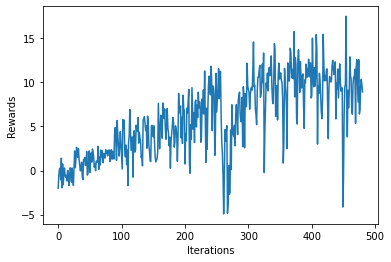

 48%|██████████████████████████████████▏                                    | 48102/100000 [4:08:47<3:57:22,  3.64it/s]

Updated Weights
Mean Reward = 7.5
42


 48%|██████████████████████████████████▏                                    | 48201/100000 [4:09:20<4:48:32,  2.99it/s]

Updated Weights
Mean Reward = 8.19
42


 48%|██████████████████████████████████▎                                    | 48301/100000 [4:09:51<4:44:05,  3.03it/s]

Updated Weights
Mean Reward = 11.95
47


 48%|██████████████████████████████████▎                                    | 48402/100000 [4:10:22<3:52:00,  3.71it/s]

Updated Weights
Mean Reward = 11.73
47


 48%|██████████████████████████████████▍                                    | 48499/100000 [4:10:54<3:51:01,  3.72it/s]

Updated Weights
Mean Reward = 12.22
49


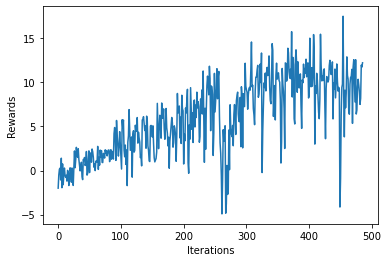

 49%|██████████████████████████████████▌                                    | 48601/100000 [4:11:32<7:18:36,  1.95it/s]

Updated Weights
Mean Reward = 10.19
38


 49%|██████████████████████████████████▌                                    | 48701/100000 [4:12:12<5:19:26,  2.68it/s]

Updated Weights
Mean Reward = 9.79
27


 49%|██████████████████████████████████▋                                    | 48801/100000 [4:12:49<5:25:52,  2.62it/s]

Updated Weights
Mean Reward = 13.51
33


 49%|██████████████████████████████████▋                                    | 48901/100000 [4:13:23<5:42:46,  2.48it/s]

Updated Weights
Mean Reward = 9.31
41


 49%|██████████████████████████████████▊                                    | 49000/100000 [4:13:57<5:04:51,  2.79it/s]

Updated Weights
Mean Reward = 10.05
41


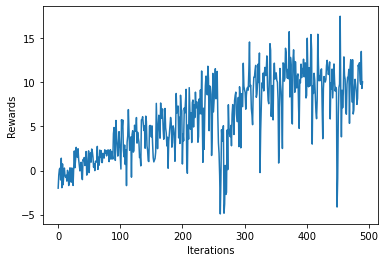

 49%|██████████████████████████████████▊                                    | 49101/100000 [4:14:28<4:44:27,  2.98it/s]

Updated Weights
Mean Reward = 12.49
53


 49%|██████████████████████████████████▉                                    | 49201/100000 [4:15:03<5:29:48,  2.57it/s]

Updated Weights
Mean Reward = 11.9
37


 49%|███████████████████████████████████                                    | 49301/100000 [4:15:39<5:55:01,  2.38it/s]

Updated Weights
Mean Reward = 10.37
36


 49%|███████████████████████████████████                                    | 49401/100000 [4:16:11<5:09:23,  2.73it/s]

Updated Weights
Mean Reward = 7.24
42


 50%|███████████████████████████████████▏                                   | 49500/100000 [4:16:44<4:54:15,  2.86it/s]

Updated Weights
Mean Reward = 11.2
45


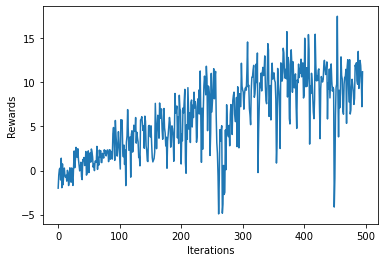

 50%|███████████████████████████████████▏                                   | 49601/100000 [4:17:17<5:49:03,  2.41it/s]

Updated Weights
Mean Reward = 16.54
46


 50%|███████████████████████████████████▎                                   | 49701/100000 [4:17:54<4:53:03,  2.86it/s]

Updated Weights
Mean Reward = 7.24
30


 50%|███████████████████████████████████▎                                   | 49801/100000 [4:18:35<5:32:43,  2.51it/s]

Updated Weights
Mean Reward = 8.59
19


 50%|███████████████████████████████████▍                                   | 49901/100000 [4:19:10<4:44:34,  2.93it/s]

Updated Weights
Mean Reward = 10.33
32


 50%|███████████████████████████████████▌                                   | 50000/100000 [4:19:41<5:03:55,  2.74it/s]

Updated Weights
Mean Reward = 10.73
43


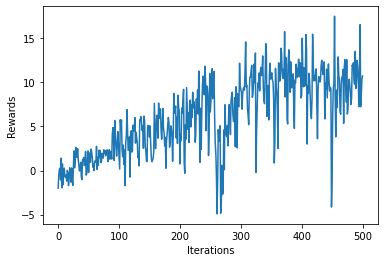

 50%|███████████████████████████████████▌                                   | 50101/100000 [4:20:12<5:20:51,  2.59it/s]

Updated Weights
Mean Reward = 11.92
57


 50%|███████████████████████████████████▋                                   | 50202/100000 [4:20:47<3:16:42,  4.22it/s]

Updated Weights
Mean Reward = 8.06
37


 50%|███████████████████████████████████▋                                   | 50301/100000 [4:21:23<5:59:05,  2.31it/s]

Updated Weights
Mean Reward = 8.92
32


 50%|███████████████████████████████████▊                                   | 50401/100000 [4:22:01<5:39:50,  2.43it/s]

Updated Weights
Mean Reward = 15.98
25


 50%|███████████████████████████████████▊                                   | 50500/100000 [4:22:36<5:13:09,  2.63it/s]

Updated Weights
Mean Reward = 9.98
32


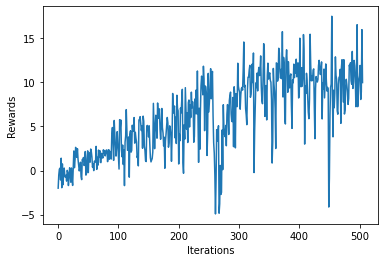

 51%|███████████████████████████████████▉                                   | 50601/100000 [4:23:15<5:43:07,  2.40it/s]

Updated Weights
Mean Reward = 10.81
28


 51%|███████████████████████████████████▉                                   | 50701/100000 [4:23:49<4:36:45,  2.97it/s]

Updated Weights
Mean Reward = 10.86
44


 51%|████████████████████████████████████                                   | 50801/100000 [4:24:23<5:31:58,  2.47it/s]

Updated Weights
Mean Reward = 9.67
41


 51%|████████████████████████████████████▏                                  | 50900/100000 [4:24:57<3:25:37,  3.98it/s]

Updated Weights
Mean Reward = 12.27
39


 51%|████████████████████████████████████▏                                  | 51000/100000 [4:25:32<5:14:41,  2.60it/s]

Updated Weights
Mean Reward = 13.71
38


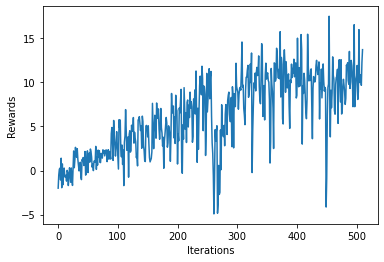

 51%|████████████████████████████████████▎                                  | 51101/100000 [4:26:07<3:49:43,  3.55it/s]

Updated Weights
Mean Reward = 7.16
37


 51%|████████████████████████████████████▎                                  | 51201/100000 [4:26:41<6:07:04,  2.22it/s]

Updated Weights
Mean Reward = 9.23
45


 51%|████████████████████████████████████▍                                  | 51301/100000 [4:27:11<3:32:55,  3.81it/s]

Updated Weights
Mean Reward = 11.46
49


 51%|████████████████████████████████████▍                                  | 51401/100000 [4:27:42<4:04:37,  3.31it/s]

Updated Weights
Mean Reward = 11.78
50


 52%|████████████████████████████████████▌                                  | 51500/100000 [4:28:21<5:37:02,  2.40it/s]

Updated Weights
Mean Reward = 8.62
21


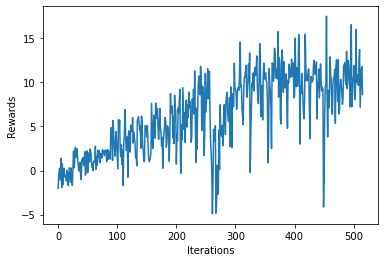

 52%|████████████████████████████████████▋                                  | 51601/100000 [4:29:00<5:43:22,  2.35it/s]

Updated Weights
Mean Reward = 4.37
26


 52%|████████████████████████████████████▋                                  | 51701/100000 [4:29:42<5:59:17,  2.24it/s]

Updated Weights
Mean Reward = 4.58
22


 52%|████████████████████████████████████▊                                  | 51801/100000 [4:30:21<5:48:39,  2.30it/s]

Updated Weights
Mean Reward = 7.95
28


 52%|████████████████████████████████████▊                                  | 51901/100000 [4:31:10<7:02:20,  1.90it/s]

Updated Weights
Mean Reward = 9.37
32


 52%|████████████████████████████████████▉                                  | 52000/100000 [4:31:51<4:43:14,  2.82it/s]

Updated Weights
Mean Reward = 12.09
24


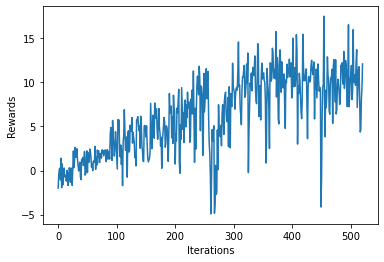

 52%|████████████████████████████████████▉                                  | 52101/100000 [4:32:29<5:33:36,  2.39it/s]

Updated Weights
Mean Reward = 13.23
29


 52%|█████████████████████████████████████                                  | 52202/100000 [4:33:01<2:32:04,  5.24it/s]

Updated Weights
Mean Reward = 10.91
49


 52%|█████████████████████████████████████▏                                 | 52302/100000 [4:33:36<4:30:20,  2.94it/s]

Updated Weights
Mean Reward = 9.0
36


 52%|█████████████████████████████████████▏                                 | 52401/100000 [4:34:13<4:12:35,  3.14it/s]

Updated Weights
Mean Reward = 13.89
31


 52%|█████████████████████████████████████▎                                 | 52500/100000 [4:34:49<3:58:12,  3.32it/s]

Updated Weights
Mean Reward = 10.9
35


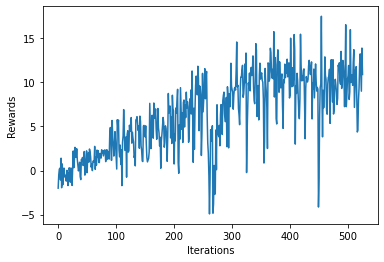

 53%|█████████████████████████████████████▎                                 | 52601/100000 [4:35:24<4:47:01,  2.75it/s]

Updated Weights
Mean Reward = 11.5
41


 53%|█████████████████████████████████████▍                                 | 52701/100000 [4:35:58<5:12:04,  2.53it/s]

Updated Weights
Mean Reward = 12.96
40


 53%|█████████████████████████████████████▍                                 | 52801/100000 [4:36:39<5:25:07,  2.42it/s]

Updated Weights
Mean Reward = 8.76
19


 53%|█████████████████████████████████████▌                                 | 52902/100000 [4:37:14<3:55:58,  3.33it/s]

Updated Weights
Mean Reward = 9.99
43


 53%|█████████████████████████████████████▋                                 | 53000/100000 [4:37:54<4:37:24,  2.82it/s]

Updated Weights
Mean Reward = 9.02
42


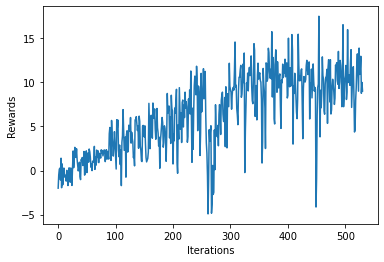

 53%|█████████████████████████████████████▋                                 | 53101/100000 [4:38:27<3:22:05,  3.87it/s]

Updated Weights
Mean Reward = 11.53
47


 53%|█████████████████████████████████████▊                                 | 53201/100000 [4:39:00<5:03:17,  2.57it/s]

Updated Weights
Mean Reward = 9.03
44


 53%|█████████████████████████████████████▊                                 | 53301/100000 [4:39:36<5:12:26,  2.49it/s]

Updated Weights
Mean Reward = 13.49
36


 53%|█████████████████████████████████████▉                                 | 53401/100000 [4:40:11<4:45:50,  2.72it/s]

Updated Weights
Mean Reward = 10.89
38


 54%|█████████████████████████████████████▉                                 | 53500/100000 [4:40:44<4:14:51,  3.04it/s]

Updated Weights
Mean Reward = 10.92
46


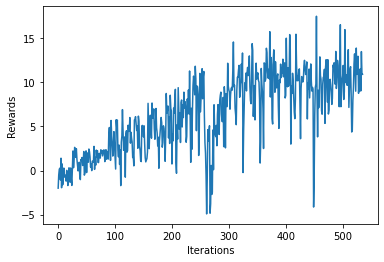

 54%|██████████████████████████████████████                                 | 53601/100000 [4:41:29<3:46:51,  3.41it/s]

Updated Weights
Mean Reward = 11.02
37


 54%|██████████████████████████████████████▏                                | 53702/100000 [4:42:05<4:03:09,  3.17it/s]

Updated Weights
Mean Reward = 13.74
34


 54%|██████████████████████████████████████▏                                | 53801/100000 [4:42:37<4:01:08,  3.19it/s]

Updated Weights
Mean Reward = 9.61
48


 54%|██████████████████████████████████████▎                                | 53901/100000 [4:43:12<3:43:33,  3.44it/s]

Updated Weights
Mean Reward = 10.88
37


 54%|██████████████████████████████████████▎                                | 54000/100000 [4:43:49<5:01:26,  2.54it/s]

Updated Weights
Mean Reward = 9.27
32


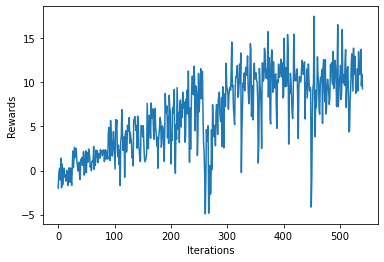

 54%|██████████████████████████████████████▍                                | 54101/100000 [4:44:27<3:53:16,  3.28it/s]

Updated Weights
Mean Reward = 11.79
25


 54%|██████████████████████████████████████▍                                | 54201/100000 [4:45:09<6:37:26,  1.92it/s]

Updated Weights
Mean Reward = 7.04
26


 54%|██████████████████████████████████████▌                                | 54301/100000 [4:45:47<3:48:45,  3.33it/s]

Updated Weights
Mean Reward = 6.68
40


 54%|██████████████████████████████████████▌                                | 54401/100000 [4:46:25<5:07:28,  2.47it/s]

Updated Weights
Mean Reward = 13.56
33


 55%|██████████████████████████████████████▋                                | 54500/100000 [4:47:10<5:37:08,  2.25it/s]

Updated Weights
Mean Reward = 10.15
38


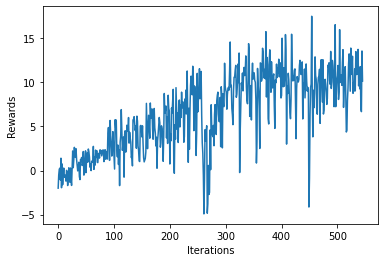

 55%|██████████████████████████████████████▊                                | 54601/100000 [4:47:46<4:31:40,  2.79it/s]

Updated Weights
Mean Reward = 10.97
39


 55%|██████████████████████████████████████▊                                | 54701/100000 [4:48:24<4:31:21,  2.78it/s]

Updated Weights
Mean Reward = 14.19
30


 55%|██████████████████████████████████████▉                                | 54801/100000 [4:49:00<5:40:43,  2.21it/s]

Updated Weights
Mean Reward = 12.87
33


 55%|██████████████████████████████████████▉                                | 54901/100000 [4:49:50<8:37:24,  1.45it/s]

Updated Weights
Mean Reward = 5.85
15


 55%|███████████████████████████████████████                                | 55000/100000 [4:50:36<5:39:14,  2.21it/s]

Updated Weights
Mean Reward = 3.98
15


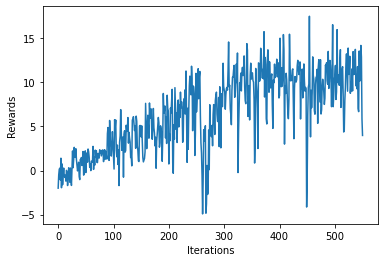

 55%|███████████████████████████████████████                                | 55101/100000 [4:51:16<5:17:10,  2.36it/s]

Updated Weights
Mean Reward = 10.65
22


 55%|███████████████████████████████████████▏                               | 55201/100000 [4:51:57<5:02:51,  2.47it/s]

Updated Weights
Mean Reward = 4.0
22


 55%|███████████████████████████████████████▎                               | 55301/100000 [4:52:36<4:43:54,  2.62it/s]

Updated Weights
Mean Reward = 8.57
25


 55%|███████████████████████████████████████▎                               | 55401/100000 [4:53:20<7:42:42,  1.61it/s]

Updated Weights
Mean Reward = 10.05
38


 56%|███████████████████████████████████████▍                               | 55500/100000 [4:54:01<5:14:56,  2.35it/s]

Updated Weights
Mean Reward = 8.49
27


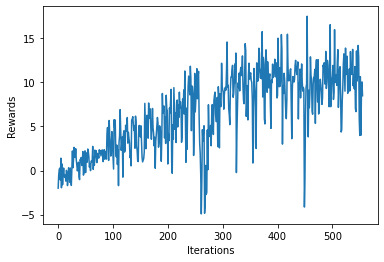

 56%|███████████████████████████████████████▍                               | 55601/100000 [4:54:39<5:45:26,  2.14it/s]

Updated Weights
Mean Reward = 10.26
32


 56%|███████████████████████████████████████▌                               | 55702/100000 [4:55:22<3:21:50,  3.66it/s]

Updated Weights
Mean Reward = 9.68
37


 56%|███████████████████████████████████████▌                               | 55801/100000 [4:56:00<4:26:19,  2.77it/s]

Updated Weights
Mean Reward = 8.85
28


 56%|███████████████████████████████████████▋                               | 55901/100000 [4:56:34<4:25:03,  2.77it/s]

Updated Weights
Mean Reward = 11.43
46


 56%|███████████████████████████████████████▊                               | 56000/100000 [4:57:06<4:57:20,  2.47it/s]

Updated Weights
Mean Reward = 11.17
49


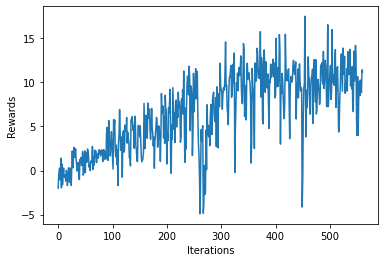

 56%|███████████████████████████████████████▊                               | 56101/100000 [4:57:41<4:54:08,  2.49it/s]

Updated Weights
Mean Reward = 11.06
44


 56%|███████████████████████████████████████▉                               | 56201/100000 [4:58:18<5:28:18,  2.22it/s]

Updated Weights
Mean Reward = 9.86
35


 56%|███████████████████████████████████████▉                               | 56301/100000 [4:58:59<7:12:03,  1.69it/s]

Updated Weights
Mean Reward = 12.0
42


 56%|████████████████████████████████████████                               | 56401/100000 [4:59:43<5:04:16,  2.39it/s]

Updated Weights
Mean Reward = 12.43
33


 56%|████████████████████████████████████████                               | 56500/100000 [5:00:20<5:15:39,  2.30it/s]

Updated Weights
Mean Reward = 9.1
33


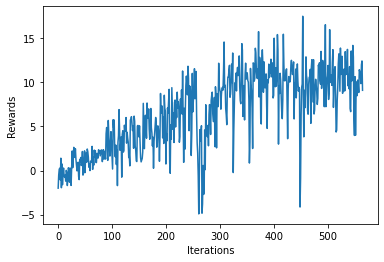

 57%|████████████████████████████████████████▏                              | 56601/100000 [5:00:57<4:17:17,  2.81it/s]

Updated Weights
Mean Reward = 12.37
28


 57%|████████████████████████████████████████▎                              | 56701/100000 [5:01:39<4:26:42,  2.71it/s]

Updated Weights
Mean Reward = 7.57
18


 57%|████████████████████████████████████████▎                              | 56801/100000 [5:02:20<4:10:08,  2.88it/s]

Updated Weights
Mean Reward = 15.28
18


 57%|████████████████████████████████████████▍                              | 56901/100000 [5:03:04<5:33:13,  2.16it/s]

Updated Weights
Mean Reward = 5.56
30


 57%|████████████████████████████████████████▍                              | 57000/100000 [5:03:46<5:22:38,  2.22it/s]

Updated Weights
Mean Reward = 9.82
17


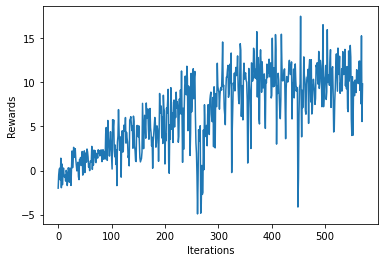

 57%|████████████████████████████████████████▌                              | 57101/100000 [5:04:24<4:24:23,  2.70it/s]

Updated Weights
Mean Reward = 9.89
34


 57%|████████████████████████████████████████▌                              | 57201/100000 [5:04:59<4:02:30,  2.94it/s]

Updated Weights
Mean Reward = 9.92
40


 57%|████████████████████████████████████████▋                              | 57301/100000 [5:05:35<5:00:40,  2.37it/s]

Updated Weights
Mean Reward = 16.34
34


 57%|████████████████████████████████████████▊                              | 57401/100000 [5:06:18<7:23:43,  1.60it/s]

Updated Weights
Mean Reward = 12.25
43


 57%|████████████████████████████████████████▊                              | 57500/100000 [5:07:12<4:13:57,  2.79it/s]

Updated Weights
Mean Reward = 12.98
37


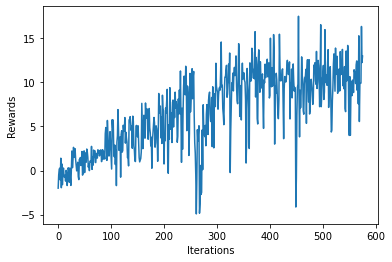

 58%|████████████████████████████████████████▉                              | 57601/100000 [5:08:22<6:18:18,  1.87it/s]

Updated Weights
Mean Reward = 13.75
25


 58%|████████████████████████████████████████▉                              | 57701/100000 [5:09:20<4:43:04,  2.49it/s]

Updated Weights
Mean Reward = 7.74
46


 58%|█████████████████████████████████████████                              | 57802/100000 [5:10:18<5:13:44,  2.24it/s]

Updated Weights
Mean Reward = 10.24
29


 58%|█████████████████████████████████████████                              | 57901/100000 [5:11:12<6:30:39,  1.80it/s]

Updated Weights
Mean Reward = 10.55
41


 58%|█████████████████████████████████████████▏                             | 58000/100000 [5:12:10<8:05:17,  1.44it/s]

Updated Weights
Mean Reward = 9.94
35


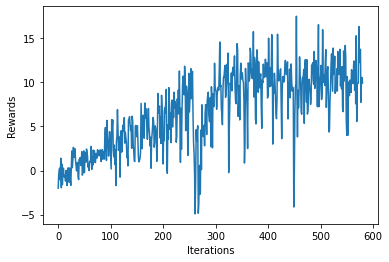

 58%|█████████████████████████████████████████▎                             | 58101/100000 [5:12:56<3:38:57,  3.19it/s]

Updated Weights
Mean Reward = 11.03
53


 58%|█████████████████████████████████████████▎                             | 58201/100000 [5:13:49<6:19:54,  1.83it/s]

Updated Weights
Mean Reward = 5.85
39


 58%|█████████████████████████████████████████▍                             | 58301/100000 [5:14:41<5:10:35,  2.24it/s]

Updated Weights
Mean Reward = 7.67
39


 58%|█████████████████████████████████████████▍                             | 58401/100000 [5:15:37<5:19:23,  2.17it/s]

Updated Weights
Mean Reward = 8.73
33


 58%|█████████████████████████████████████████▌                             | 58500/100000 [5:16:25<3:04:55,  3.74it/s]

Updated Weights
Mean Reward = 9.4
47


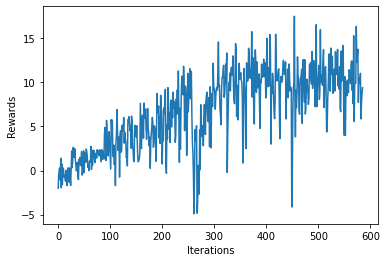

 59%|█████████████████████████████████████████▌                             | 58601/100000 [5:17:12<4:24:42,  2.61it/s]

Updated Weights
Mean Reward = 11.51
58


 59%|█████████████████████████████████████████▋                             | 58701/100000 [5:17:54<4:37:50,  2.48it/s]

Updated Weights
Mean Reward = 12.54
68


 59%|█████████████████████████████████████████▋                             | 58801/100000 [5:18:44<5:56:58,  1.92it/s]

Updated Weights
Mean Reward = 12.87
48


 59%|█████████████████████████████████████████▊                             | 58902/100000 [5:19:33<5:45:07,  1.98it/s]

Updated Weights
Mean Reward = 10.38
46


 59%|█████████████████████████████████████████▉                             | 59000/100000 [5:20:12<3:14:10,  3.52it/s]

Updated Weights
Mean Reward = 11.61
50


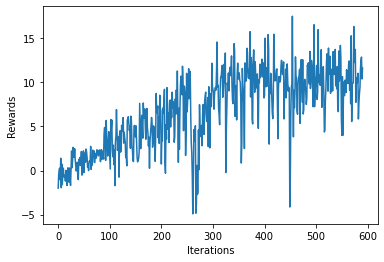

 59%|█████████████████████████████████████████▉                             | 59101/100000 [5:20:50<5:16:32,  2.15it/s]

Updated Weights
Mean Reward = 10.87
43


 59%|██████████████████████████████████████████                             | 59201/100000 [5:21:30<5:21:04,  2.12it/s]

Updated Weights
Mean Reward = 8.19
34


 59%|██████████████████████████████████████████                             | 59301/100000 [5:22:10<5:10:51,  2.18it/s]

Updated Weights
Mean Reward = 8.29
23


 59%|██████████████████████████████████████████▏                            | 59401/100000 [5:22:47<4:37:55,  2.43it/s]

Updated Weights
Mean Reward = 9.13
33


 60%|██████████████████████████████████████████▏                            | 59500/100000 [5:23:18<4:10:01,  2.70it/s]

Updated Weights
Mean Reward = 11.97
56


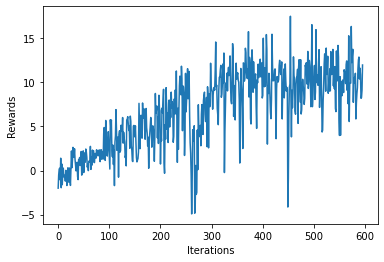

 60%|██████████████████████████████████████████▎                            | 59601/100000 [5:23:58<5:31:40,  2.03it/s]

Updated Weights
Mean Reward = 11.37
47


 60%|██████████████████████████████████████████▍                            | 59701/100000 [5:24:31<4:40:18,  2.40it/s]

Updated Weights
Mean Reward = 9.67
45


 60%|██████████████████████████████████████████▍                            | 59801/100000 [5:25:06<4:50:27,  2.31it/s]

Updated Weights
Mean Reward = 9.46
45


 60%|██████████████████████████████████████████▌                            | 59902/100000 [5:25:36<2:47:01,  4.00it/s]

Updated Weights
Mean Reward = 7.92
48


 60%|██████████████████████████████████████████▌                            | 60000/100000 [5:26:04<3:19:27,  3.34it/s]

Updated Weights
Mean Reward = 14.61
61


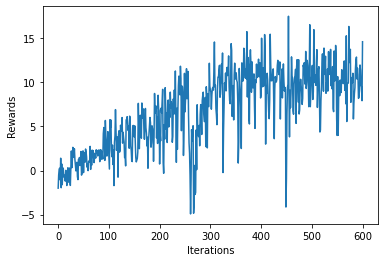

 60%|██████████████████████████████████████████▋                            | 60101/100000 [5:26:43<5:14:05,  2.12it/s]

Updated Weights
Mean Reward = 5.01
26


 60%|██████████████████████████████████████████▋                            | 60201/100000 [5:27:19<5:11:40,  2.13it/s]

Updated Weights
Mean Reward = 7.6
36


 60%|██████████████████████████████████████████▊                            | 60301/100000 [5:27:51<2:47:19,  3.95it/s]

Updated Weights
Mean Reward = 9.82
46


 60%|██████████████████████████████████████████▉                            | 60400/100000 [5:28:24<4:20:02,  2.54it/s]

Updated Weights
Mean Reward = 9.88
40


 60%|██████████████████████████████████████████▉                            | 60500/100000 [5:29:03<6:41:53,  1.64it/s]

Updated Weights
Mean Reward = 9.63
42


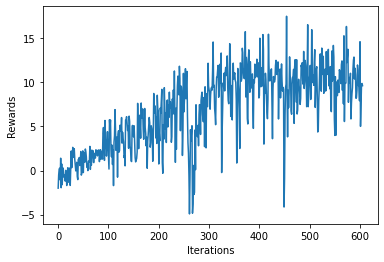

 61%|███████████████████████████████████████████                            | 60601/100000 [5:29:44<3:17:54,  3.32it/s]

Updated Weights
Mean Reward = 8.73
46


 61%|███████████████████████████████████████████                            | 60701/100000 [5:30:11<2:29:29,  4.38it/s]

Updated Weights
Mean Reward = 11.2
59


 61%|███████████████████████████████████████████▏                           | 60801/100000 [5:30:41<3:31:05,  3.09it/s]

Updated Weights
Mean Reward = 10.43
53


 61%|███████████████████████████████████████████▏                           | 60901/100000 [5:31:12<2:48:57,  3.86it/s]

Updated Weights
Mean Reward = 11.55
53


 61%|███████████████████████████████████████████▎                           | 61000/100000 [5:31:42<3:55:18,  2.76it/s]

Updated Weights
Mean Reward = 11.93
54


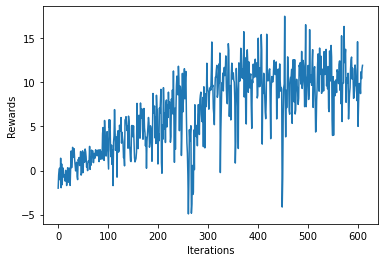

 61%|███████████████████████████████████████████▍                           | 61101/100000 [5:32:16<3:28:08,  3.11it/s]

Updated Weights
Mean Reward = 9.52
42


 61%|███████████████████████████████████████████▍                           | 61202/100000 [5:32:55<5:31:31,  1.95it/s]

Updated Weights
Mean Reward = 11.55
43


 61%|███████████████████████████████████████████▌                           | 61301/100000 [5:33:35<4:17:44,  2.50it/s]

Updated Weights
Mean Reward = 5.62
34


 61%|███████████████████████████████████████████▌                           | 61401/100000 [5:34:15<3:46:18,  2.84it/s]

Updated Weights
Mean Reward = 4.93
28


 62%|███████████████████████████████████████████▋                           | 61500/100000 [5:34:54<6:23:45,  1.67it/s]

Updated Weights
Mean Reward = 8.85
39


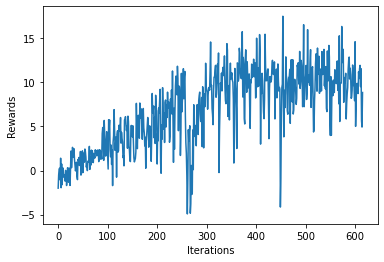

 62%|███████████████████████████████████████████▋                           | 61601/100000 [5:35:24<3:24:51,  3.12it/s]

Updated Weights
Mean Reward = 11.44
60


 62%|███████████████████████████████████████████▊                           | 61701/100000 [5:35:55<3:28:18,  3.06it/s]

Updated Weights
Mean Reward = 12.57
53


 62%|███████████████████████████████████████████▉                           | 61801/100000 [5:36:35<4:54:32,  2.16it/s]

Updated Weights
Mean Reward = 9.99
28


 62%|███████████████████████████████████████████▉                           | 61901/100000 [5:37:21<5:51:25,  1.81it/s]

Updated Weights
Mean Reward = 10.14
32


 62%|████████████████████████████████████████████                           | 62000/100000 [5:38:00<4:47:37,  2.20it/s]

Updated Weights
Mean Reward = 10.56
38


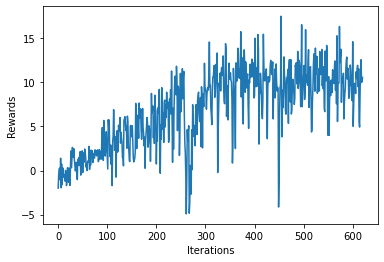

 62%|████████████████████████████████████████████                           | 62101/100000 [5:38:34<3:01:10,  3.49it/s]

Updated Weights
Mean Reward = 10.89
42


 62%|████████████████████████████████████████████▏                          | 62201/100000 [5:39:14<2:43:55,  3.84it/s]

Updated Weights
Mean Reward = 9.31
42


 62%|████████████████████████████████████████████▏                          | 62302/100000 [5:39:42<1:20:37,  7.79it/s]

Updated Weights
Mean Reward = 11.41
59


 62%|████████████████████████████████████████████▎                          | 62402/100000 [5:40:08<3:07:15,  3.35it/s]

Updated Weights
Mean Reward = 12.44
66


 62%|████████████████████████████████████████████▍                          | 62500/100000 [5:40:45<4:28:13,  2.33it/s]

Updated Weights
Mean Reward = 11.01
37


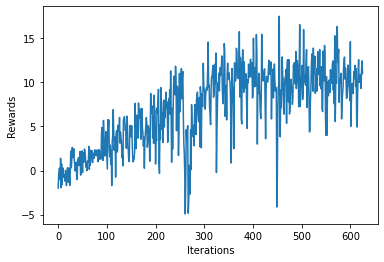

 63%|████████████████████████████████████████████▍                          | 62602/100000 [5:41:31<3:14:11,  3.21it/s]

Updated Weights
Mean Reward = 10.96
31


 63%|████████████████████████████████████████████▌                          | 62701/100000 [5:42:06<3:54:23,  2.65it/s]

Updated Weights
Mean Reward = 4.86
36


 63%|████████████████████████████████████████████▌                          | 62801/100000 [5:42:43<5:35:21,  1.85it/s]

Updated Weights
Mean Reward = 8.37
38


 63%|████████████████████████████████████████████▋                          | 62901/100000 [5:43:27<4:28:07,  2.31it/s]

Updated Weights
Mean Reward = 9.27
42


 63%|████████████████████████████████████████████▋                          | 63000/100000 [5:44:03<3:30:23,  2.93it/s]

Updated Weights
Mean Reward = 9.82
39


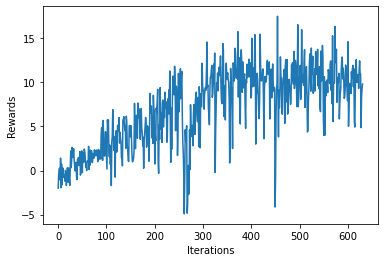

 63%|████████████████████████████████████████████▊                          | 63102/100000 [5:44:39<3:43:50,  2.75it/s]

Updated Weights
Mean Reward = 10.12
40


 63%|████████████████████████████████████████████▊                          | 63201/100000 [5:45:12<3:39:43,  2.79it/s]

Updated Weights
Mean Reward = 10.8
49


 63%|████████████████████████████████████████████▉                          | 63301/100000 [5:45:43<1:38:54,  6.18it/s]

Updated Weights
Mean Reward = 9.01
51


 63%|█████████████████████████████████████████████                          | 63401/100000 [5:46:12<4:02:47,  2.51it/s]

Updated Weights
Mean Reward = 8.77
57


 64%|█████████████████████████████████████████████                          | 63500/100000 [5:46:42<3:20:21,  3.04it/s]

Updated Weights
Mean Reward = 10.9
56


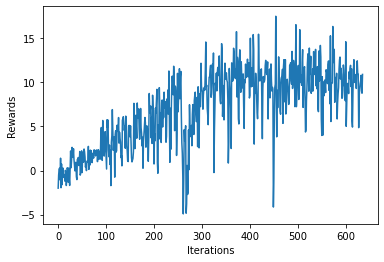

 64%|█████████████████████████████████████████████▏                         | 63601/100000 [5:47:20<3:50:02,  2.64it/s]

Updated Weights
Mean Reward = 10.06
35


 64%|█████████████████████████████████████████████▏                         | 63701/100000 [5:47:56<4:29:15,  2.25it/s]

Updated Weights
Mean Reward = 10.57
35


 64%|█████████████████████████████████████████████▎                         | 63802/100000 [5:48:25<2:15:02,  4.47it/s]

Updated Weights
Mean Reward = 11.7
55


 64%|█████████████████████████████████████████████▎                         | 63902/100000 [5:49:06<3:48:37,  2.63it/s]

Updated Weights
Mean Reward = 13.78
47


 64%|█████████████████████████████████████████████▍                         | 64000/100000 [5:49:45<4:47:18,  2.09it/s]

Updated Weights
Mean Reward = 6.93
41


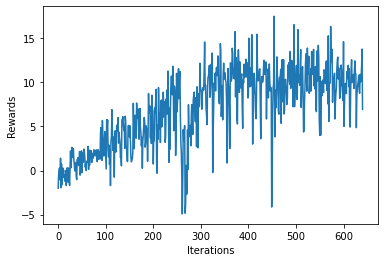

 64%|█████████████████████████████████████████████▌                         | 64101/100000 [5:50:20<5:26:06,  1.83it/s]

Updated Weights
Mean Reward = 10.97
55


 64%|█████████████████████████████████████████████▌                         | 64201/100000 [5:50:57<3:04:47,  3.23it/s]

Updated Weights
Mean Reward = 11.34
57


 64%|█████████████████████████████████████████████▋                         | 64301/100000 [5:51:33<4:14:40,  2.34it/s]

Updated Weights
Mean Reward = 7.98
37


 64%|█████████████████████████████████████████████▋                         | 64401/100000 [5:52:07<3:12:10,  3.09it/s]

Updated Weights
Mean Reward = 7.95
40


 64%|█████████████████████████████████████████████▊                         | 64500/100000 [5:52:38<3:37:11,  2.72it/s]

Updated Weights
Mean Reward = 11.58
51


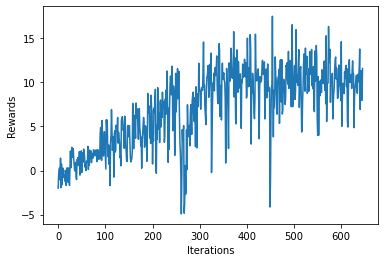

 65%|█████████████████████████████████████████████▊                         | 64601/100000 [5:53:08<3:49:58,  2.57it/s]

Updated Weights
Mean Reward = 13.86
55


 65%|█████████████████████████████████████████████▉                         | 64701/100000 [5:53:45<4:28:17,  2.19it/s]

Updated Weights
Mean Reward = 6.95
32


 65%|██████████████████████████████████████████████                         | 64802/100000 [5:54:27<2:48:45,  3.48it/s]

Updated Weights
Mean Reward = 4.21
21


 65%|██████████████████████████████████████████████                         | 64901/100000 [5:55:07<6:18:49,  1.54it/s]

Updated Weights
Mean Reward = 10.67
53


 65%|██████████████████████████████████████████████▏                        | 64999/100000 [5:55:36<2:42:01,  3.60it/s]

Updated Weights
Mean Reward = 12.47
56


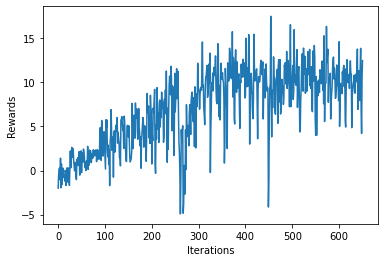

 65%|██████████████████████████████████████████████▏                        | 65101/100000 [5:56:19<3:15:22,  2.98it/s]

Updated Weights
Mean Reward = 7.01
17


 65%|██████████████████████████████████████████████▎                        | 65202/100000 [5:56:52<2:46:00,  3.49it/s]

Updated Weights
Mean Reward = 7.28
47


 65%|██████████████████████████████████████████████▎                        | 65301/100000 [5:57:38<4:56:47,  1.95it/s]

Updated Weights
Mean Reward = 4.42
21


 65%|██████████████████████████████████████████████▍                        | 65401/100000 [5:58:19<4:25:04,  2.18it/s]

Updated Weights
Mean Reward = 10.45
34


 66%|██████████████████████████████████████████████▌                        | 65500/100000 [5:58:58<3:14:20,  2.96it/s]

Updated Weights
Mean Reward = 8.39
42


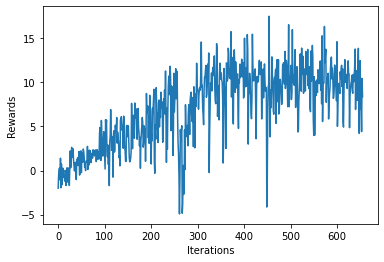

 66%|██████████████████████████████████████████████▌                        | 65601/100000 [5:59:33<3:47:13,  2.52it/s]

Updated Weights
Mean Reward = 8.13
43


 66%|██████████████████████████████████████████████▋                        | 65701/100000 [6:00:07<2:43:47,  3.49it/s]

Updated Weights
Mean Reward = 6.88
39


 66%|██████████████████████████████████████████████▋                        | 65801/100000 [6:00:49<7:09:59,  1.33it/s]

Updated Weights
Mean Reward = 11.19
30


 66%|██████████████████████████████████████████████▊                        | 65901/100000 [6:01:37<3:16:28,  2.89it/s]

Updated Weights
Mean Reward = 3.98
22


 66%|██████████████████████████████████████████████▊                        | 66000/100000 [6:02:18<4:06:25,  2.30it/s]

Updated Weights
Mean Reward = 10.57
20


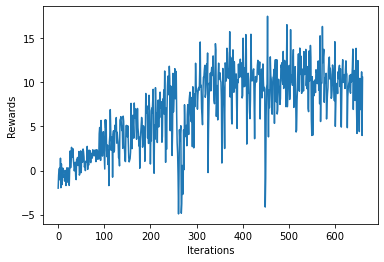

 66%|██████████████████████████████████████████████▉                        | 66100/100000 [6:03:00<3:28:26,  2.71it/s]

Updated Weights
Mean Reward = 6.44
29


 66%|███████████████████████████████████████████████                        | 66203/100000 [6:03:52<3:21:26,  2.80it/s]

Updated Weights
Mean Reward = 8.64
26


 66%|███████████████████████████████████████████████                        | 66301/100000 [6:04:32<3:53:31,  2.41it/s]

Updated Weights
Mean Reward = 9.54
32


 66%|███████████████████████████████████████████████▏                       | 66401/100000 [6:05:18<3:26:23,  2.71it/s]

Updated Weights
Mean Reward = 10.88
28


 66%|███████████████████████████████████████████████▏                       | 66500/100000 [6:05:57<2:40:17,  3.48it/s]

Updated Weights
Mean Reward = 11.55
33


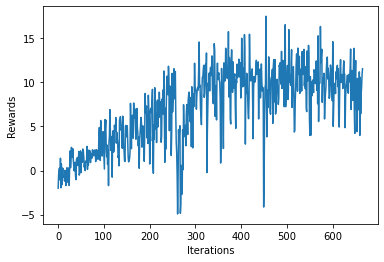

 67%|███████████████████████████████████████████████▎                       | 66601/100000 [6:06:29<4:13:25,  2.20it/s]

Updated Weights
Mean Reward = 10.85
53


 67%|███████████████████████████████████████████████▎                       | 66700/100000 [6:07:10<3:04:34,  3.01it/s]

Updated Weights
Mean Reward = 9.83
43


 67%|███████████████████████████████████████████████▍                       | 66803/100000 [6:07:42<2:22:28,  3.88it/s]

Updated Weights
Mean Reward = 11.15
54


 67%|███████████████████████████████████████████████▍                       | 66901/100000 [6:08:12<3:32:56,  2.59it/s]

Updated Weights
Mean Reward = 9.95
54


 67%|███████████████████████████████████████████████▌                       | 67000/100000 [6:08:44<2:20:11,  3.92it/s]

Updated Weights
Mean Reward = 11.27
55


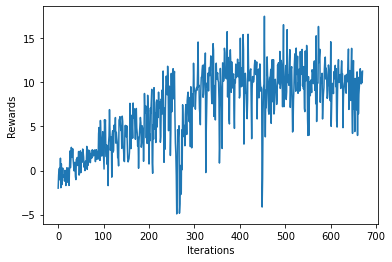

 67%|███████████████████████████████████████████████▋                       | 67101/100000 [6:09:20<2:37:39,  3.48it/s]

Updated Weights
Mean Reward = 13.04
60


 67%|███████████████████████████████████████████████▋                       | 67201/100000 [6:09:59<3:20:06,  2.73it/s]

Updated Weights
Mean Reward = 5.15
27


 67%|███████████████████████████████████████████████▊                       | 67302/100000 [6:10:42<3:57:35,  2.29it/s]

Updated Weights
Mean Reward = -1.24
16


 67%|███████████████████████████████████████████████▊                       | 67400/100000 [6:11:30<3:48:52,  2.37it/s]

Updated Weights
Mean Reward = 7.19
23


 68%|███████████████████████████████████████████████▉                       | 67500/100000 [6:12:06<3:08:06,  2.88it/s]

Updated Weights
Mean Reward = 14.31
34


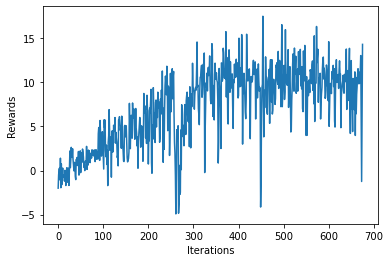

 68%|███████████████████████████████████████████████▉                       | 67602/100000 [6:12:39<1:49:24,  4.94it/s]

Updated Weights
Mean Reward = 8.14
46


 68%|████████████████████████████████████████████████                       | 67701/100000 [6:13:17<3:14:50,  2.76it/s]

Updated Weights
Mean Reward = 7.49
46


 68%|████████████████████████████████████████████████▏                      | 67802/100000 [6:13:46<2:02:11,  4.39it/s]

Updated Weights
Mean Reward = 9.29
52


 68%|████████████████████████████████████████████████▏                      | 67902/100000 [6:14:16<2:47:28,  3.19it/s]

Updated Weights
Mean Reward = 9.94
53


 68%|████████████████████████████████████████████████▎                      | 68000/100000 [6:14:48<2:36:59,  3.40it/s]

Updated Weights
Mean Reward = 10.25
55


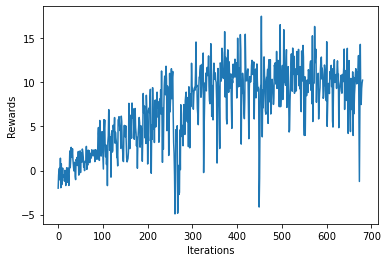

 68%|████████████████████████████████████████████████▎                      | 68101/100000 [6:15:23<2:28:18,  3.58it/s]

Updated Weights
Mean Reward = 9.37
48


 68%|████████████████████████████████████████████████▍                      | 68201/100000 [6:15:54<3:14:12,  2.73it/s]

Updated Weights
Mean Reward = 9.29
51


 68%|████████████████████████████████████████████████▍                      | 68302/100000 [6:16:25<2:45:52,  3.19it/s]

Updated Weights
Mean Reward = 10.21
50


 68%|████████████████████████████████████████████████▌                      | 68401/100000 [6:16:54<3:16:40,  2.68it/s]

Updated Weights
Mean Reward = 9.3
52


 68%|████████████████████████████████████████████████▋                      | 68500/100000 [6:17:24<3:46:49,  2.31it/s]

Updated Weights
Mean Reward = 10.55
52


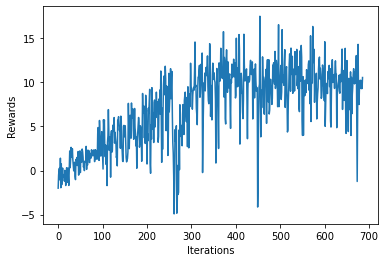

 69%|████████████████████████████████████████████████▋                      | 68601/100000 [6:17:57<2:51:12,  3.06it/s]

Updated Weights
Mean Reward = 10.06
50


 69%|████████████████████████████████████████████████▊                      | 68702/100000 [6:18:25<2:04:05,  4.20it/s]

Updated Weights
Mean Reward = 10.81
59


 69%|████████████████████████████████████████████████▊                      | 68801/100000 [6:19:04<4:06:42,  2.11it/s]

Updated Weights
Mean Reward = 7.17
49


 69%|████████████████████████████████████████████████▉                      | 68901/100000 [6:19:42<3:51:41,  2.24it/s]

Updated Weights
Mean Reward = 10.52
41


 69%|████████████████████████████████████████████████▉                      | 69000/100000 [6:20:17<3:58:22,  2.17it/s]

Updated Weights
Mean Reward = 8.89
41


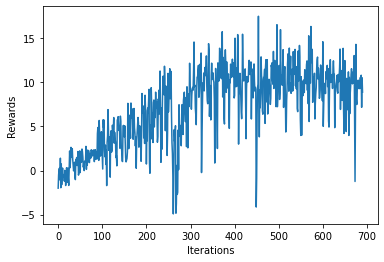

 69%|█████████████████████████████████████████████████                      | 69101/100000 [6:21:03<3:31:00,  2.44it/s]

Updated Weights
Mean Reward = 8.38
35


 69%|█████████████████████████████████████████████████▏                     | 69201/100000 [6:21:46<3:12:00,  2.67it/s]

Updated Weights
Mean Reward = 8.45
19


 69%|█████████████████████████████████████████████████▏                     | 69301/100000 [6:22:27<4:03:09,  2.10it/s]

Updated Weights
Mean Reward = 5.44
22


 69%|█████████████████████████████████████████████████▎                     | 69401/100000 [6:23:04<3:36:43,  2.35it/s]

Updated Weights
Mean Reward = 14.4
38


 70%|█████████████████████████████████████████████████▎                     | 69500/100000 [6:23:42<2:38:35,  3.21it/s]

Updated Weights
Mean Reward = 7.67
33


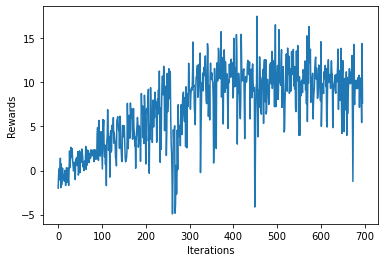

 70%|█████████████████████████████████████████████████▍                     | 69601/100000 [6:24:18<3:01:45,  2.79it/s]

Updated Weights
Mean Reward = 8.62
38


 70%|█████████████████████████████████████████████████▍                     | 69702/100000 [6:24:54<3:03:00,  2.76it/s]

Updated Weights
Mean Reward = 9.31
37


 70%|█████████████████████████████████████████████████▌                     | 69802/100000 [6:25:22<2:38:24,  3.18it/s]

Updated Weights
Mean Reward = 10.06
57


 70%|█████████████████████████████████████████████████▋                     | 69902/100000 [6:25:52<2:49:48,  2.95it/s]

Updated Weights
Mean Reward = 7.47
49


 70%|█████████████████████████████████████████████████▋                     | 70000/100000 [6:26:20<2:45:30,  3.02it/s]

Updated Weights
Mean Reward = 8.6
57


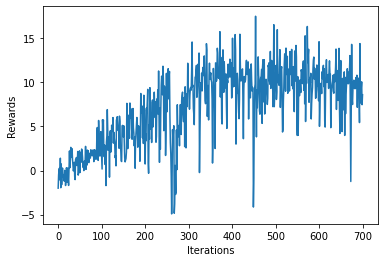

 70%|█████████████████████████████████████████████████▊                     | 70102/100000 [6:27:02<4:09:52,  1.99it/s]

Updated Weights
Mean Reward = 7.88
42


 70%|█████████████████████████████████████████████████▊                     | 70201/100000 [6:27:35<2:27:55,  3.36it/s]

Updated Weights
Mean Reward = 8.95
47


 70%|█████████████████████████████████████████████████▉                     | 70302/100000 [6:28:07<2:17:47,  3.59it/s]

Updated Weights
Mean Reward = 9.59
47


 70%|█████████████████████████████████████████████████▉                     | 70402/100000 [6:28:40<2:10:17,  3.79it/s]

Updated Weights
Mean Reward = 10.37
52


 70%|██████████████████████████████████████████████████                     | 70500/100000 [6:29:09<2:32:40,  3.22it/s]

Updated Weights
Mean Reward = 10.53
53


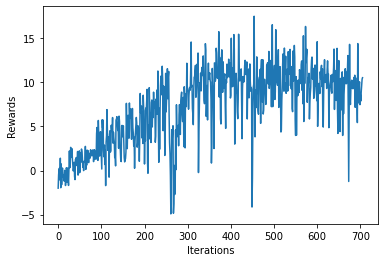

 71%|██████████████████████████████████████████████████▏                    | 70601/100000 [6:29:48<3:07:56,  2.61it/s]

Updated Weights
Mean Reward = 11.26
53


 71%|██████████████████████████████████████████████████▏                    | 70701/100000 [6:30:20<2:35:28,  3.14it/s]

Updated Weights
Mean Reward = 11.07
56


 71%|██████████████████████████████████████████████████▎                    | 70801/100000 [6:30:54<2:35:39,  3.13it/s]

Updated Weights
Mean Reward = 14.23
49


 71%|██████████████████████████████████████████████████▎                    | 70901/100000 [6:31:30<3:07:17,  2.59it/s]

Updated Weights
Mean Reward = 6.45
34


 71%|██████████████████████████████████████████████████▍                    | 71000/100000 [6:32:07<2:43:47,  2.95it/s]

Updated Weights
Mean Reward = 4.16
32


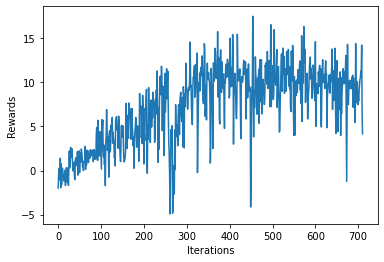

 71%|██████████████████████████████████████████████████▍                    | 71101/100000 [6:32:44<4:06:28,  1.95it/s]

Updated Weights
Mean Reward = 8.52
37


 71%|██████████████████████████████████████████████████▌                    | 71200/100000 [6:33:25<2:13:04,  3.61it/s]

Updated Weights
Mean Reward = 11.81
41


 71%|██████████████████████████████████████████████████▌                    | 71301/100000 [6:33:54<2:18:20,  3.46it/s]

Updated Weights
Mean Reward = 10.74
55


 71%|██████████████████████████████████████████████████▋                    | 71401/100000 [6:34:29<3:23:21,  2.34it/s]

Updated Weights
Mean Reward = 8.36
42


 71%|██████████████████████████████████████████████████▊                    | 71499/100000 [6:35:13<3:40:06,  2.16it/s]

Updated Weights
Mean Reward = 7.63
36


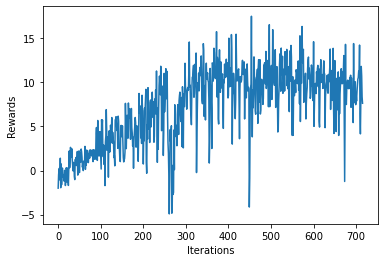

 72%|██████████████████████████████████████████████████▊                    | 71601/100000 [6:35:54<3:18:46,  2.38it/s]

Updated Weights
Mean Reward = 7.3
29


 72%|██████████████████████████████████████████████████▉                    | 71701/100000 [6:36:34<3:40:29,  2.14it/s]

Updated Weights
Mean Reward = 7.55
24


 72%|██████████████████████████████████████████████████▉                    | 71801/100000 [6:37:18<3:31:55,  2.22it/s]

Updated Weights
Mean Reward = 12.07
25


 72%|███████████████████████████████████████████████████                    | 71902/100000 [6:38:01<2:47:01,  2.80it/s]

Updated Weights
Mean Reward = 5.92
25


 72%|███████████████████████████████████████████████████                    | 72000/100000 [6:38:37<3:08:17,  2.48it/s]

Updated Weights
Mean Reward = 9.85
34


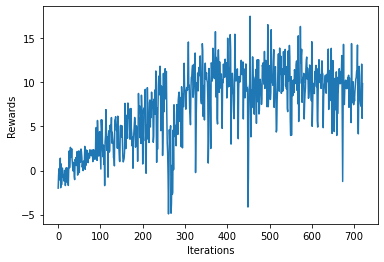

 72%|███████████████████████████████████████████████████▏                   | 72101/100000 [6:39:26<2:34:34,  3.01it/s]

Updated Weights
Mean Reward = 7.98
28


 72%|███████████████████████████████████████████████████▎                   | 72201/100000 [6:40:05<3:06:31,  2.48it/s]

Updated Weights
Mean Reward = 8.32
30


 72%|███████████████████████████████████████████████████▎                   | 72301/100000 [6:40:50<5:41:56,  1.35it/s]

Updated Weights
Mean Reward = 7.6
27


 72%|███████████████████████████████████████████████████▍                   | 72401/100000 [6:41:37<3:23:17,  2.26it/s]

Updated Weights
Mean Reward = 7.38
32


 72%|███████████████████████████████████████████████████▍                   | 72500/100000 [6:42:18<2:37:40,  2.91it/s]

Updated Weights
Mean Reward = 7.69
29


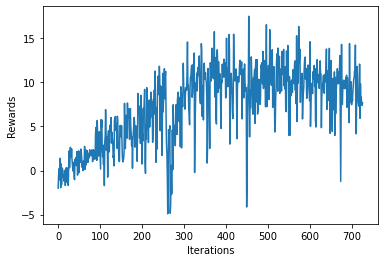

 73%|███████████████████████████████████████████████████▌                   | 72602/100000 [6:43:10<2:45:14,  2.76it/s]

Updated Weights
Mean Reward = 6.02
18


 73%|███████████████████████████████████████████████████▌                   | 72701/100000 [6:43:43<2:46:08,  2.74it/s]

Updated Weights
Mean Reward = 9.04
44


 73%|███████████████████████████████████████████████████▋                   | 72802/100000 [6:44:17<2:06:56,  3.57it/s]

Updated Weights
Mean Reward = 9.64
44


 73%|███████████████████████████████████████████████████▊                   | 72901/100000 [6:44:52<3:09:10,  2.39it/s]

Updated Weights
Mean Reward = 10.94
56


 73%|███████████████████████████████████████████████████▊                   | 73000/100000 [6:45:30<3:02:53,  2.46it/s]

Updated Weights
Mean Reward = 9.2
41


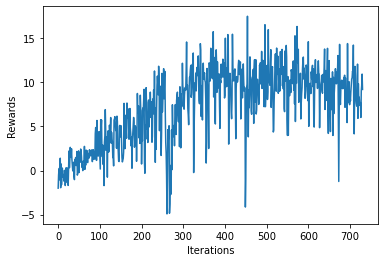

 73%|███████████████████████████████████████████████████▉                   | 73102/100000 [6:46:02<1:28:37,  5.06it/s]

Updated Weights
Mean Reward = 10.48
49


 73%|███████████████████████████████████████████████████▉                   | 73203/100000 [6:46:40<2:50:31,  2.62it/s]

Updated Weights
Mean Reward = 12.68
33


 73%|████████████████████████████████████████████████████                   | 73301/100000 [6:47:22<3:29:19,  2.13it/s]

Updated Weights
Mean Reward = 6.28
30


 73%|████████████████████████████████████████████████████                   | 73401/100000 [6:47:59<1:46:27,  4.16it/s]

Updated Weights
Mean Reward = 9.43
34


 74%|████████████████████████████████████████████████████▏                  | 73500/100000 [6:48:33<2:20:07,  3.15it/s]

Updated Weights
Mean Reward = 9.53
42


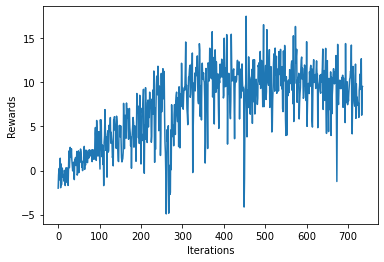

 74%|████████████████████████████████████████████████████▎                  | 73601/100000 [6:49:12<2:13:36,  3.29it/s]

Updated Weights
Mean Reward = 9.9
45


 74%|████████████████████████████████████████████████████▎                  | 73701/100000 [6:49:50<3:11:30,  2.29it/s]

Updated Weights
Mean Reward = 10.28
35


 74%|████████████████████████████████████████████████████▍                  | 73802/100000 [6:50:29<2:20:09,  3.12it/s]

Updated Weights
Mean Reward = 7.84
31


 74%|████████████████████████████████████████████████████▍                  | 73902/100000 [6:51:07<2:14:48,  3.23it/s]

Updated Weights
Mean Reward = 9.98
41


 74%|████████████████████████████████████████████████████▌                  | 74000/100000 [6:51:41<2:14:20,  3.23it/s]

Updated Weights
Mean Reward = 9.44
44


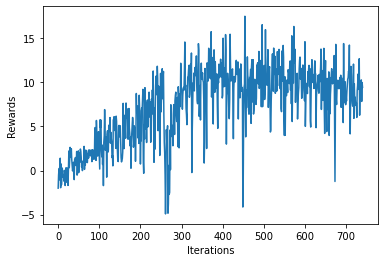

 74%|████████████████████████████████████████████████████▌                  | 74101/100000 [6:52:16<3:13:51,  2.23it/s]

Updated Weights
Mean Reward = 9.2
41


 74%|████████████████████████████████████████████████████▋                  | 74200/100000 [6:52:54<2:12:08,  3.25it/s]

Updated Weights
Mean Reward = 15.4
43


 74%|████████████████████████████████████████████████████▊                  | 74301/100000 [6:53:35<3:05:31,  2.31it/s]

Updated Weights
Mean Reward = 11.52
29


 74%|████████████████████████████████████████████████████▊                  | 74401/100000 [6:54:14<2:32:04,  2.81it/s]

Updated Weights
Mean Reward = 9.75
27


 74%|████████████████████████████████████████████████████▉                  | 74500/100000 [6:55:00<3:49:11,  1.85it/s]

Updated Weights
Mean Reward = 12.91
32


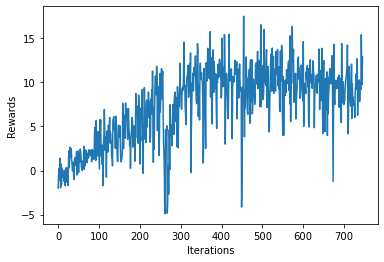

 75%|████████████████████████████████████████████████████▉                  | 74602/100000 [6:55:36<2:26:56,  2.88it/s]

Updated Weights
Mean Reward = 9.36
42


 75%|█████████████████████████████████████████████████████                  | 74701/100000 [6:56:08<2:34:19,  2.73it/s]

Updated Weights
Mean Reward = 9.75
46


 75%|█████████████████████████████████████████████████████                  | 74801/100000 [6:56:37<1:48:15,  3.88it/s]

Updated Weights
Mean Reward = 10.4
56


 75%|█████████████████████████████████████████████████████▏                 | 74901/100000 [6:57:18<2:14:56,  3.10it/s]

Updated Weights
Mean Reward = 6.88
34


 75%|█████████████████████████████████████████████████████▎                 | 75000/100000 [6:57:49<2:45:18,  2.52it/s]

Updated Weights
Mean Reward = 5.25
46


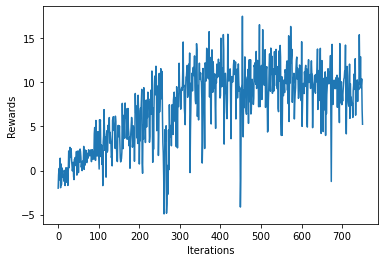

 75%|█████████████████████████████████████████████████████▎                 | 75102/100000 [6:58:18<1:35:19,  4.35it/s]

Updated Weights
Mean Reward = 10.17
60


 75%|█████████████████████████████████████████████████████▍                 | 75201/100000 [6:58:49<1:53:19,  3.65it/s]

Updated Weights
Mean Reward = 9.29
51


 75%|█████████████████████████████████████████████████████▍                 | 75303/100000 [6:59:19<1:15:34,  5.45it/s]

Updated Weights
Mean Reward = 9.96
59


 75%|█████████████████████████████████████████████████████▌                 | 75402/100000 [6:59:49<2:31:00,  2.71it/s]

Updated Weights
Mean Reward = 8.72
53


 76%|█████████████████████████████████████████████████████▌                 | 75500/100000 [7:00:24<2:52:22,  2.37it/s]

Updated Weights
Mean Reward = 10.71
39


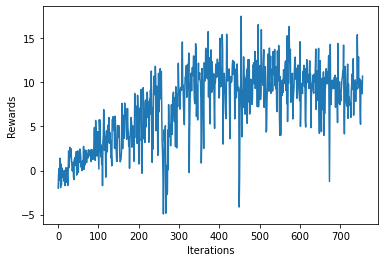

 76%|█████████████████████████████████████████████████████▋                 | 75601/100000 [7:01:04<2:37:45,  2.58it/s]

Updated Weights
Mean Reward = 7.04
39


 76%|█████████████████████████████████████████████████████▋                 | 75702/100000 [7:01:43<2:08:32,  3.15it/s]

Updated Weights
Mean Reward = 5.12
31


 76%|█████████████████████████████████████████████████████▊                 | 75802/100000 [7:02:17<2:04:54,  3.23it/s]

Updated Weights
Mean Reward = 7.92
41


 76%|█████████████████████████████████████████████████████▉                 | 75901/100000 [7:02:50<2:12:06,  3.04it/s]

Updated Weights
Mean Reward = 8.9
49


 76%|█████████████████████████████████████████████████████▉                 | 76000/100000 [7:03:23<2:15:46,  2.95it/s]

Updated Weights
Mean Reward = 8.64
41


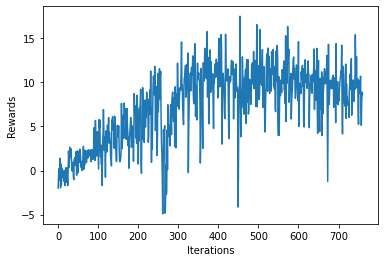

 76%|██████████████████████████████████████████████████████                 | 76101/100000 [7:03:51<2:27:43,  2.70it/s]

Updated Weights
Mean Reward = 10.54
60


 76%|██████████████████████████████████████████████████████                 | 76201/100000 [7:04:26<3:03:18,  2.16it/s]

Updated Weights
Mean Reward = 11.44
40


 76%|██████████████████████████████████████████████████████▏                | 76301/100000 [7:05:04<1:55:57,  3.41it/s]

Updated Weights
Mean Reward = 7.03
44


 76%|██████████████████████████████████████████████████████▏                | 76402/100000 [7:05:39<1:38:53,  3.98it/s]

Updated Weights
Mean Reward = 8.53
41


 76%|██████████████████████████████████████████████████████▎                | 76500/100000 [7:06:06<1:57:10,  3.34it/s]

Updated Weights
Mean Reward = 10.67
58


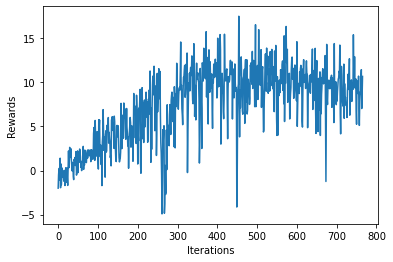

 77%|██████████████████████████████████████████████████████▍                | 76602/100000 [7:06:39<2:32:26,  2.56it/s]

Updated Weights
Mean Reward = 8.81
46


 77%|██████████████████████████████████████████████████████▍                | 76702/100000 [7:07:08<1:52:15,  3.46it/s]

Updated Weights
Mean Reward = 11.99
59


 77%|██████████████████████████████████████████████████████▌                | 76801/100000 [7:07:39<2:20:28,  2.75it/s]

Updated Weights
Mean Reward = 11.29
51


 77%|██████████████████████████████████████████████████████▌                | 76901/100000 [7:08:15<2:04:55,  3.08it/s]

Updated Weights
Mean Reward = 5.46
36


 77%|██████████████████████████████████████████████████████▋                | 77000/100000 [7:08:46<2:36:09,  2.45it/s]

Updated Weights
Mean Reward = 9.68
50


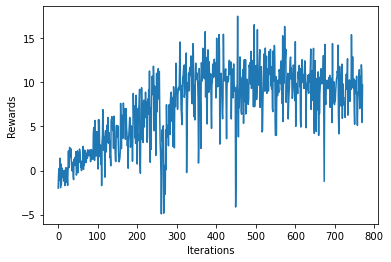

 77%|██████████████████████████████████████████████████████▋                | 77101/100000 [7:09:17<2:27:29,  2.59it/s]

Updated Weights
Mean Reward = 10.27
53


 77%|██████████████████████████████████████████████████████▊                | 77200/100000 [7:09:53<2:48:50,  2.25it/s]

Updated Weights
Mean Reward = 8.31
37


 77%|██████████████████████████████████████████████████████▉                | 77300/100000 [7:10:27<1:29:00,  4.25it/s]

Updated Weights
Mean Reward = 8.92
42


 77%|██████████████████████████████████████████████████████▉                | 77400/100000 [7:10:59<2:51:08,  2.20it/s]

Updated Weights
Mean Reward = 11.66
53


 78%|███████████████████████████████████████████████████████                | 77500/100000 [7:11:40<2:43:05,  2.30it/s]

Updated Weights
Mean Reward = 7.55
25


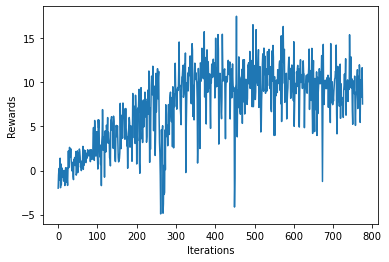

 78%|███████████████████████████████████████████████████████                | 77601/100000 [7:12:18<2:16:37,  2.73it/s]

Updated Weights
Mean Reward = 5.38
36


 78%|███████████████████████████████████████████████████████▏               | 77701/100000 [7:12:53<2:44:11,  2.26it/s]

Updated Weights
Mean Reward = 9.13
41


 78%|███████████████████████████████████████████████████████▏               | 77801/100000 [7:13:28<1:54:36,  3.23it/s]

Updated Weights
Mean Reward = 8.78
42


 78%|███████████████████████████████████████████████████████▎               | 77902/100000 [7:14:00<1:05:54,  5.59it/s]

Updated Weights
Mean Reward = 9.3
49


 78%|███████████████████████████████████████████████████████▍               | 78000/100000 [7:14:32<2:27:34,  2.48it/s]

Updated Weights
Mean Reward = 9.43
49


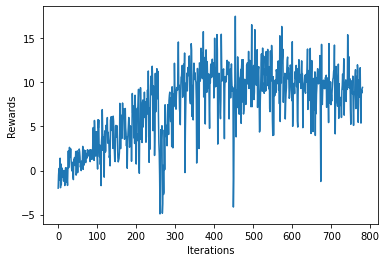

 78%|███████████████████████████████████████████████████████▍               | 78101/100000 [7:15:06<1:35:08,  3.84it/s]

Updated Weights
Mean Reward = 9.92
53


 78%|███████████████████████████████████████████████████████▌               | 78202/100000 [7:15:37<1:25:42,  4.24it/s]

Updated Weights
Mean Reward = 8.04
47


 78%|███████████████████████████████████████████████████████▌               | 78302/100000 [7:16:10<1:19:26,  4.55it/s]

Updated Weights
Mean Reward = 8.43
44


 78%|███████████████████████████████████████████████████████▋               | 78401/100000 [7:16:40<2:41:15,  2.23it/s]

Updated Weights
Mean Reward = 9.96
53


 78%|███████████████████████████████████████████████████████▋               | 78500/100000 [7:17:13<2:37:29,  2.28it/s]

Updated Weights
Mean Reward = 9.08
46


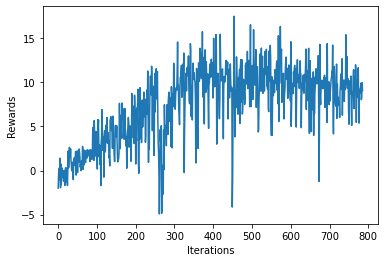

 79%|███████████████████████████████████████████████████████▊               | 78602/100000 [7:17:45<2:12:22,  2.69it/s]

Updated Weights
Mean Reward = 10.89
50


 79%|███████████████████████████████████████████████████████▉               | 78702/100000 [7:18:20<1:39:50,  3.56it/s]

Updated Weights
Mean Reward = 9.64
38


 79%|███████████████████████████████████████████████████████▉               | 78802/100000 [7:18:51<1:45:26,  3.35it/s]

Updated Weights
Mean Reward = 9.62
54


 79%|████████████████████████████████████████████████████████               | 78901/100000 [7:19:23<1:40:58,  3.48it/s]

Updated Weights
Mean Reward = 8.46
45


 79%|████████████████████████████████████████████████████████               | 78999/100000 [7:19:56<1:34:32,  3.70it/s]

Updated Weights
Mean Reward = 11.77
45


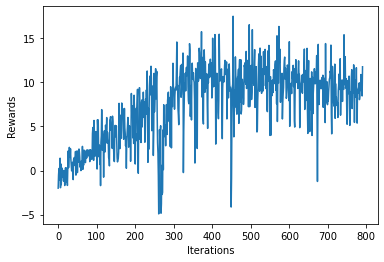

 79%|████████████████████████████████████████████████████████▏              | 79101/100000 [7:20:35<3:23:48,  1.71it/s]

Updated Weights
Mean Reward = 9.37
32


 79%|████████████████████████████████████████████████████████▏              | 79201/100000 [7:21:19<2:48:39,  2.06it/s]

Updated Weights
Mean Reward = 12.08
16


 79%|████████████████████████████████████████████████████████▎              | 79301/100000 [7:21:57<2:40:25,  2.15it/s]

Updated Weights
Mean Reward = 8.19
32


 79%|████████████████████████████████████████████████████████▎              | 79401/100000 [7:22:39<2:48:00,  2.04it/s]

Updated Weights
Mean Reward = 13.81
21


 80%|████████████████████████████████████████████████████████▍              | 79500/100000 [7:23:21<2:23:07,  2.39it/s]

Updated Weights
Mean Reward = 7.84
29


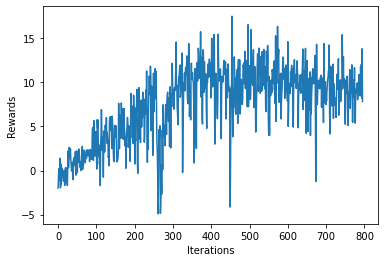

 80%|████████████████████████████████████████████████████████▌              | 79601/100000 [7:24:03<2:30:27,  2.26it/s]

Updated Weights
Mean Reward = 6.69
22


 80%|████████████████████████████████████████████████████████▌              | 79702/100000 [7:24:39<1:46:37,  3.17it/s]

Updated Weights
Mean Reward = 8.96
39


 80%|████████████████████████████████████████████████████████▋              | 79801/100000 [7:25:14<1:55:22,  2.92it/s]

Updated Weights
Mean Reward = 10.23
48


 80%|████████████████████████████████████████████████████████▋              | 79901/100000 [7:25:52<2:06:55,  2.64it/s]

Updated Weights
Mean Reward = 8.19
33


 80%|████████████████████████████████████████████████████████▊              | 80000/100000 [7:26:29<2:29:57,  2.22it/s]

Updated Weights
Mean Reward = 10.16
33


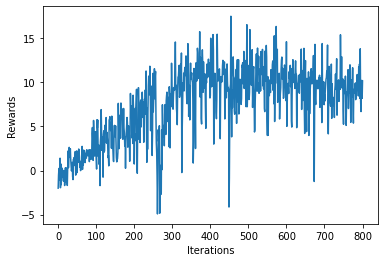

 80%|████████████████████████████████████████████████████████▊              | 80101/100000 [7:27:00<2:24:55,  2.29it/s]

Updated Weights
Mean Reward = 9.73
52


 80%|████████████████████████████████████████████████████████▉              | 80202/100000 [7:27:27<1:02:30,  5.28it/s]

Updated Weights
Mean Reward = 10.67
61


 80%|█████████████████████████████████████████████████████████              | 80301/100000 [7:27:59<1:58:10,  2.78it/s]

Updated Weights
Mean Reward = 8.73
46


 80%|█████████████████████████████████████████████████████████              | 80401/100000 [7:28:29<2:24:51,  2.25it/s]

Updated Weights
Mean Reward = 9.62
54


 80%|█████████████████████████████████████████████████████████▏             | 80500/100000 [7:29:02<1:47:07,  3.03it/s]

Updated Weights
Mean Reward = 4.56
41


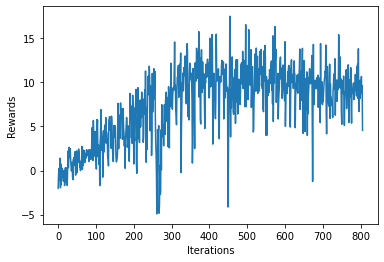

 81%|█████████████████████████████████████████████████████████▏             | 80601/100000 [7:29:41<2:12:34,  2.44it/s]

Updated Weights
Mean Reward = 6.03
39


 81%|█████████████████████████████████████████████████████████▎             | 80701/100000 [7:30:13<2:22:39,  2.25it/s]

Updated Weights
Mean Reward = 8.83
49


 81%|█████████████████████████████████████████████████████████▎             | 80801/100000 [7:30:48<2:34:44,  2.07it/s]

Updated Weights
Mean Reward = 8.23
36


 81%|█████████████████████████████████████████████████████████▍             | 80900/100000 [7:31:20<1:42:52,  3.09it/s]

Updated Weights
Mean Reward = 13.4
45


 81%|█████████████████████████████████████████████████████████▌             | 81000/100000 [7:31:52<1:52:57,  2.80it/s]

Updated Weights
Mean Reward = 9.13
50


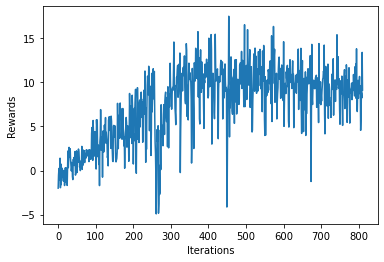

 81%|█████████████████████████████████████████████████████████▌             | 81101/100000 [7:32:21<1:57:29,  2.68it/s]

Updated Weights
Mean Reward = 9.33
53


 81%|█████████████████████████████████████████████████████████▋             | 81201/100000 [7:32:52<2:08:16,  2.44it/s]

Updated Weights
Mean Reward = 9.68
50


 81%|█████████████████████████████████████████████████████████▋             | 81301/100000 [7:33:26<1:41:28,  3.07it/s]

Updated Weights
Mean Reward = 7.53
43


 81%|█████████████████████████████████████████████████████████▊             | 81401/100000 [7:33:58<1:24:26,  3.67it/s]

Updated Weights
Mean Reward = 8.98
47


 82%|█████████████████████████████████████████████████████████▊             | 81500/100000 [7:34:29<1:05:42,  4.69it/s]

Updated Weights
Mean Reward = 9.55
49


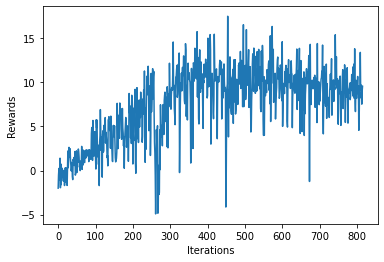

 82%|█████████████████████████████████████████████████████████▉             | 81600/100000 [7:35:03<1:28:07,  3.48it/s]

Updated Weights
Mean Reward = 9.62
51


 82%|██████████████████████████████████████████████████████████             | 81701/100000 [7:35:41<1:53:29,  2.69it/s]

Updated Weights
Mean Reward = 8.01
34


 82%|██████████████████████████████████████████████████████████             | 81802/100000 [7:36:17<1:27:29,  3.47it/s]

Updated Weights
Mean Reward = 8.43
38


 82%|██████████████████████████████████████████████████████████▏            | 81902/100000 [7:36:48<1:33:23,  3.23it/s]

Updated Weights
Mean Reward = 8.82
50


 82%|██████████████████████████████████████████████████████████▏            | 82000/100000 [7:37:18<1:29:26,  3.35it/s]

Updated Weights
Mean Reward = 7.24
51


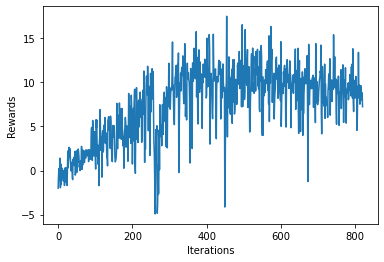

 82%|██████████████████████████████████████████████████████████▎            | 82101/100000 [7:37:55<1:46:21,  2.81it/s]

Updated Weights
Mean Reward = 9.9
54


 82%|██████████████████████████████████████████████████████████▎            | 82201/100000 [7:38:23<1:10:55,  4.18it/s]

Updated Weights
Mean Reward = 10.09
55


 82%|██████████████████████████████████████████████████████████▍            | 82302/100000 [7:38:57<1:28:01,  3.35it/s]

Updated Weights
Mean Reward = 10.31
56


 82%|██████████████████████████████████████████████████████████▌            | 82401/100000 [7:39:25<1:37:29,  3.01it/s]

Updated Weights
Mean Reward = 11.26
59


 82%|██████████████████████████████████████████████████████████▌            | 82499/100000 [7:39:51<1:28:17,  3.30it/s]

Updated Weights
Mean Reward = 11.96
62


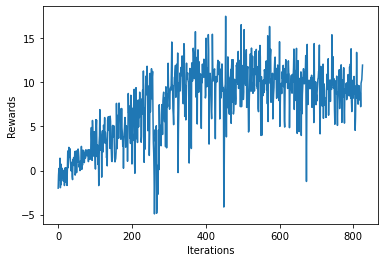

 83%|██████████████████████████████████████████████████████████▋            | 82601/100000 [7:40:23<1:57:51,  2.46it/s]

Updated Weights
Mean Reward = 11.92
50


 83%|██████████████████████████████████████████████████████████▋            | 82700/100000 [7:41:06<2:09:01,  2.23it/s]

Updated Weights
Mean Reward = 1.54
17


 83%|██████████████████████████████████████████████████████████▊            | 82801/100000 [7:41:42<1:22:50,  3.46it/s]

Updated Weights
Mean Reward = 7.61
36


 83%|██████████████████████████████████████████████████████████▊            | 82901/100000 [7:42:15<1:05:07,  4.38it/s]

Updated Weights
Mean Reward = 7.77
46


 83%|██████████████████████████████████████████████████████████▉            | 83000/100000 [7:42:52<2:43:36,  1.73it/s]

Updated Weights
Mean Reward = 10.31
40


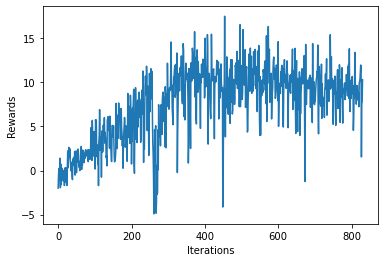

 83%|███████████████████████████████████████████████████████████            | 83102/100000 [7:43:29<1:16:30,  3.68it/s]

Updated Weights
Mean Reward = 5.65
36


 83%|███████████████████████████████████████████████████████████            | 83201/100000 [7:44:05<1:43:37,  2.70it/s]

Updated Weights
Mean Reward = 4.5
35


 83%|███████████████████████████████████████████████████████████▏           | 83302/100000 [7:44:40<1:46:32,  2.61it/s]

Updated Weights
Mean Reward = 3.8
36


 83%|███████████████████████████████████████████████████████████▏           | 83401/100000 [7:45:23<2:06:48,  2.18it/s]

Updated Weights
Mean Reward = 6.01
22


 84%|███████████████████████████████████████████████████████████▎           | 83500/100000 [7:46:05<2:02:34,  2.24it/s]

Updated Weights
Mean Reward = 4.02
17


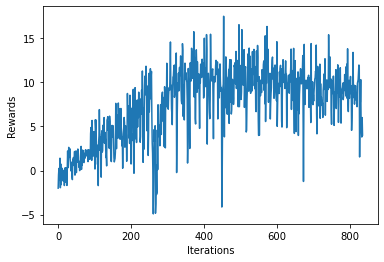

 84%|███████████████████████████████████████████████████████████▎           | 83601/100000 [7:46:44<1:52:09,  2.44it/s]

Updated Weights
Mean Reward = 9.0
34


 84%|███████████████████████████████████████████████████████████▍           | 83701/100000 [7:47:25<1:40:29,  2.70it/s]

Updated Weights
Mean Reward = 6.42
32


 84%|███████████████████████████████████████████████████████████▍           | 83801/100000 [7:48:00<1:53:31,  2.38it/s]

Updated Weights
Mean Reward = 9.04
38


 84%|███████████████████████████████████████████████████████████▌           | 83901/100000 [7:48:37<2:26:27,  1.83it/s]

Updated Weights
Mean Reward = 10.77
35


 84%|███████████████████████████████████████████████████████████▋           | 84000/100000 [7:49:15<1:46:38,  2.50it/s]

Updated Weights
Mean Reward = 8.51
41


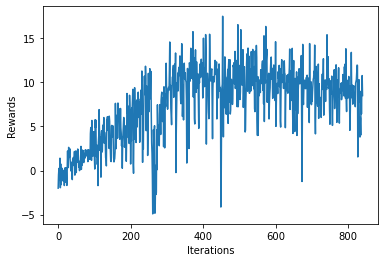

 84%|███████████████████████████████████████████████████████████▋           | 84101/100000 [7:49:50<2:09:13,  2.05it/s]

Updated Weights
Mean Reward = 7.88
39


 84%|███████████████████████████████████████████████████████████▊           | 84201/100000 [7:50:24<2:02:45,  2.15it/s]

Updated Weights
Mean Reward = 4.78
38


 84%|███████████████████████████████████████████████████████████▊           | 84302/100000 [7:51:08<1:28:35,  2.95it/s]

Updated Weights
Mean Reward = 16.06
18


 84%|███████████████████████████████████████████████████████████▉           | 84401/100000 [7:51:46<1:44:03,  2.50it/s]

Updated Weights
Mean Reward = 6.94
30


 84%|███████████████████████████████████████████████████████████▉           | 84500/100000 [7:52:22<1:20:59,  3.19it/s]

Updated Weights
Mean Reward = 11.02
35


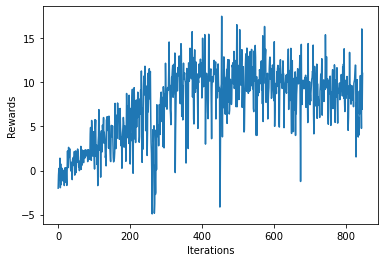

 85%|████████████████████████████████████████████████████████████           | 84600/100000 [7:53:07<1:58:41,  2.16it/s]

Updated Weights
Mean Reward = 9.35
28


 85%|████████████████████████████████████████████████████████████▏          | 84701/100000 [7:53:44<1:43:41,  2.46it/s]

Updated Weights
Mean Reward = 16.72
35


 85%|████████████████████████████████████████████████████████████▏          | 84801/100000 [7:54:28<2:03:15,  2.06it/s]

Updated Weights
Mean Reward = 12.08
16


 85%|████████████████████████████████████████████████████████████▎          | 84901/100000 [7:55:09<2:01:40,  2.07it/s]

Updated Weights
Mean Reward = 4.82
25


 85%|████████████████████████████████████████████████████████████▎          | 85000/100000 [7:55:52<1:51:22,  2.24it/s]

Updated Weights
Mean Reward = 15.84
15


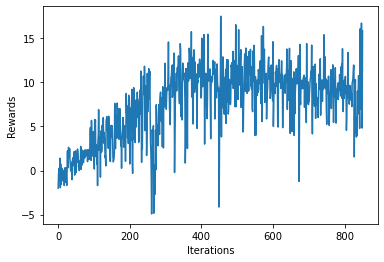

 85%|████████████████████████████████████████████████████████████▍          | 85101/100000 [7:56:36<1:59:53,  2.07it/s]

Updated Weights
Mean Reward = 4.92
15


 85%|████████████████████████████████████████████████████████████▍          | 85201/100000 [7:57:19<1:41:33,  2.43it/s]

Updated Weights
Mean Reward = 8.59
28


 85%|████████████████████████████████████████████████████████████▌          | 85301/100000 [7:58:01<1:29:02,  2.75it/s]

Updated Weights
Mean Reward = 7.36
26


 85%|████████████████████████████████████████████████████████████▋          | 85401/100000 [7:58:38<1:27:25,  2.78it/s]

Updated Weights
Mean Reward = 6.93
32


 86%|████████████████████████████████████████████████████████████▋          | 85500/100000 [7:59:15<1:13:57,  3.27it/s]

Updated Weights
Mean Reward = 7.88
35


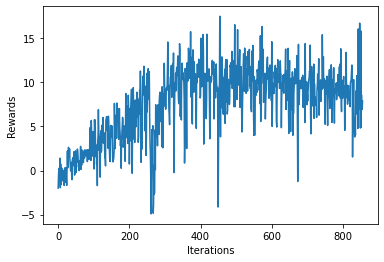

 86%|████████████████████████████████████████████████████████████▊          | 85601/100000 [7:59:51<1:26:42,  2.77it/s]

Updated Weights
Mean Reward = 6.84
38


 86%|████████████████████████████████████████████████████████████▊          | 85701/100000 [8:00:25<1:01:38,  3.87it/s]

Updated Weights
Mean Reward = 4.04
41


 86%|████████████████████████████████████████████████████████████▉          | 85802/100000 [8:01:03<1:14:31,  3.17it/s]

Updated Weights
Mean Reward = 8.2
35


 86%|████████████████████████████████████████████████████████████▉          | 85901/100000 [8:01:38<1:32:34,  2.54it/s]

Updated Weights
Mean Reward = 8.36
39


 86%|█████████████████████████████████████████████████████████████          | 86000/100000 [8:02:10<1:27:37,  2.66it/s]

Updated Weights
Mean Reward = 9.13
47


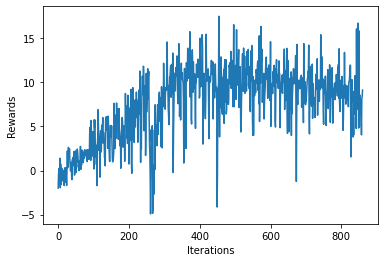

 86%|█████████████████████████████████████████████████████████████▏         | 86101/100000 [8:02:48<2:48:13,  1.38it/s]

Updated Weights
Mean Reward = 7.82
38


 86%|█████████████████████████████████████████████████████████████▏         | 86200/100000 [8:03:32<1:42:34,  2.24it/s]

Updated Weights
Mean Reward = 7.37
22


 86%|█████████████████████████████████████████████████████████████▎         | 86301/100000 [8:04:02<1:08:48,  3.32it/s]

Updated Weights
Mean Reward = 9.93
52


 86%|█████████████████████████████████████████████████████████████▎         | 86401/100000 [8:04:37<1:18:33,  2.89it/s]

Updated Weights
Mean Reward = 9.05
39


 86%|█████████████████████████████████████████████████████████████▍         | 86500/100000 [8:05:12<1:20:30,  2.79it/s]

Updated Weights
Mean Reward = 8.25
37


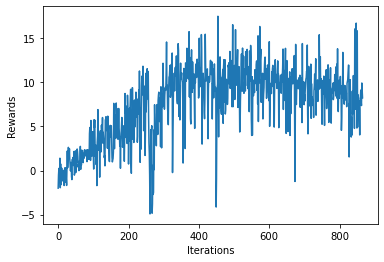

 87%|█████████████████████████████████████████████████████████████▍         | 86601/100000 [8:05:48<1:41:21,  2.20it/s]

Updated Weights
Mean Reward = 6.82
36


 87%|█████████████████████████████████████████████████████████████▌         | 86702/100000 [8:06:35<1:10:31,  3.14it/s]

Updated Weights
Mean Reward = 5.39
26


 87%|█████████████████████████████████████████████████████████████▋         | 86802/100000 [8:07:15<1:06:34,  3.30it/s]

Updated Weights
Mean Reward = 9.4
34


 87%|█████████████████████████████████████████████████████████████▋         | 86901/100000 [8:07:49<1:30:16,  2.42it/s]

Updated Weights
Mean Reward = 9.05
42


 87%|█████████████████████████████████████████████████████████████▊         | 87000/100000 [8:08:23<1:16:55,  2.82it/s]

Updated Weights
Mean Reward = 9.52
45


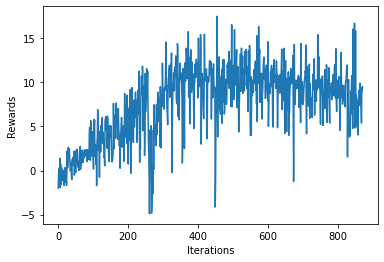

 87%|█████████████████████████████████████████████████████████████▊         | 87101/100000 [8:08:57<1:25:19,  2.52it/s]

Updated Weights
Mean Reward = 8.49
40


 87%|█████████████████████████████████████████████████████████████▉         | 87203/100000 [8:09:32<1:07:39,  3.15it/s]

Updated Weights
Mean Reward = 10.88
43


 87%|█████████████████████████████████████████████████████████████▉         | 87301/100000 [8:10:06<1:14:26,  2.84it/s]

Updated Weights
Mean Reward = 8.7
41


 87%|██████████████████████████████████████████████████████████████         | 87402/100000 [8:10:42<1:12:03,  2.91it/s]

Updated Weights
Mean Reward = 9.99
39


 88%|██████████████████████████████████████████████████████████████▏        | 87500/100000 [8:11:23<1:31:58,  2.27it/s]

Updated Weights
Mean Reward = 11.13
34


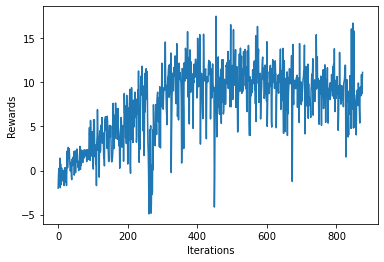

 88%|██████████████████████████████████████████████████████████████▏        | 87601/100000 [8:12:05<1:12:36,  2.85it/s]

Updated Weights
Mean Reward = 5.25
21


 88%|██████████████████████████████████████████████████████████████▎        | 87701/100000 [8:12:43<1:33:43,  2.19it/s]

Updated Weights
Mean Reward = 6.5
32


 88%|████████████████████████████████████████████████████████████████         | 87802/100000 [8:13:16<41:13,  4.93it/s]

Updated Weights
Mean Reward = 9.05
49


 88%|████████████████████████████████████████████████████████████████▏        | 87901/100000 [8:13:44<58:01,  3.48it/s]

Updated Weights
Mean Reward = 9.58
57


 88%|██████████████████████████████████████████████████████████████▍        | 88000/100000 [8:14:15<1:04:07,  3.12it/s]

Updated Weights
Mean Reward = 10.2
55


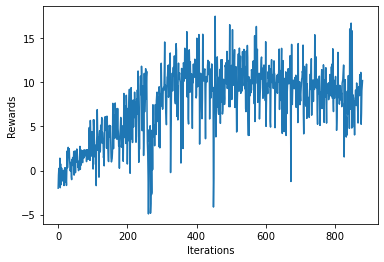

 88%|██████████████████████████████████████████████████████████████▌        | 88100/100000 [8:14:48<1:19:01,  2.51it/s]

Updated Weights
Mean Reward = 7.72
45


 88%|██████████████████████████████████████████████████████████████▌        | 88201/100000 [8:15:17<1:03:12,  3.11it/s]

Updated Weights
Mean Reward = 9.89
55


 88%|██████████████████████████████████████████████████████████████▋        | 88301/100000 [8:15:48<1:06:19,  2.94it/s]

Updated Weights
Mean Reward = 9.26
54


 88%|██████████████████████████████████████████████████████████████▊        | 88401/100000 [8:16:22<1:17:53,  2.48it/s]

Updated Weights
Mean Reward = 6.56
40


 88%|██████████████████████████████████████████████████████████████▊        | 88500/100000 [8:16:51<1:54:51,  1.67it/s]

Updated Weights
Mean Reward = 11.55
64


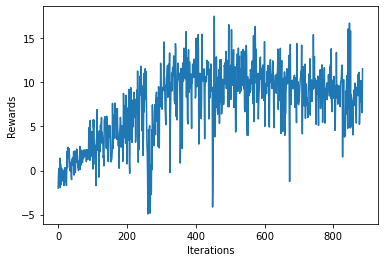

 89%|████████████████████████████████████████████████████████████████▋        | 88603/100000 [8:17:19<51:13,  3.71it/s]

Updated Weights
Mean Reward = 10.87
63


 89%|████████████████████████████████████████████████████████████████▊        | 88702/100000 [8:17:52<59:47,  3.15it/s]

Updated Weights
Mean Reward = 9.39
46


 89%|███████████████████████████████████████████████████████████████        | 88801/100000 [8:18:33<1:26:22,  2.16it/s]

Updated Weights
Mean Reward = 6.81
25


 89%|███████████████████████████████████████████████████████████████        | 88901/100000 [8:19:14<1:20:55,  2.29it/s]

Updated Weights
Mean Reward = 1.52
25


 89%|████████████████████████████████████████████████████████████████▉        | 89000/100000 [8:19:47<53:55,  3.40it/s]

Updated Weights
Mean Reward = 7.43
44


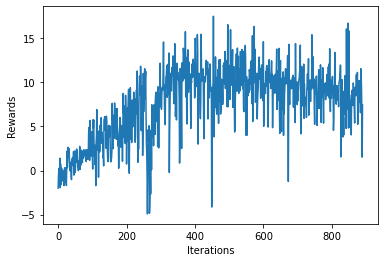

 89%|█████████████████████████████████████████████████████████████████        | 89101/100000 [8:20:21<57:44,  3.15it/s]

Updated Weights
Mean Reward = 8.2
45


 89%|█████████████████████████████████████████████████████████████████        | 89201/100000 [8:20:58<58:11,  3.09it/s]

Updated Weights
Mean Reward = 8.49
47


 89%|███████████████████████████████████████████████████████████████▍       | 89301/100000 [8:21:32<1:01:18,  2.91it/s]

Updated Weights
Mean Reward = 8.82
44


 89%|███████████████████████████████████████████████████████████████▍       | 89401/100000 [8:22:06<1:14:15,  2.38it/s]

Updated Weights
Mean Reward = 11.83
41


 90%|███████████████████████████████████████████████████████████████▌       | 89500/100000 [8:22:47<1:06:54,  2.62it/s]

Updated Weights
Mean Reward = 6.13
29


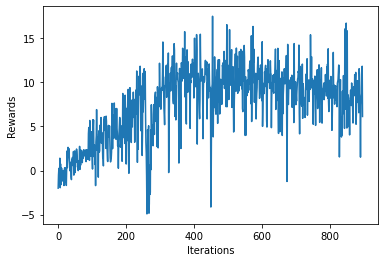

 90%|███████████████████████████████████████████████████████████████▌       | 89601/100000 [8:23:26<1:15:42,  2.29it/s]

Updated Weights
Mean Reward = 7.38
35


 90%|█████████████████████████████████████████████████████████████████▍       | 89700/100000 [8:23:57<46:41,  3.68it/s]

Updated Weights
Mean Reward = 9.03
49


 90%|█████████████████████████████████████████████████████████████████▌       | 89803/100000 [8:24:29<28:45,  5.91it/s]

Updated Weights
Mean Reward = 8.77
49


 90%|███████████████████████████████████████████████████████████████▊       | 89901/100000 [8:24:59<1:02:02,  2.71it/s]

Updated Weights
Mean Reward = 9.06
50


 90%|███████████████████████████████████████████████████████████████▉       | 89999/100000 [8:25:35<1:13:36,  2.26it/s]

Updated Weights
Mean Reward = 7.89
36


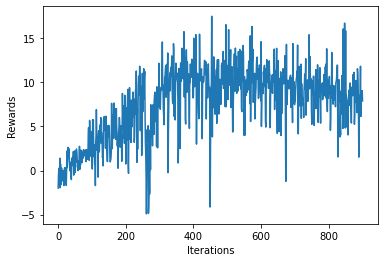

 90%|█████████████████████████████████████████████████████████████████▊       | 90101/100000 [8:26:08<35:08,  4.69it/s]

Updated Weights
Mean Reward = 9.65
47


 90%|████████████████████████████████████████████████████████████████       | 90201/100000 [8:26:46<1:38:50,  1.65it/s]

Updated Weights
Mean Reward = 9.33
34


 90%|████████████████████████████████████████████████████████████████       | 90301/100000 [8:27:21<1:17:23,  2.09it/s]

Updated Weights
Mean Reward = 8.11
39


 90%|█████████████████████████████████████████████████████████████████▉       | 90401/100000 [8:27:53<50:44,  3.15it/s]

Updated Weights
Mean Reward = 9.23
48


 90%|████████████████████████████████████████████████████████████████▎      | 90499/100000 [8:28:26<1:17:48,  2.04it/s]

Updated Weights
Mean Reward = 8.83
42


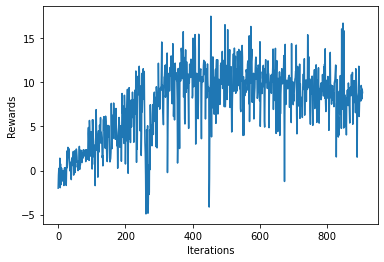

 91%|██████████████████████████████████████████████████████████████████▏      | 90602/100000 [8:28:57<27:29,  5.70it/s]

Updated Weights
Mean Reward = 9.3
50


 91%|██████████████████████████████████████████████████████████████████▏      | 90701/100000 [8:29:29<59:44,  2.59it/s]

Updated Weights
Mean Reward = 8.48
47


 91%|██████████████████████████████████████████████████████████████████▎      | 90802/100000 [8:30:04<47:36,  3.22it/s]

Updated Weights
Mean Reward = 8.23
42


 91%|██████████████████████████████████████████████████████████████████▎      | 90900/100000 [8:30:40<49:56,  3.04it/s]

Updated Weights
Mean Reward = 8.41
37


 91%|████████████████████████████████████████████████████████████████▌      | 91000/100000 [8:31:19<1:07:36,  2.22it/s]

Updated Weights
Mean Reward = 9.71
50


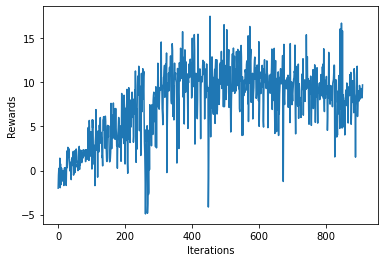

 91%|██████████████████████████████████████████████████████████████████▌      | 91102/100000 [8:31:51<44:57,  3.30it/s]

Updated Weights
Mean Reward = 9.49
51


 91%|██████████████████████████████████████████████████████████████████▌      | 91202/100000 [8:32:20<28:21,  5.17it/s]

Updated Weights
Mean Reward = 9.38
54


 91%|████████████████████████████████████████████████████████████████▊      | 91301/100000 [8:32:52<1:04:59,  2.23it/s]

Updated Weights
Mean Reward = 6.73
46


 91%|██████████████████████████████████████████████████████████████████▋      | 91402/100000 [8:33:33<51:20,  2.79it/s]

Updated Weights
Mean Reward = 12.33
23


 92%|████████████████████████████████████████████████████████████████▉      | 91500/100000 [8:34:07<1:00:18,  2.35it/s]

Updated Weights
Mean Reward = 8.23
43


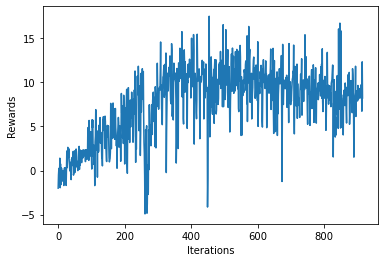

 92%|█████████████████████████████████████████████████████████████████      | 91601/100000 [8:34:52<1:41:33,  1.38it/s]

Updated Weights
Mean Reward = 7.06
25


 92%|██████████████████████████████████████████████████████████████████▉      | 91702/100000 [8:35:23<37:31,  3.68it/s]

Updated Weights
Mean Reward = 10.17
53


 92%|█████████████████████████████████████████████████████████████████▏     | 91801/100000 [8:35:55<1:00:52,  2.24it/s]

Updated Weights
Mean Reward = 9.31
50


 92%|███████████████████████████████████████████████████████████████████      | 91901/100000 [8:36:30<40:35,  3.33it/s]

Updated Weights
Mean Reward = 8.15
39


 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [8:37:07<38:19,  3.48it/s]

Updated Weights
Mean Reward = 8.53
44


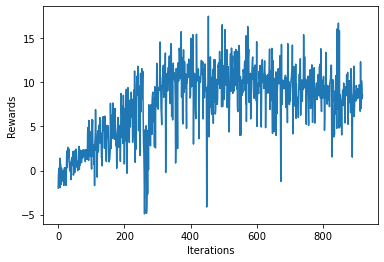

 92%|███████████████████████████████████████████████████████████████████▏     | 92101/100000 [8:37:46<46:41,  2.82it/s]

Updated Weights
Mean Reward = 7.99
36


 92%|███████████████████████████████████████████████████████████████████▎     | 92201/100000 [8:38:17<53:57,  2.41it/s]

Updated Weights
Mean Reward = 9.86
49


 92%|███████████████████████████████████████████████████████████████████▍     | 92301/100000 [8:38:54<57:28,  2.23it/s]

Updated Weights
Mean Reward = 9.45
47


 92%|███████████████████████████████████████████████████████████████████▍     | 92401/100000 [8:39:32<51:00,  2.48it/s]

Updated Weights
Mean Reward = 7.16
30


 92%|███████████████████████████████████████████████████████████████████▌     | 92500/100000 [8:40:08<49:36,  2.52it/s]

Updated Weights
Mean Reward = 8.66
34


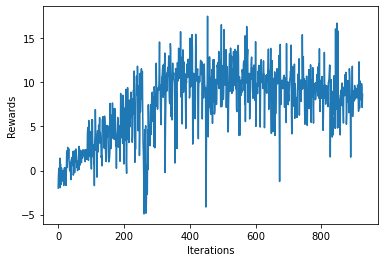

 93%|███████████████████████████████████████████████████████████████████▌     | 92601/100000 [8:40:39<35:40,  3.46it/s]

Updated Weights
Mean Reward = 8.69
52


 93%|███████████████████████████████████████████████████████████████████▋     | 92701/100000 [8:41:21<27:46,  4.38it/s]

Updated Weights
Mean Reward = 9.71
48


 93%|███████████████████████████████████████████████████████████████████▋     | 92803/100000 [8:41:47<29:20,  4.09it/s]

Updated Weights
Mean Reward = 11.17
66


 93%|███████████████████████████████████████████████████████████████████▊     | 92902/100000 [8:42:14<23:13,  5.09it/s]

Updated Weights
Mean Reward = 11.26
63


 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [8:42:56<53:48,  2.17it/s]

Updated Weights
Mean Reward = 9.41
54


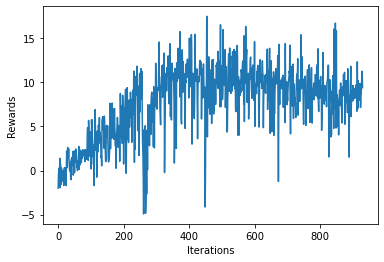

 93%|███████████████████████████████████████████████████████████████████▉     | 93101/100000 [8:43:39<54:11,  2.12it/s]

Updated Weights
Mean Reward = 5.75
27


 93%|████████████████████████████████████████████████████████████████████     | 93201/100000 [8:44:21<54:05,  2.09it/s]

Updated Weights
Mean Reward = 0.98
21


 93%|████████████████████████████████████████████████████████████████████     | 93301/100000 [8:45:09<53:53,  2.07it/s]

Updated Weights
Mean Reward = 7.2
17


 93%|████████████████████████████████████████████████████████████████████▏    | 93402/100000 [8:45:50<31:52,  3.45it/s]

Updated Weights
Mean Reward = 5.93
24


 93%|████████████████████████████████████████████████████████████████████▎    | 93499/100000 [8:46:27<32:45,  3.31it/s]

Updated Weights
Mean Reward = 7.08
31


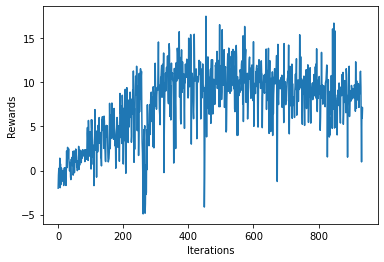

 94%|████████████████████████████████████████████████████████████████████▎    | 93601/100000 [8:47:09<52:18,  2.04it/s]

Updated Weights
Mean Reward = 10.88
27


 94%|████████████████████████████████████████████████████████████████████▍    | 93701/100000 [8:47:48<29:02,  3.62it/s]

Updated Weights
Mean Reward = 6.91
31


 94%|████████████████████████████████████████████████████████████████████▍    | 93801/100000 [8:48:29<42:31,  2.43it/s]

Updated Weights
Mean Reward = 7.78
32


 94%|████████████████████████████████████████████████████████████████████▌    | 93901/100000 [8:49:14<42:48,  2.37it/s]

Updated Weights
Mean Reward = 8.59
41


 94%|████████████████████████████████████████████████████████████████████▌    | 94000/100000 [8:49:49<33:50,  2.95it/s]

Updated Weights
Mean Reward = 7.77
39


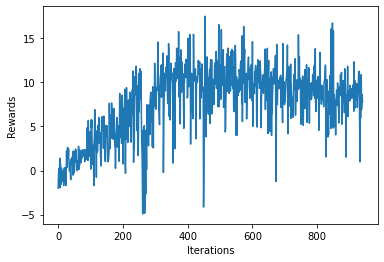

 94%|████████████████████████████████████████████████████████████████████▋    | 94101/100000 [8:50:20<17:41,  5.56it/s]

Updated Weights
Mean Reward = 9.96
51


 94%|████████████████████████████████████████████████████████████████████▊    | 94201/100000 [8:51:03<46:28,  2.08it/s]

Updated Weights
Mean Reward = 7.25
30


 94%|████████████████████████████████████████████████████████████████████▊    | 94302/100000 [8:51:36<23:42,  4.01it/s]

Updated Weights
Mean Reward = 8.27
42


 94%|████████████████████████████████████████████████████████████████████▉    | 94402/100000 [8:52:06<26:22,  3.54it/s]

Updated Weights
Mean Reward = 10.13
54


 94%|████████████████████████████████████████████████████████████████████▉    | 94499/100000 [8:52:34<28:13,  3.25it/s]

Updated Weights
Mean Reward = 9.9
53


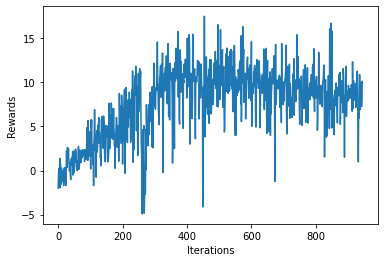

 95%|█████████████████████████████████████████████████████████████████████    | 94602/100000 [8:53:17<29:41,  3.03it/s]

Updated Weights
Mean Reward = 8.55
40


 95%|█████████████████████████████████████████████████████████████████████▏   | 94701/100000 [8:53:54<28:27,  3.10it/s]

Updated Weights
Mean Reward = 6.87
32


 95%|█████████████████████████████████████████████████████████████████████▏   | 94802/100000 [8:54:29<18:36,  4.66it/s]

Updated Weights
Mean Reward = 9.09
39


 95%|█████████████████████████████████████████████████████████████████████▎   | 94901/100000 [8:55:06<28:34,  2.97it/s]

Updated Weights
Mean Reward = 8.72
50


 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [8:55:40<36:59,  2.25it/s]

Updated Weights
Mean Reward = 8.18
41


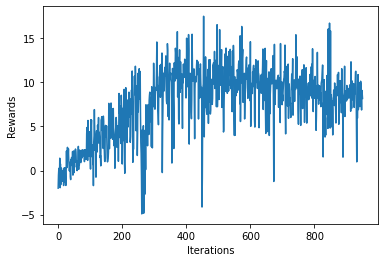

 95%|█████████████████████████████████████████████████████████████████████▍   | 95101/100000 [8:56:07<15:12,  5.37it/s]

Updated Weights
Mean Reward = 10.44
60


 95%|█████████████████████████████████████████████████████████████████████▍   | 95202/100000 [8:56:39<23:16,  3.44it/s]

Updated Weights
Mean Reward = 9.02
46


 95%|█████████████████████████████████████████████████████████████████████▌   | 95301/100000 [8:57:15<30:11,  2.59it/s]

Updated Weights
Mean Reward = 8.16
37


 95%|█████████████████████████████████████████████████████████████████████▋   | 95400/100000 [8:57:48<31:47,  2.41it/s]

Updated Weights
Mean Reward = 8.45
42


 96%|█████████████████████████████████████████████████████████████████████▋   | 95500/100000 [8:58:18<23:13,  3.23it/s]

Updated Weights
Mean Reward = 9.39
53


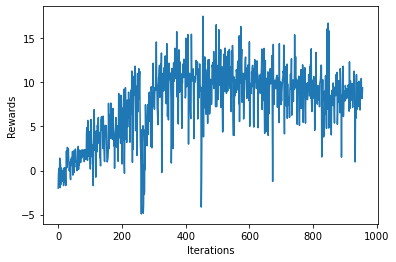

 96%|█████████████████████████████████████████████████████████████████████▊   | 95602/100000 [8:58:40<21:59,  3.33it/s]

Updated Weights
Mean Reward = 11.7
71


 96%|█████████████████████████████████████████████████████████████████████▊   | 95701/100000 [8:59:21<30:36,  2.34it/s]

Updated Weights
Mean Reward = 8.41
41


 96%|█████████████████████████████████████████████████████████████████████▉   | 95801/100000 [8:59:53<15:21,  4.56it/s]

Updated Weights
Mean Reward = 6.69
47


 96%|██████████████████████████████████████████████████████████████████████   | 95901/100000 [9:00:20<14:21,  4.76it/s]

Updated Weights
Mean Reward = 10.4
61


 96%|██████████████████████████████████████████████████████████████████████   | 96000/100000 [9:00:52<36:28,  1.83it/s]

Updated Weights
Mean Reward = 9.43
47


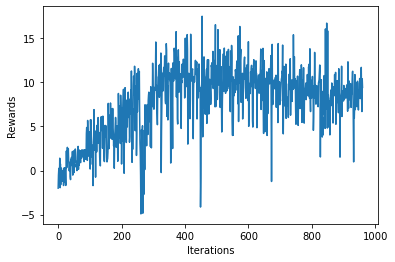

 96%|██████████████████████████████████████████████████████████████████████▏  | 96101/100000 [9:01:38<21:58,  2.96it/s]

Updated Weights
Mean Reward = 6.24
38


 96%|██████████████████████████████████████████████████████████████████████▏  | 96201/100000 [9:02:13<19:04,  3.32it/s]

Updated Weights
Mean Reward = 8.92
43


 96%|██████████████████████████████████████████████████████████████████████▎  | 96301/100000 [9:02:42<25:01,  2.46it/s]

Updated Weights
Mean Reward = 10.09
56


 96%|██████████████████████████████████████████████████████████████████████▎  | 96402/100000 [9:03:19<18:33,  3.23it/s]

Updated Weights
Mean Reward = 8.61
44


 96%|██████████████████████████████████████████████████████████████████████▍  | 96500/100000 [9:03:50<10:41,  5.46it/s]

Updated Weights
Mean Reward = 9.34
48


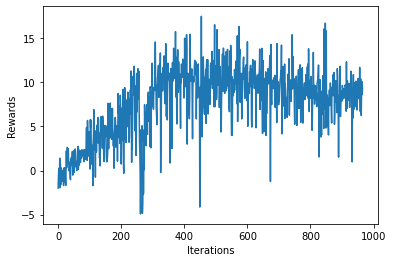

 97%|██████████████████████████████████████████████████████████████████████▌  | 96602/100000 [9:04:20<19:02,  2.97it/s]

Updated Weights
Mean Reward = 9.63
52


 97%|██████████████████████████████████████████████████████████████████████▌  | 96701/100000 [9:05:05<39:29,  1.39it/s]

Updated Weights
Mean Reward = 7.37
33


 97%|██████████████████████████████████████████████████████████████████████▋  | 96801/100000 [9:05:44<24:25,  2.18it/s]

Updated Weights
Mean Reward = 7.09
29


 97%|██████████████████████████████████████████████████████████████████████▋  | 96901/100000 [9:06:18<13:03,  3.96it/s]

Updated Weights
Mean Reward = 6.93
43


 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [9:06:55<27:03,  1.85it/s]

Updated Weights
Mean Reward = 7.43
44


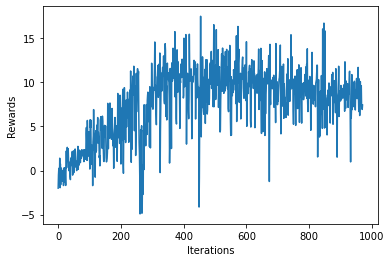

 97%|██████████████████████████████████████████████████████████████████████▉  | 97102/100000 [9:07:28<13:02,  3.70it/s]

Updated Weights
Mean Reward = 8.63
51


 97%|██████████████████████████████████████████████████████████████████████▉  | 97200/100000 [9:08:01<18:34,  2.51it/s]

Updated Weights
Mean Reward = 8.49
42


 97%|███████████████████████████████████████████████████████████████████████  | 97301/100000 [9:08:33<20:00,  2.25it/s]

Updated Weights
Mean Reward = 9.86
51


 97%|███████████████████████████████████████████████████████████████████████  | 97401/100000 [9:09:07<14:48,  2.93it/s]

Updated Weights
Mean Reward = 9.31
51


 98%|███████████████████████████████████████████████████████████████████████▏ | 97500/100000 [9:09:33<12:36,  3.30it/s]

Updated Weights
Mean Reward = 11.38
65


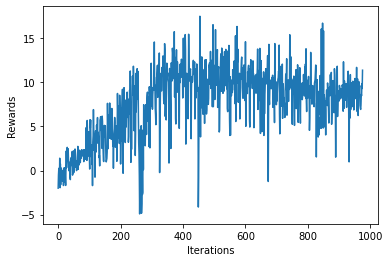

 98%|███████████████████████████████████████████████████████████████████████▏ | 97602/100000 [9:10:09<14:15,  2.80it/s]

Updated Weights
Mean Reward = 7.59
37


 98%|███████████████████████████████████████████████████████████████████████▎ | 97701/100000 [9:10:36<07:56,  4.82it/s]

Updated Weights
Mean Reward = 10.66
60


 98%|███████████████████████████████████████████████████████████████████████▍ | 97803/100000 [9:11:13<10:52,  3.37it/s]

Updated Weights
Mean Reward = 8.38
41


 98%|███████████████████████████████████████████████████████████████████████▍ | 97902/100000 [9:11:47<10:46,  3.24it/s]

Updated Weights
Mean Reward = 7.41
39


 98%|███████████████████████████████████████████████████████████████████████▌ | 98000/100000 [9:12:22<13:04,  2.55it/s]

Updated Weights
Mean Reward = 13.6
39


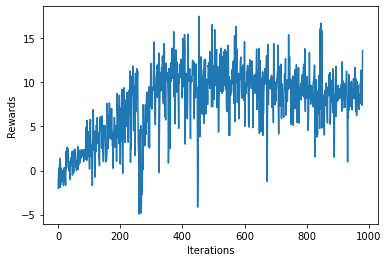

 98%|███████████████████████████████████████████████████████████████████████▌ | 98101/100000 [9:13:06<13:54,  2.27it/s]

Updated Weights
Mean Reward = 5.93
32


 98%|███████████████████████████████████████████████████████████████████████▋ | 98201/100000 [9:13:41<09:01,  3.32it/s]

Updated Weights
Mean Reward = 8.69
41


 98%|███████████████████████████████████████████████████████████████████████▊ | 98302/100000 [9:14:14<10:21,  2.73it/s]

Updated Weights
Mean Reward = 8.85
45


 98%|███████████████████████████████████████████████████████████████████████▊ | 98402/100000 [9:14:58<14:02,  1.90it/s]

Updated Weights
Mean Reward = 7.07
33


 98%|███████████████████████████████████████████████████████████████████████▉ | 98500/100000 [9:15:37<10:28,  2.39it/s]

Updated Weights
Mean Reward = 6.67
31


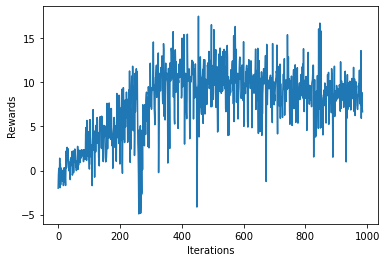

 99%|███████████████████████████████████████████████████████████████████████▉ | 98601/100000 [9:16:17<10:25,  2.24it/s]

Updated Weights
Mean Reward = 6.62
26


 99%|████████████████████████████████████████████████████████████████████████ | 98701/100000 [9:17:00<07:41,  2.81it/s]

Updated Weights
Mean Reward = 9.03
34


 99%|████████████████████████████████████████████████████████████████████████ | 98801/100000 [9:17:35<07:48,  2.56it/s]

Updated Weights
Mean Reward = 12.24
38


 99%|████████████████████████████████████████████████████████████████████████▏| 98901/100000 [9:18:19<07:22,  2.49it/s]

Updated Weights
Mean Reward = 6.21
17


 99%|████████████████████████████████████████████████████████████████████████▎| 98999/100000 [9:18:59<07:47,  2.14it/s]

Updated Weights
Mean Reward = 7.47
38


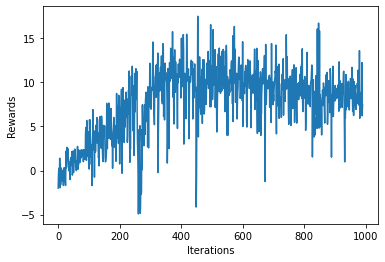

 99%|████████████████████████████████████████████████████████████████████████▎| 99101/100000 [9:19:36<06:58,  2.15it/s]

Updated Weights
Mean Reward = 7.62
33


 99%|████████████████████████████████████████████████████████████████████████▍| 99203/100000 [9:20:14<04:09,  3.20it/s]

Updated Weights
Mean Reward = 7.55
30


 99%|████████████████████████████████████████████████████████████████████████▍| 99301/100000 [9:20:48<04:08,  2.81it/s]

Updated Weights
Mean Reward = 9.86
51


 99%|████████████████████████████████████████████████████████████████████████▌| 99400/100000 [9:21:21<03:15,  3.07it/s]

Updated Weights
Mean Reward = 9.92
51


100%|████████████████████████████████████████████████████████████████████████▋| 99500/100000 [9:21:54<03:33,  2.34it/s]

Updated Weights
Mean Reward = 8.63
44


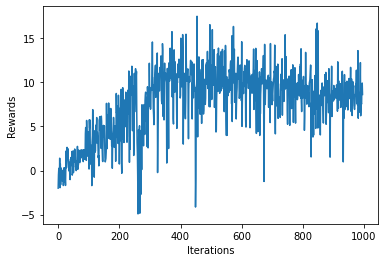

100%|████████████████████████████████████████████████████████████████████████▋| 99601/100000 [9:22:28<02:26,  2.73it/s]

Updated Weights
Mean Reward = 8.7
43


100%|████████████████████████████████████████████████████████████████████████▊| 99701/100000 [9:23:05<02:09,  2.31it/s]

Updated Weights
Mean Reward = 9.56
48


100%|████████████████████████████████████████████████████████████████████████▊| 99801/100000 [9:23:50<02:24,  1.38it/s]

Updated Weights
Mean Reward = 8.1
38


100%|████████████████████████████████████████████████████████████████████████▉| 99901/100000 [9:24:21<00:19,  5.15it/s]

Updated Weights
Mean Reward = 11.46
61


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [9:25:00<00:00,  2.95it/s]


In [5]:
# user_agent.model.load_weights('user_agent.h5')
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    mod_state = []    #deque(maxlen = prev_timesteps)
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent, mod_state)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    if epoch>50 and epoch%2500==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9

    mean_rewards.append(episode_reward)
    if epoch%100==0:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [9]:
user_agent.model = tf.keras.models.load_model('user_agent.h5')
mod_agent.model = tf.keras.models.load_model('mod_agent.h5')

In [38]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
max_steps = 40
mod_state = []
while not done and step<max_steps:
    state = np.array(state)
    print(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent, mod_state)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1

[0.3 0.1 0.5 0.9]
[0.3 0.3 0.5 0.9]
[0.3 0.4 0.5 0.9]
[0.3 0.8 0.5 0.9]
[0.3 1.  0.5 0.9]
[0.4 1.  0.5 0.9]
[0.7 1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[0.9 1.  0.5 0.9]
[0.8 1.  0.5 0.9]
[0.5 1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[0.9 1.  0.5 0.9]
[0.5 1.  0.5 0.9]
[0.7 1.  0.5 0.9]
[0.5 1.  0.5 0.9]
[0.9 1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[0.9 1.  0.5 0.9]
[0.7 1.  0.5 0.9]
[0.5 1.  0.5 0.9]
[0.8 1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[1.  1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[0.7 1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[1.  1.  0.5 0.9]
[0.8 1.  0.5 0.9]
[0.5 1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[1.  1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[0.7 1.  0.5 0.9]
[0.3 1.  0.5 0.9]
[0.5 1.  0.5 0.9]
[0.6 1.  0.5 0.9]
[0.9 1.  0.5 0.9]
[0.8 1.  0.5 0.9]
[0.4 1.  0.5 0.9]


In [11]:
print(done)

0


In [8]:
next_states = np.array([mod_agent.replay_buffer.state_history[i] for i in [0,120]])
print(next_states.shape)

(2, 4, 6)


In [9]:
print(next_states)

[[[0.  0.  0.  1.  0.  0.5]
  [0.  0.  0.  1.  0.  0.7]
  [0.  1.  0.  0.  0.  0.9]
  [1.  0.  0.  0.  0.2 0.9]]

 [[0.  1.  0.  0.  0.2 0.9]
  [0.  1.  0.  0.  0.4 0.9]
  [1.  0.  0.  0.  0.6 0.9]
  [0.  1.  0.  0.  0.5 0.9]]]


In [10]:
np.array(mod_agent.replay_buffer.state_history)

array([[[0. , 0. , 0. , 1. , 0. , 0.5],
        [0. , 0. , 0. , 1. , 0. , 0.7],
        [0. , 1. , 0. , 0. , 0. , 0.9],
        [1. , 0. , 0. , 0. , 0.2, 0.9]],

       [[0. , 0. , 0. , 1. , 0. , 0.7],
        [0. , 1. , 0. , 0. , 0. , 0.9],
        [1. , 0. , 0. , 0. , 0.2, 0.9],
        [0. , 1. , 0. , 0. , 0.1, 0.9]],

       [[0. , 1. , 0. , 0. , 0. , 0.9],
        [1. , 0. , 0. , 0. , 0.2, 0.9],
        [0. , 1. , 0. , 0. , 0.1, 0.9],
        [1. , 0. , 0. , 0. , 0.2, 0.9]],

       ...,

       [[0. , 1. , 0. , 0. , 0.6, 1. ],
        [0. , 1. , 0. , 0. , 0.7, 1. ],
        [0. , 1. , 0. , 0. , 0.8, 1. ],
        [1. , 0. , 0. , 0. , 0.9, 1. ]],

       [[0. , 1. , 0. , 0. , 0.7, 1. ],
        [0. , 1. , 0. , 0. , 0.8, 1. ],
        [1. , 0. , 0. , 0. , 0.9, 1. ],
        [0. , 1. , 0. , 0. , 0.8, 1. ]],

       [[0. , 1. , 0. , 0. , 0.8, 1. ],
        [1. , 0. , 0. , 0. , 0.9, 1. ],
        [0. , 1. , 0. , 0. , 0.8, 1. ],
        [1. , 0. , 0. , 0. , 0.9, 1. ]]])

In [11]:
user_agent.model.save('user_agent.tf')
mod_agent.model.save('mod_agent.tf')

AttributeError: 'User_Agent' object has no attribute 'save'